# Quickstart Example of Advanced Off-Policy Evaluation and Selection (Discrete)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a synthetic recommender system (REC) dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import OFRL modules
import ofrl
from recgym import RECEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead
from ofrl.policy import DiscreteEpsilonGreedyHead as EpsilonGreedyHead
from ofrl.policy import DiscreteSoftmaxHead as SoftmaxHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy as RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler
from ofrl.utils import MinMaxScaler


# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(ofrl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the recommender environment works.

#### RL setup for recommendation
In recommendation, the objective of the RL agent is to maximize reward.

We often formulate this recommendation problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: 
   - A vector representing user preference.  The preference changes over time in an episode by the actions presented by the RL agent.
   - When the true state is unobservable, you can gain observation instead of state.
- `action`:  Index of an item to present to the user.
- `reward`: User engagement signal. Either binary or continuous.


For more about the environmental configuration and its customization, please refer to [examples/quickstart/rec_synthetic_customize_env.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_customize_env.ipynb).

In [9]:
# standardized environment
env = gym.make("RECEnv-v0")

In [10]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: Recommender environment for RL defined in the previous section.
- `max_episode_steps`: Maximum number of timesteps in an episode.

For more about the data collection and visualization, please refer to [examples/quickstart/rec_synthetic_data_collection.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_data_collection.ipynb).

In [11]:
# behavior policy
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [12]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env_,
    buffer,
    explorer=explorer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

2023-02-22 10:49.59 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230222104959
2023-02-22 10:49.59 [debug    ] Building model...
2023-02-22 10:49.59 [debug    ] Model has been built.
2023-02-22 10:49.59 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230222104959/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-02-22 10:49.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230222104959/model_1000.pt
2023-02-22 10:49.59 [info     ] DoubleDQN_online_20230222104959: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.00015510416030883788, 'time_environment_step': 1.905179023742676e-05, 'time_step': 0.00018308472633361817, 'rollout_return': -0.18780045264286802, 'evaluation': -1.3193389789803984} step=1000
2023-02-22 10:50.01 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230222104959/model_2000.pt
2023-02-22 10:50.01 [info     ] DoubleDQN_online_20230222104959: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.00017266273498535157, 'time_environment_step': 3.281164169311524e-05, 'time_sample_batch': 4.571843147277832e-05, 'time_algorithm_update': 0.0009705932140350342, 'loss': 0.06340490922890604, 'time_step': 0.0012456502914428712, 'rollout_return': 1.8554032429888514, 'evaluation': 4.0754179308491745} step=2000
2023-02-22 10:50.02

In [13]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [14]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

2023-02-22 10:51.19 [warning  ] Parameters will be reinitialized.


In [15]:
behavior_policy_01 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.1,
    name="ddqn_eps_0.1",
    random_state=random_state,
)
behavior_policy_03 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_eps_0.3",
    random_state=random_state,
)
behavior_policy_05 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.5,
    name="ddqn_eps_0.5",
    random_state=random_state,
)
behavior_policy_07 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.7,
    name="ddqn_eps_0.7",
    random_state=random_state,
)
behavior_policies = [behavior_policy_01, behavior_policy_03, behavior_policy_05, behavior_policy_07]

In [16]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [17]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    # n_datasets=10, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    # n_datasets=10, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

[obtain_datasets: behavior_policy]:   0%|          | 0/4 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: behavior_policy]:   0%|          | 0/4 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
with open("logs/train_dataset_discrete_ddpn_multi.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddpn_multi.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [19]:
with open("logs/train_dataset_discrete_ddpn_multi.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddpn_multi.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/rec_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_discrete_basic.ipynb).

In [20]:
# import modules
from ofrl.policy.opl import OffPolicyLearning
# import models from d3rlpy
from d3rlpy.algos import DiscreteCQL as CQL

In [21]:
# evaluation policies
cql_b1 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)
cql_b2 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)
cql_b3 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

algorithms = [cql_b1, cql_b2, cql_b3]
algorithms_name = ["cql_b1", "cql_b2", "cql_b3"]

In [22]:
# initialize OPL class
opl = OffPolicyLearning(
    fitting_args={
        "n_steps": 10000,
        "scorers": {},
    }
)

In [23]:
# obtain base policies
base_policies = opl.learn_base_policy(
    logged_dataset=train_logged_dataset,
    algorithms=algorithms,
    random_state=random_state,
)

[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-22 10:57.23 [debug    ] RandomIterator is selected.
2023-02-22 10:57.23 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105723
2023-02-22 10:57.23 [debug    ] Building models...
2023-02-22 10:57.23 [debug    ] Models have been built.
2023-02-22 10:57.23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105723/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 10:57.33 [info     ] DiscreteCQL_20230222105723: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.10364818572998e-05, 'time_algorithm_update': 0.0008763307332992553, 'loss': 1.0398658286839724, 'time_step': 0.001002120590209961} step=10000
2023-02-22 10:57.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105723/model_10000.pt
2023-02-22 10:57.33 [debug    ] RandomIterator is selected.
2023-02-22 10:57.33 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105733
2023-02-22 10:57.33 [debug    ] Building models...
2023-02-22 10:57.33 [debug    ] Models have been built.
2023-02-22 10:57.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105733/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_ma

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 10:57.42 [info     ] DiscreteCQL_20230222105733: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.028329372406005e-05, 'time_algorithm_update': 0.0007659712076187134, 'loss': 1.009955818399787, 'time_step': 0.0008899855375289917} step=10000
2023-02-22 10:57.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105733/model_10000.pt
2023-02-22 10:57.42 [debug    ] RandomIterator is selected.
2023-02-22 10:57.42 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105742
2023-02-22 10:57.42 [debug    ] Building models...
2023-02-22 10:57.42 [debug    ] Models have been built.
2023-02-22 10:57.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105742/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generate

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 10:57.52 [info     ] DiscreteCQL_20230222105742: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.046432495117188e-05, 'time_algorithm_update': 0.0008667076349258422, 'loss': 1.0575116215854883, 'time_step': 0.0009918173551559449} step=10000
2023-02-22 10:57.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105742/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-22 10:57.52 [debug    ] RandomIterator is selected.
2023-02-22 10:57.52 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105752
2023-02-22 10:57.52 [warning  ] Skip building models since they're already built.
2023-02-22 10:57.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105752/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 10:58.03 [info     ] DiscreteCQL_20230222105752: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.146649360656739e-05, 'time_algorithm_update': 0.0008895012617111206, 'loss': 0.8892247953981162, 'time_step': 0.0010190183639526367} step=10000
2023-02-22 10:58.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105752/model_10000.pt
2023-02-22 10:58.03 [debug    ] RandomIterator is selected.
2023-02-22 10:58.03 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105803
2023-02-22 10:58.03 [warning  ] Skip building models since they're already built.
2023-02-22 10:58.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105803/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learnin

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 10:58.13 [info     ] DiscreteCQL_20230222105803: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.600846290588379e-05, 'time_algorithm_update': 0.0008629144191741944, 'loss': 0.9008996812403202, 'time_step': 0.001010669779777527} step=10000
2023-02-22 10:58.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105803/model_10000.pt
2023-02-22 10:58.13 [debug    ] RandomIterator is selected.
2023-02-22 10:58.13 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105813
2023-02-22 10:58.13 [warning  ] Skip building models since they're already built.
2023-02-22 10:58.13 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105813/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 10:58.24 [info     ] DiscreteCQL_20230222105813: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.366137504577636e-05, 'time_algorithm_update': 0.0009401513338088989, 'loss': 0.9161458824664355, 'time_step': 0.0010792116403579711} step=10000
2023-02-22 10:58.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105813/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-22 10:58.24 [debug    ] RandomIterator is selected.
2023-02-22 10:58.24 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105824
2023-02-22 10:58.24 [warning  ] Skip building models since they're already built.
2023-02-22 10:58.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105824/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 10:58.34 [info     ] DiscreteCQL_20230222105824: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.156426906585694e-05, 'time_algorithm_update': 0.0008954001903533935, 'loss': 1.3190278881311417, 'time_step': 0.0010241208553314208} step=10000
2023-02-22 10:58.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105824/model_10000.pt
2023-02-22 10:58.34 [debug    ] RandomIterator is selected.
2023-02-22 10:58.34 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105834
2023-02-22 10:58.34 [warning  ] Skip building models since they're already built.
2023-02-22 10:58.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105834/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learnin

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 10:58.44 [info     ] DiscreteCQL_20230222105834: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.129862308502197e-05, 'time_algorithm_update': 0.0007774095296859741, 'loss': 1.3340772415161133, 'time_step': 0.0009050348997116089} step=10000
2023-02-22 10:58.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105834/model_10000.pt
2023-02-22 10:58.44 [debug    ] RandomIterator is selected.
2023-02-22 10:58.44 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105844
2023-02-22 10:58.44 [warning  ] Skip building models since they're already built.
2023-02-22 10:58.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105844/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'lear

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 10:58.54 [info     ] DiscreteCQL_20230222105844: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.142994403839112e-05, 'time_algorithm_update': 0.0008909954786300659, 'loss': 1.3300936488151551, 'time_step': 0.001019625449180603} step=10000
2023-02-22 10:58.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105844/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-22 10:58.54 [debug    ] RandomIterator is selected.
2023-02-22 10:58.54 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105854
2023-02-22 10:58.54 [warning  ] Skip building models since they're already built.
2023-02-22 10:58.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105854/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 10:59.04 [info     ] DiscreteCQL_20230222105854: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.190594673156738e-05, 'time_algorithm_update': 0.000898319149017334, 'loss': 1.3339067884624005, 'time_step': 0.0010269306659698486} step=10000
2023-02-22 10:59.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105854/model_10000.pt
2023-02-22 10:59.04 [debug    ] RandomIterator is selected.
2023-02-22 10:59.04 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105904
2023-02-22 10:59.04 [warning  ] Skip building models since they're already built.
2023-02-22 10:59.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105904/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 10:59.14 [info     ] DiscreteCQL_20230222105904: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.141592502593994e-05, 'time_algorithm_update': 0.000775305962562561, 'loss': 1.359793694525957, 'time_step': 0.0009026437282562256} step=10000
2023-02-22 10:59.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105904/model_10000.pt
2023-02-22 10:59.14 [debug    ] RandomIterator is selected.
2023-02-22 10:59.14 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105914
2023-02-22 10:59.14 [warning  ] Skip building models since they're already built.
2023-02-22 10:59.14 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105914/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learni

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 10:59.24 [info     ] DiscreteCQL_20230222105914: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.145993709564209e-05, 'time_algorithm_update': 0.0008787140130996704, 'loss': 1.3517667426288127, 'time_step': 0.001005848717689514} step=10000
2023-02-22 10:59.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105914/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-22 10:59.24 [debug    ] RandomIterator is selected.
2023-02-22 10:59.24 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105924
2023-02-22 10:59.24 [warning  ] Skip building models since they're already built.
2023-02-22 10:59.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105924/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 10:59.34 [info     ] DiscreteCQL_20230222105924: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.228827476501465e-05, 'time_algorithm_update': 0.0008947722911834717, 'loss': 1.6227923129677773, 'time_step': 0.0010233924627304077} step=10000
2023-02-22 10:59.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105924/model_10000.pt
2023-02-22 10:59.34 [debug    ] RandomIterator is selected.
2023-02-22 10:59.34 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105934
2023-02-22 10:59.34 [warning  ] Skip building models since they're already built.
2023-02-22 10:59.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105934/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learnin

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 10:59.43 [info     ] DiscreteCQL_20230222105934: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.129588127136231e-05, 'time_algorithm_update': 0.000771756100654602, 'loss': 1.6429502182483673, 'time_step': 0.0008990774154663086} step=10000
2023-02-22 10:59.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105934/model_10000.pt
2023-02-22 10:59.43 [debug    ] RandomIterator is selected.
2023-02-22 10:59.43 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105943
2023-02-22 10:59.43 [warning  ] Skip building models since they're already built.
2023-02-22 10:59.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105943/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 10:59.54 [info     ] DiscreteCQL_20230222105943: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.083261013031006e-05, 'time_algorithm_update': 0.0008934449911117553, 'loss': 1.6330844131529332, 'time_step': 0.001020573854446411} step=10000
2023-02-22 10:59.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105943/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-22 10:59.54 [debug    ] RandomIterator is selected.
2023-02-22 10:59.54 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222105954
2023-02-22 10:59.54 [warning  ] Skip building models since they're already built.
2023-02-22 10:59.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105954/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 11:00.04 [info     ] DiscreteCQL_20230222105954: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.090833187103271e-05, 'time_algorithm_update': 0.0008914781093597412, 'loss': 1.667558138680458, 'time_step': 0.0010192593097686769} step=10000
2023-02-22 11:00.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222105954/model_10000.pt
2023-02-22 11:00.04 [debug    ] RandomIterator is selected.
2023-02-22 11:00.04 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222110004
2023-02-22 11:00.04 [warning  ] Skip building models since they're already built.
2023-02-22 11:00.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110004/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 11:00.13 [info     ] DiscreteCQL_20230222110004: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.030444145202637e-05, 'time_algorithm_update': 0.000760160756111145, 'loss': 1.682707964849472, 'time_step': 0.0008853595972061157} step=10000
2023-02-22 11:00.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110004/model_10000.pt
2023-02-22 11:00.13 [debug    ] RandomIterator is selected.
2023-02-22 11:00.13 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222110013
2023-02-22 11:00.13 [warning  ] Skip building models since they're already built.
2023-02-22 11:00.13 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110013/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learni

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 11:00.23 [info     ] DiscreteCQL_20230222110013: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.096214294433594e-05, 'time_algorithm_update': 0.0008860459327697754, 'loss': 1.6713423469781876, 'time_step': 0.001013555073738098} step=10000
2023-02-22 11:00.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110013/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-22 11:00.24 [debug    ] RandomIterator is selected.
2023-02-22 11:00.24 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222110024
2023-02-22 11:00.24 [warning  ] Skip building models since they're already built.
2023-02-22 11:00.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110024/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 11:00.34 [info     ] DiscreteCQL_20230222110024: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.146620750427246e-05, 'time_algorithm_update': 0.0009062887907028198, 'loss': 1.8507680049300195, 'time_step': 0.0010337706327438355} step=10000
2023-02-22 11:00.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110024/model_10000.pt
2023-02-22 11:00.34 [debug    ] RandomIterator is selected.
2023-02-22 11:00.34 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222110034
2023-02-22 11:00.34 [warning  ] Skip building models since they're already built.
2023-02-22 11:00.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110034/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learnin

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 11:00.43 [info     ] DiscreteCQL_20230222110034: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.068479061126709e-05, 'time_algorithm_update': 0.000769452714920044, 'loss': 1.8535658804655075, 'time_step': 0.0008952991247177124} step=10000
2023-02-22 11:00.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110034/model_10000.pt
2023-02-22 11:00.43 [debug    ] RandomIterator is selected.
2023-02-22 11:00.43 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222110043
2023-02-22 11:00.43 [warning  ] Skip building models since they're already built.
2023-02-22 11:00.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110043/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 11:00.54 [info     ] DiscreteCQL_20230222110043: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.292640209197998e-05, 'time_algorithm_update': 0.0009263436317443847, 'loss': 1.8493880672335625, 'time_step': 0.0010618884325027465} step=10000
2023-02-22 11:00.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110043/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-22 11:00.54 [debug    ] RandomIterator is selected.
2023-02-22 11:00.54 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222110054
2023-02-22 11:00.54 [warning  ] Skip building models since they're already built.
2023-02-22 11:00.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110054/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 11:01.05 [info     ] DiscreteCQL_20230222110054: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.266054153442383e-05, 'time_algorithm_update': 0.0009091595888137818, 'loss': 1.9014776930689812, 'time_step': 0.001039251160621643} step=10000
2023-02-22 11:01.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110054/model_10000.pt
2023-02-22 11:01.05 [debug    ] RandomIterator is selected.
2023-02-22 11:01.05 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222110105
2023-02-22 11:01.05 [warning  ] Skip building models since they're already built.
2023-02-22 11:01.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110105/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 11:01.14 [info     ] DiscreteCQL_20230222110105: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.122695446014404e-05, 'time_algorithm_update': 0.000771195125579834, 'loss': 1.9157622759580613, 'time_step': 0.0008987490653991699} step=10000
2023-02-22 11:01.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110105/model_10000.pt
2023-02-22 11:01.14 [debug    ] RandomIterator is selected.
2023-02-22 11:01.14 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230222110114
2023-02-22 11:01.14 [warning  ] Skip building models since they're already built.
2023-02-22 11:01.14 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110114/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-22 11:01.25 [info     ] DiscreteCQL_20230222110114: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.42511510848999e-05, 'time_algorithm_update': 0.000958433723449707, 'loss': 1.9053221745491027, 'time_step': 0.0010986463785171508} step=10000
2023-02-22 11:01.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230222110114/model_10000.pt


In [24]:
with open("d3rlpy_logs/multiple_discrete_base_policies.pkl", "wb") as f:
    pickle.dump(base_policies, f)

In [25]:
with open("d3rlpy_logs/multiple_discrete_base_policies.pkl", "rb") as f:
    base_policies = pickle.load(f)

In [26]:
# policy wrapper
policy_wrappers = {
    "eps_00": (
        EpsilonGreedyHead, {
            "epsilon": 0.0,
            "n_actions": env.action_space.n,
        }
    ),
    "eps_03": (
        EpsilonGreedyHead, {
            "epsilon": 0.3,
            "n_actions": env.action_space.n,
        }
    ),
    "eps_07": (
        EpsilonGreedyHead, {
            "epsilon": 0.7,
            "n_actions": env.action_space.n,
        }
    ),
    "softmax": (
        SoftmaxHead, {
            "tau": 1.0,
            "n_actions": env.action_space.n,
        }
    )
}

In [27]:
eval_policies = opl.apply_head(
    base_policies=base_policies,
    base_policies_name=algorithms_name,
    policy_wrappers=policy_wrappers,
    random_state=random_state,
)

In [28]:
[eval_policy.name for eval_policy in eval_policies[behavior_policies[0].name][0]]

['cql_b1_eps_00',
 'cql_b1_eps_03',
 'cql_b1_eps_07',
 'cql_b1_softmax',
 'cql_b2_eps_00',
 'cql_b2_eps_03',
 'cql_b2_eps_07',
 'cql_b2_softmax',
 'cql_b3_eps_00',
 'cql_b3_eps_03',
 'cql_b3_eps_07',
 'cql_b3_softmax']

## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

### Preparation: Create OPE Input

First, we obtain input dictionary using the CreateOPEInput class.

In [29]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput

In [30]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].min(axis=0),
        maximum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].max(axis=0),
    ),
)

In [31]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=eval_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

[collect input data: behavior_policy]:   0%|          | 0/4 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-22 11:01.27 [debug    ] RoundIterator is selected.
2023-02-22 11:01.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110127
2023-02-22 11:01.27 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.27 [debug    ] Building models...
2023-02-22 11:01.27 [debug    ] Models have been built.
2023-02-22 11:01.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110127/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.27 [info     ] DiscreteFQE_20230222110127: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.359169960021972e-05, 'time_algorithm_update': 0.000773592472076416, 'loss': 0.07948610552400351, 'time_step': 0.0008926916122436523} step=1000
2023-02-22 11:01.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110127/model_1000.pt
2023-02-22 11:01.28 [debug    ] RoundIterator is selected.
2023-02-22 11:01.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110128
2023-02-22 11:01.28 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.28 [debug    ] Building models...
2023-02-22 11:01.28 [debug    ] Models have been built.
2023-02-22 11:01.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110128/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.28 [info     ] DiscreteFQE_20230222110128: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.271479606628418e-05, 'time_algorithm_update': 0.0007680912017822266, 'loss': 0.08399971486628055, 'time_step': 0.0008883781433105469} step=1000
2023-02-22 11:01.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110128/model_1000.pt
2023-02-22 11:01.28 [debug    ] RoundIterator is selected.
2023-02-22 11:01.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110129
2023-02-22 11:01.29 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.29 [debug    ] Building models...
2023-02-22 11:01.29 [debug    ] Models have been built.
2023-02-22 11:01.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110129/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.30 [info     ] DiscreteFQE_20230222110129: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.135819435119629e-05, 'time_algorithm_update': 0.0007605175971984864, 'loss': 0.08209345159679651, 'time_step': 0.0008772315979003907} step=1000
2023-02-22 11:01.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110129/model_1000.pt
2023-02-22 11:01.30 [debug    ] RoundIterator is selected.
2023-02-22 11:01.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110130
2023-02-22 11:01.30 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.30 [debug    ] Building models...
2023-02-22 11:01.30 [debug    ] Models have been built.
2023-02-22 11:01.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110130/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.31 [info     ] DiscreteFQE_20230222110130: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.161497116088867e-05, 'time_algorithm_update': 0.0007607614994049072, 'loss': 0.08996894418075681, 'time_step': 0.0008766872882843017} step=1000
2023-02-22 11:01.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110130/model_1000.pt
2023-02-22 11:01.31 [debug    ] RoundIterator is selected.
2023-02-22 11:01.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110131
2023-02-22 11:01.31 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.31 [debug    ] Building models...
2023-02-22 11:01.31 [debug    ] Models have been built.
2023-02-22 11:01.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110131/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.32 [info     ] DiscreteFQE_20230222110131: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.288383483886718e-05, 'time_algorithm_update': 0.0007719883918762207, 'loss': 0.08887936613708734, 'time_step': 0.0008905527591705322} step=1000
2023-02-22 11:01.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110131/model_1000.pt
2023-02-22 11:01.32 [debug    ] RoundIterator is selected.
2023-02-22 11:01.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110132
2023-02-22 11:01.32 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.32 [debug    ] Building models...
2023-02-22 11:01.32 [debug    ] Models have been built.
2023-02-22 11:01.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110132/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.33 [info     ] DiscreteFQE_20230222110132: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.482742309570312e-05, 'time_algorithm_update': 0.0007826998233795166, 'loss': 0.0907668285407126, 'time_step': 0.0009062695503234863} step=1000
2023-02-22 11:01.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110132/model_1000.pt
2023-02-22 11:01.33 [debug    ] RoundIterator is selected.
2023-02-22 11:01.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110133
2023-02-22 11:01.33 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.33 [debug    ] Building models...
2023-02-22 11:01.33 [debug    ] Models have been built.
2023-02-22 11:01.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110133/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.34 [info     ] DiscreteFQE_20230222110133: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.228802680969239e-05, 'time_algorithm_update': 0.0007627220153808594, 'loss': 0.08318256989121436, 'time_step': 0.0008817267417907715} step=1000
2023-02-22 11:01.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110133/model_1000.pt
2023-02-22 11:01.34 [debug    ] RoundIterator is selected.
2023-02-22 11:01.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110134
2023-02-22 11:01.34 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.34 [debug    ] Building models...
2023-02-22 11:01.34 [debug    ] Models have been built.
2023-02-22 11:01.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110134/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.35 [info     ] DiscreteFQE_20230222110134: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.091044425964355e-05, 'time_algorithm_update': 0.000747631549835205, 'loss': 0.08564826338738203, 'time_step': 0.0008632547855377198} step=1000
2023-02-22 11:01.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110134/model_1000.pt
2023-02-22 11:01.35 [debug    ] RoundIterator is selected.
2023-02-22 11:01.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110135
2023-02-22 11:01.35 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.35 [debug    ] Building models...
2023-02-22 11:01.35 [debug    ] Models have been built.
2023-02-22 11:01.35 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110135/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.36 [info     ] DiscreteFQE_20230222110135: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.118796348571777e-05, 'time_algorithm_update': 0.0007563810348510743, 'loss': 0.08359068797901273, 'time_step': 0.0008725204467773437} step=1000
2023-02-22 11:01.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110135/model_1000.pt
2023-02-22 11:01.36 [debug    ] RoundIterator is selected.
2023-02-22 11:01.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110136
2023-02-22 11:01.36 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.36 [debug    ] Building models...
2023-02-22 11:01.36 [debug    ] Models have been built.
2023-02-22 11:01.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110136/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.37 [info     ] DiscreteFQE_20230222110136: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.103298187255859e-05, 'time_algorithm_update': 0.0008587191104888916, 'loss': 0.08412573216855526, 'time_step': 0.0009921882152557372} step=1000
2023-02-22 11:01.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110136/model_1000.pt
2023-02-22 11:01.37 [debug    ] RoundIterator is selected.
2023-02-22 11:01.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110137
2023-02-22 11:01.37 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.37 [debug    ] Building models...
2023-02-22 11:01.37 [debug    ] Models have been built.
2023-02-22 11:01.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110137/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.38 [info     ] DiscreteFQE_20230222110137: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.665823936462402e-05, 'time_algorithm_update': 0.0008445813655853272, 'loss': 0.07808488372713328, 'time_step': 0.0009739437103271485} step=1000
2023-02-22 11:01.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110137/model_1000.pt
2023-02-22 11:01.38 [debug    ] RoundIterator is selected.
2023-02-22 11:01.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110138
2023-02-22 11:01.38 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.38 [debug    ] Building models...
2023-02-22 11:01.38 [debug    ] Models have been built.
2023-02-22 11:01.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110138/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.39 [info     ] DiscreteFQE_20230222110138: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.392810821533203e-05, 'time_algorithm_update': 0.0007610707283020019, 'loss': 0.07970478697121143, 'time_step': 0.0008804872035980224} step=1000
2023-02-22 11:01.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110138/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-22 11:01.55 [debug    ] RoundIterator is selected.
2023-02-22 11:01.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110155
2023-02-22 11:01.55 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.55 [debug    ] Building models...
2023-02-22 11:01.55 [debug    ] Models have been built.
2023-02-22 11:01.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110155/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.56 [info     ] DiscreteFQE_20230222110155: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.785438537597656e-05, 'time_algorithm_update': 0.0008215417861938476, 'loss': 0.0733890370465815, 'time_step': 0.0009513874053955078} step=1000
2023-02-22 11:01.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110155/model_1000.pt
2023-02-22 11:01.56 [debug    ] RoundIterator is selected.
2023-02-22 11:01.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110156
2023-02-22 11:01.56 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.56 [debug    ] Building models...
2023-02-22 11:01.56 [debug    ] Models have been built.
2023-02-22 11:01.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110156/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.57 [info     ] DiscreteFQE_20230222110156: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.717131614685058e-05, 'time_algorithm_update': 0.0008185255527496338, 'loss': 0.07667844424024224, 'time_step': 0.0009443809986114502} step=1000
2023-02-22 11:01.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110156/model_1000.pt
2023-02-22 11:01.57 [debug    ] RoundIterator is selected.
2023-02-22 11:01.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110157
2023-02-22 11:01.57 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.57 [debug    ] Building models...
2023-02-22 11:01.57 [debug    ] Models have been built.
2023-02-22 11:01.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110157/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.58 [info     ] DiscreteFQE_20230222110157: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.218693733215332e-05, 'time_algorithm_update': 0.0007709145545959472, 'loss': 0.08386482257768511, 'time_step': 0.0008871018886566162} step=1000
2023-02-22 11:01.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110157/model_1000.pt
2023-02-22 11:01.58 [debug    ] RoundIterator is selected.
2023-02-22 11:01.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110158
2023-02-22 11:01.58 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.58 [debug    ] Building models...
2023-02-22 11:01.58 [debug    ] Models have been built.
2023-02-22 11:01.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110158/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:01.59 [info     ] DiscreteFQE_20230222110158: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.243179321289063e-05, 'time_algorithm_update': 0.0007909412384033203, 'loss': 0.09167192977666855, 'time_step': 0.0009096379280090331} step=1000
2023-02-22 11:01.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110158/model_1000.pt
2023-02-22 11:01.59 [debug    ] RoundIterator is selected.
2023-02-22 11:01.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110159
2023-02-22 11:01.59 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:01.59 [debug    ] Building models...
2023-02-22 11:01.59 [debug    ] Models have been built.
2023-02-22 11:01.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110159/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.00 [info     ] DiscreteFQE_20230222110159: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.261275291442871e-05, 'time_algorithm_update': 0.0007703485488891602, 'loss': 0.0866742603480816, 'time_step': 0.0008876888751983643} step=1000
2023-02-22 11:02.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110159/model_1000.pt
2023-02-22 11:02.00 [debug    ] RoundIterator is selected.
2023-02-22 11:02.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110200
2023-02-22 11:02.00 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.00 [debug    ] Building models...
2023-02-22 11:02.00 [debug    ] Models have been built.
2023-02-22 11:02.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110200/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.01 [info     ] DiscreteFQE_20230222110200: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.18021297454834e-05, 'time_algorithm_update': 0.0007483856678009033, 'loss': 0.09763445159047843, 'time_step': 0.0008644552230834961} step=1000
2023-02-22 11:02.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110200/model_1000.pt
2023-02-22 11:02.01 [debug    ] RoundIterator is selected.
2023-02-22 11:02.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110201
2023-02-22 11:02.01 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.01 [debug    ] Building models...
2023-02-22 11:02.01 [debug    ] Models have been built.
2023-02-22 11:02.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110201/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.02 [info     ] DiscreteFQE_20230222110201: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.10544490814209e-05, 'time_algorithm_update': 0.0007518959045410156, 'loss': 0.08353196348249912, 'time_step': 0.0008664078712463379} step=1000
2023-02-22 11:02.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110201/model_1000.pt
2023-02-22 11:02.02 [debug    ] RoundIterator is selected.
2023-02-22 11:02.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110202
2023-02-22 11:02.02 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.02 [debug    ] Building models...
2023-02-22 11:02.02 [debug    ] Models have been built.
2023-02-22 11:02.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110202/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.03 [info     ] DiscreteFQE_20230222110202: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.254337310791015e-05, 'time_algorithm_update': 0.0007633507251739502, 'loss': 0.08315059672668576, 'time_step': 0.0008815445899963379} step=1000
2023-02-22 11:02.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110202/model_1000.pt
2023-02-22 11:02.03 [debug    ] RoundIterator is selected.
2023-02-22 11:02.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110203
2023-02-22 11:02.03 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.03 [debug    ] Building models...
2023-02-22 11:02.03 [debug    ] Models have been built.
2023-02-22 11:02.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110203/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.04 [info     ] DiscreteFQE_20230222110203: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.394312858581544e-05, 'time_algorithm_update': 0.0007997434139251709, 'loss': 0.09114544966071844, 'time_step': 0.0009218754768371583} step=1000
2023-02-22 11:02.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110203/model_1000.pt
2023-02-22 11:02.04 [debug    ] RoundIterator is selected.
2023-02-22 11:02.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110204
2023-02-22 11:02.04 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.04 [debug    ] Building models...
2023-02-22 11:02.04 [debug    ] Models have been built.
2023-02-22 11:02.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110204/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.04 [info     ] DiscreteFQE_20230222110204: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.26730728149414e-05, 'time_algorithm_update': 0.0007778263092041016, 'loss': 0.08718616248667241, 'time_step': 0.0008954658508300782} step=1000
2023-02-22 11:02.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110204/model_1000.pt
2023-02-22 11:02.04 [debug    ] RoundIterator is selected.
2023-02-22 11:02.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110205
2023-02-22 11:02.06 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.06 [debug    ] Building models...
2023-02-22 11:02.06 [debug    ] Models have been built.
2023-02-22 11:02.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110205/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.06 [info     ] DiscreteFQE_20230222110205: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.191585540771484e-05, 'time_algorithm_update': 0.0007650704383850098, 'loss': 0.08284358205273748, 'time_step': 0.0008815393447875976} step=1000
2023-02-22 11:02.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110205/model_1000.pt
2023-02-22 11:02.06 [debug    ] RoundIterator is selected.
2023-02-22 11:02.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110206
2023-02-22 11:02.06 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.06 [debug    ] Building models...
2023-02-22 11:02.06 [debug    ] Models have been built.
2023-02-22 11:02.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110206/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.07 [info     ] DiscreteFQE_20230222110206: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.213496208190919e-05, 'time_algorithm_update': 0.0007607297897338867, 'loss': 0.08931687780097126, 'time_step': 0.0008773372173309326} step=1000
2023-02-22 11:02.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110206/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['ddqn_eps_0.1']


[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-22 11:02.23 [debug    ] RoundIterator is selected.
2023-02-22 11:02.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110223
2023-02-22 11:02.23 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.23 [debug    ] Building models...
2023-02-22 11:02.23 [debug    ] Models have been built.
2023-02-22 11:02.23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110223/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.24 [info     ] DiscreteFQE_20230222110223: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.27333927154541e-05, 'time_algorithm_update': 0.0007770116329193116, 'loss': 0.07625967007502914, 'time_step': 0.0008954637050628663} step=1000
2023-02-22 11:02.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110223/model_1000.pt
2023-02-22 11:02.24 [debug    ] RoundIterator is selected.
2023-02-22 11:02.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110224
2023-02-22 11:02.24 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.24 [debug    ] Building models...
2023-02-22 11:02.24 [debug    ] Models have been built.
2023-02-22 11:02.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110224/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.25 [info     ] DiscreteFQE_20230222110224: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.229374885559083e-05, 'time_algorithm_update': 0.0007596161365509034, 'loss': 0.09558115739375353, 'time_step': 0.0008775773048400879} step=1000
2023-02-22 11:02.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110224/model_1000.pt
2023-02-22 11:02.25 [debug    ] RoundIterator is selected.
2023-02-22 11:02.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110225
2023-02-22 11:02.25 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.25 [debug    ] Building models...
2023-02-22 11:02.25 [debug    ] Models have been built.
2023-02-22 11:02.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110225/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.26 [info     ] DiscreteFQE_20230222110225: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.618402481079102e-05, 'time_algorithm_update': 0.0008046538829803467, 'loss': 0.09356022235378623, 'time_step': 0.0009292376041412354} step=1000
2023-02-22 11:02.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110225/model_1000.pt
2023-02-22 11:02.26 [debug    ] RoundIterator is selected.
2023-02-22 11:02.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110226
2023-02-22 11:02.26 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.26 [debug    ] Building models...
2023-02-22 11:02.26 [debug    ] Models have been built.
2023-02-22 11:02.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110226/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.27 [info     ] DiscreteFQE_20230222110226: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.19849967956543e-05, 'time_algorithm_update': 0.0007705183029174805, 'loss': 0.07789661158993841, 'time_step': 0.000888554334640503} step=1000
2023-02-22 11:02.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110226/model_1000.pt
2023-02-22 11:02.27 [debug    ] RoundIterator is selected.
2023-02-22 11:02.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110227
2023-02-22 11:02.27 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.27 [debug    ] Building models...
2023-02-22 11:02.27 [debug    ] Models have been built.
2023-02-22 11:02.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110227/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.28 [info     ] DiscreteFQE_20230222110227: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.311271667480469e-05, 'time_algorithm_update': 0.0007562196254730225, 'loss': 0.08372324000298977, 'time_step': 0.000875314474105835} step=1000
2023-02-22 11:02.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110227/model_1000.pt
2023-02-22 11:02.28 [debug    ] RoundIterator is selected.
2023-02-22 11:02.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110228
2023-02-22 11:02.28 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.28 [debug    ] Building models...
2023-02-22 11:02.28 [debug    ] Models have been built.
2023-02-22 11:02.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110228/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.29 [info     ] DiscreteFQE_20230222110228: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.228659629821777e-05, 'time_algorithm_update': 0.0007537195682525635, 'loss': 0.07746051460132003, 'time_step': 0.000871584415435791} step=1000
2023-02-22 11:02.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110228/model_1000.pt
2023-02-22 11:02.29 [debug    ] RoundIterator is selected.
2023-02-22 11:02.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110229
2023-02-22 11:02.29 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.29 [debug    ] Building models...
2023-02-22 11:02.29 [debug    ] Models have been built.
2023-02-22 11:02.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110229/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.29 [info     ] DiscreteFQE_20230222110229: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.076167106628417e-05, 'time_algorithm_update': 0.0007436637878417969, 'loss': 0.07645470033958554, 'time_step': 0.0008568356037139893} step=1000
2023-02-22 11:02.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110229/model_1000.pt
2023-02-22 11:02.29 [debug    ] RoundIterator is selected.
2023-02-22 11:02.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110230
2023-02-22 11:02.30 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.30 [debug    ] Building models...
2023-02-22 11:02.30 [debug    ] Models have been built.
2023-02-22 11:02.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110230/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.31 [info     ] DiscreteFQE_20230222110230: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.324265480041503e-05, 'time_algorithm_update': 0.0007629451751708984, 'loss': 0.07649073872342706, 'time_step': 0.0008821048736572265} step=1000
2023-02-22 11:02.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110230/model_1000.pt
2023-02-22 11:02.31 [debug    ] RoundIterator is selected.
2023-02-22 11:02.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110231
2023-02-22 11:02.31 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.31 [debug    ] Building models...
2023-02-22 11:02.31 [debug    ] Models have been built.
2023-02-22 11:02.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110231/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.32 [info     ] DiscreteFQE_20230222110231: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.440589904785156e-05, 'time_algorithm_update': 0.0007982676029205323, 'loss': 0.10370052189007402, 'time_step': 0.0009204299449920655} step=1000
2023-02-22 11:02.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110231/model_1000.pt
2023-02-22 11:02.32 [debug    ] RoundIterator is selected.
2023-02-22 11:02.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110232
2023-02-22 11:02.32 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.32 [debug    ] Building models...
2023-02-22 11:02.32 [debug    ] Models have been built.
2023-02-22 11:02.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110232/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.33 [info     ] DiscreteFQE_20230222110232: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.691143989562989e-05, 'time_algorithm_update': 0.0008030467033386231, 'loss': 0.08070450749993324, 'time_step': 0.000929997444152832} step=1000
2023-02-22 11:02.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110232/model_1000.pt
2023-02-22 11:02.33 [debug    ] RoundIterator is selected.
2023-02-22 11:02.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110233
2023-02-22 11:02.33 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.33 [debug    ] Building models...
2023-02-22 11:02.33 [debug    ] Models have been built.
2023-02-22 11:02.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110233/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.34 [info     ] DiscreteFQE_20230222110233: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.251881599426269e-05, 'time_algorithm_update': 0.0007825150489807129, 'loss': 0.0771771719865501, 'time_step': 0.0009002983570098877} step=1000
2023-02-22 11:02.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110233/model_1000.pt
2023-02-22 11:02.34 [debug    ] RoundIterator is selected.
2023-02-22 11:02.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110234
2023-02-22 11:02.34 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.34 [debug    ] Building models...
2023-02-22 11:02.34 [debug    ] Models have been built.
2023-02-22 11:02.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110234/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.35 [info     ] DiscreteFQE_20230222110234: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.117890357971191e-05, 'time_algorithm_update': 0.0007656576633453369, 'loss': 0.07620682986080647, 'time_step': 0.0008801324367523194} step=1000
2023-02-22 11:02.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110234/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-22 11:02.51 [debug    ] RoundIterator is selected.
2023-02-22 11:02.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110251
2023-02-22 11:02.51 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.51 [debug    ] Building models...
2023-02-22 11:02.51 [debug    ] Models have been built.
2023-02-22 11:02.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110251/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.52 [info     ] DiscreteFQE_20230222110251: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.80415439605713e-05, 'time_algorithm_update': 0.0008477241992950439, 'loss': 0.07565516185760499, 'time_step': 0.0009746224880218505} step=1000
2023-02-22 11:02.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110251/model_1000.pt
2023-02-22 11:02.52 [debug    ] RoundIterator is selected.
2023-02-22 11:02.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110252
2023-02-22 11:02.52 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.52 [debug    ] Building models...
2023-02-22 11:02.52 [debug    ] Models have been built.
2023-02-22 11:02.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110252/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.53 [info     ] DiscreteFQE_20230222110252: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.202600479125976e-05, 'time_algorithm_update': 0.0007772281169891358, 'loss': 0.0791310574002564, 'time_step': 0.0008953306674957276} step=1000
2023-02-22 11:02.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110252/model_1000.pt
2023-02-22 11:02.53 [debug    ] RoundIterator is selected.
2023-02-22 11:02.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110253
2023-02-22 11:02.53 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.53 [debug    ] Building models...
2023-02-22 11:02.53 [debug    ] Models have been built.
2023-02-22 11:02.53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110253/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.54 [info     ] DiscreteFQE_20230222110253: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.259201049804687e-05, 'time_algorithm_update': 0.0007766733169555664, 'loss': 0.07249986801296472, 'time_step': 0.0008953168392181397} step=1000
2023-02-22 11:02.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110253/model_1000.pt
2023-02-22 11:02.54 [debug    ] RoundIterator is selected.
2023-02-22 11:02.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110254
2023-02-22 11:02.54 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.54 [debug    ] Building models...
2023-02-22 11:02.54 [debug    ] Models have been built.
2023-02-22 11:02.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110254/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.55 [info     ] DiscreteFQE_20230222110254: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.220362663269042e-05, 'time_algorithm_update': 0.0007646281719207764, 'loss': 0.07576288045197725, 'time_step': 0.0008817296028137207} step=1000
2023-02-22 11:02.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110254/model_1000.pt
2023-02-22 11:02.55 [debug    ] RoundIterator is selected.
2023-02-22 11:02.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110255
2023-02-22 11:02.55 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.55 [debug    ] Building models...
2023-02-22 11:02.55 [debug    ] Models have been built.
2023-02-22 11:02.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110255/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.56 [info     ] DiscreteFQE_20230222110255: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.34801197052002e-05, 'time_algorithm_update': 0.0007836380004882812, 'loss': 0.07349309511482716, 'time_step': 0.0009047319889068604} step=1000
2023-02-22 11:02.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110255/model_1000.pt
2023-02-22 11:02.56 [debug    ] RoundIterator is selected.
2023-02-22 11:02.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110256
2023-02-22 11:02.56 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.56 [debug    ] Building models...
2023-02-22 11:02.56 [debug    ] Models have been built.
2023-02-22 11:02.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110256/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.56 [info     ] DiscreteFQE_20230222110256: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.150911331176758e-05, 'time_algorithm_update': 0.0007673263549804688, 'loss': 0.07375741827115416, 'time_step': 0.0008824210166931152} step=1000
2023-02-22 11:02.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110256/model_1000.pt
2023-02-22 11:02.56 [debug    ] RoundIterator is selected.
2023-02-22 11:02.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110257
2023-02-22 11:02.57 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.57 [debug    ] Building models...
2023-02-22 11:02.57 [debug    ] Models have been built.
2023-02-22 11:02.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110257/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.58 [info     ] DiscreteFQE_20230222110257: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.320975303649902e-05, 'time_algorithm_update': 0.0007566802501678466, 'loss': 0.0884138804115355, 'time_step': 0.0008737595081329346} step=1000
2023-02-22 11:02.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110257/model_1000.pt
2023-02-22 11:02.58 [debug    ] RoundIterator is selected.
2023-02-22 11:02.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110258
2023-02-22 11:02.58 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.58 [debug    ] Building models...
2023-02-22 11:02.58 [debug    ] Models have been built.
2023-02-22 11:02.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110258/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:02.59 [info     ] DiscreteFQE_20230222110258: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.140802383422851e-05, 'time_algorithm_update': 0.0007633852958679199, 'loss': 0.07093429946154356, 'time_step': 0.0008782885074615479} step=1000
2023-02-22 11:02.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110258/model_1000.pt
2023-02-22 11:02.59 [debug    ] RoundIterator is selected.
2023-02-22 11:02.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110259
2023-02-22 11:02.59 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:02.59 [debug    ] Building models...
2023-02-22 11:02.59 [debug    ] Models have been built.
2023-02-22 11:02.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110259/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.00 [info     ] DiscreteFQE_20230222110259: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.336281776428223e-05, 'time_algorithm_update': 0.0007703382968902588, 'loss': 0.07340050119906665, 'time_step': 0.0008892853260040283} step=1000
2023-02-22 11:03.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110259/model_1000.pt
2023-02-22 11:03.00 [debug    ] RoundIterator is selected.
2023-02-22 11:03.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110300
2023-02-22 11:03.00 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.00 [debug    ] Building models...
2023-02-22 11:03.00 [debug    ] Models have been built.
2023-02-22 11:03.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110300/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.01 [info     ] DiscreteFQE_20230222110300: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.297204971313476e-05, 'time_algorithm_update': 0.0007778022289276123, 'loss': 0.07767628567293286, 'time_step': 0.0008960959911346435} step=1000
2023-02-22 11:03.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110300/model_1000.pt
2023-02-22 11:03.01 [debug    ] RoundIterator is selected.
2023-02-22 11:03.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110301
2023-02-22 11:03.01 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.01 [debug    ] Building models...
2023-02-22 11:03.01 [debug    ] Models have been built.
2023-02-22 11:03.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110301/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.02 [info     ] DiscreteFQE_20230222110301: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.216214179992676e-05, 'time_algorithm_update': 0.0007600982189178467, 'loss': 0.08429852927476168, 'time_step': 0.0008772666454315186} step=1000
2023-02-22 11:03.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110301/model_1000.pt
2023-02-22 11:03.02 [debug    ] RoundIterator is selected.
2023-02-22 11:03.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110302
2023-02-22 11:03.02 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.02 [debug    ] Building models...
2023-02-22 11:03.02 [debug    ] Models have been built.
2023-02-22 11:03.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110302/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.03 [info     ] DiscreteFQE_20230222110302: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.224987983703613e-05, 'time_algorithm_update': 0.0007619855403900146, 'loss': 0.07006127166002989, 'time_step': 0.0008800308704376221} step=1000
2023-02-22 11:03.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110302/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['ddqn_eps_0.1', 'ddqn_eps_0.3']


[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-22 11:03.19 [debug    ] RoundIterator is selected.
2023-02-22 11:03.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110319
2023-02-22 11:03.19 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.19 [debug    ] Building models...
2023-02-22 11:03.19 [debug    ] Models have been built.
2023-02-22 11:03.19 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110319/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.19 [info     ] DiscreteFQE_20230222110319: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.174705505371094e-05, 'time_algorithm_update': 0.0007654314041137696, 'loss': 0.0870507448464632, 'time_step': 0.0008830366134643555} step=1000
2023-02-22 11:03.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110319/model_1000.pt
2023-02-22 11:03.19 [debug    ] RoundIterator is selected.
2023-02-22 11:03.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110320
2023-02-22 11:03.20 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.20 [debug    ] Building models...
2023-02-22 11:03.21 [debug    ] Models have been built.
2023-02-22 11:03.21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110320/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.21 [info     ] DiscreteFQE_20230222110320: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.184361457824707e-05, 'time_algorithm_update': 0.0007694647312164307, 'loss': 0.06497013993933796, 'time_step': 0.000885615348815918} step=1000
2023-02-22 11:03.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110320/model_1000.pt
2023-02-22 11:03.21 [debug    ] RoundIterator is selected.
2023-02-22 11:03.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110321
2023-02-22 11:03.21 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.21 [debug    ] Building models...
2023-02-22 11:03.21 [debug    ] Models have been built.
2023-02-22 11:03.21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110321/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.22 [info     ] DiscreteFQE_20230222110321: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.164668083190918e-05, 'time_algorithm_update': 0.0007559125423431397, 'loss': 0.06587041055038571, 'time_step': 0.000871438980102539} step=1000
2023-02-22 11:03.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110321/model_1000.pt
2023-02-22 11:03.22 [debug    ] RoundIterator is selected.
2023-02-22 11:03.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110322
2023-02-22 11:03.22 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.22 [debug    ] Building models...
2023-02-22 11:03.22 [debug    ] Models have been built.
2023-02-22 11:03.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110322/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.23 [info     ] DiscreteFQE_20230222110322: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.230113983154298e-05, 'time_algorithm_update': 0.0007645504474639893, 'loss': 0.07019787897914648, 'time_step': 0.0008799374103546142} step=1000
2023-02-22 11:03.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110322/model_1000.pt
2023-02-22 11:03.23 [debug    ] RoundIterator is selected.
2023-02-22 11:03.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110323
2023-02-22 11:03.23 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.23 [debug    ] Building models...
2023-02-22 11:03.23 [debug    ] Models have been built.
2023-02-22 11:03.23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110323/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.24 [info     ] DiscreteFQE_20230222110323: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.252739906311035e-05, 'time_algorithm_update': 0.0007591638565063477, 'loss': 0.06374444377794862, 'time_step': 0.0008778548240661621} step=1000
2023-02-22 11:03.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110323/model_1000.pt
2023-02-22 11:03.24 [debug    ] RoundIterator is selected.
2023-02-22 11:03.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110324
2023-02-22 11:03.24 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.24 [debug    ] Building models...
2023-02-22 11:03.24 [debug    ] Models have been built.
2023-02-22 11:03.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110324/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.25 [info     ] DiscreteFQE_20230222110324: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.224368095397949e-05, 'time_algorithm_update': 0.0007493827342987061, 'loss': 0.06899498745426536, 'time_step': 0.0008656072616577148} step=1000
2023-02-22 11:03.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110324/model_1000.pt
2023-02-22 11:03.25 [debug    ] RoundIterator is selected.
2023-02-22 11:03.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110325
2023-02-22 11:03.25 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.25 [debug    ] Building models...
2023-02-22 11:03.25 [debug    ] Models have been built.
2023-02-22 11:03.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110325/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.26 [info     ] DiscreteFQE_20230222110325: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.131003379821777e-05, 'time_algorithm_update': 0.0007466456890106201, 'loss': 0.06826350977644324, 'time_step': 0.0008622498512268066} step=1000
2023-02-22 11:03.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110325/model_1000.pt
2023-02-22 11:03.26 [debug    ] RoundIterator is selected.
2023-02-22 11:03.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110326
2023-02-22 11:03.26 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.26 [debug    ] Building models...
2023-02-22 11:03.26 [debug    ] Models have been built.
2023-02-22 11:03.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110326/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.27 [info     ] DiscreteFQE_20230222110326: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.190274238586425e-05, 'time_algorithm_update': 0.0007604012489318847, 'loss': 0.07339146751537919, 'time_step': 0.0008773479461669922} step=1000
2023-02-22 11:03.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110326/model_1000.pt
2023-02-22 11:03.27 [debug    ] RoundIterator is selected.
2023-02-22 11:03.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110327
2023-02-22 11:03.27 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.27 [debug    ] Building models...
2023-02-22 11:03.27 [debug    ] Models have been built.
2023-02-22 11:03.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110327/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.28 [info     ] DiscreteFQE_20230222110327: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.323836326599121e-05, 'time_algorithm_update': 0.0007755422592163086, 'loss': 0.0701066929474473, 'time_step': 0.0008937270641326905} step=1000
2023-02-22 11:03.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110327/model_1000.pt
2023-02-22 11:03.28 [debug    ] RoundIterator is selected.
2023-02-22 11:03.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110328
2023-02-22 11:03.28 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.28 [debug    ] Building models...
2023-02-22 11:03.28 [debug    ] Models have been built.
2023-02-22 11:03.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110328/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.29 [info     ] DiscreteFQE_20230222110328: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.258700370788574e-05, 'time_algorithm_update': 0.0007690868377685547, 'loss': 0.06815729109570384, 'time_step': 0.000886340856552124} step=1000
2023-02-22 11:03.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110328/model_1000.pt
2023-02-22 11:03.29 [debug    ] RoundIterator is selected.
2023-02-22 11:03.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110329
2023-02-22 11:03.29 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.29 [debug    ] Building models...
2023-02-22 11:03.29 [debug    ] Models have been built.
2023-02-22 11:03.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110329/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.30 [info     ] DiscreteFQE_20230222110329: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.175802230834961e-05, 'time_algorithm_update': 0.0007659850120544433, 'loss': 0.0662443758584559, 'time_step': 0.0008806436061859131} step=1000
2023-02-22 11:03.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110329/model_1000.pt
2023-02-22 11:03.30 [debug    ] RoundIterator is selected.
2023-02-22 11:03.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110330
2023-02-22 11:03.30 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.30 [debug    ] Building models...
2023-02-22 11:03.30 [debug    ] Models have been built.
2023-02-22 11:03.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110330/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.30 [info     ] DiscreteFQE_20230222110330: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.912588119506836e-05, 'time_algorithm_update': 0.0007536742687225342, 'loss': 0.06369462418556214, 'time_step': 0.0008625969886779785} step=1000
2023-02-22 11:03.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110330/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-22 11:03.47 [debug    ] RoundIterator is selected.
2023-02-22 11:03.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110347
2023-02-22 11:03.47 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.47 [debug    ] Building models...
2023-02-22 11:03.47 [debug    ] Models have been built.
2023-02-22 11:03.47 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110347/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.48 [info     ] DiscreteFQE_20230222110347: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.744835853576661e-05, 'time_algorithm_update': 0.0008155734539031982, 'loss': 0.06997768095880746, 'time_step': 0.0009385526180267334} step=1000
2023-02-22 11:03.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110347/model_1000.pt
2023-02-22 11:03.48 [debug    ] RoundIterator is selected.
2023-02-22 11:03.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110348
2023-02-22 11:03.48 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.48 [debug    ] Building models...
2023-02-22 11:03.48 [debug    ] Models have been built.
2023-02-22 11:03.48 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110348/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.49 [info     ] DiscreteFQE_20230222110348: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.896517753601074e-05, 'time_algorithm_update': 0.0008505969047546386, 'loss': 0.07600175103545188, 'time_step': 0.0009800891876220704} step=1000
2023-02-22 11:03.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110348/model_1000.pt
2023-02-22 11:03.49 [debug    ] RoundIterator is selected.
2023-02-22 11:03.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110349
2023-02-22 11:03.49 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.49 [debug    ] Building models...
2023-02-22 11:03.49 [debug    ] Models have been built.
2023-02-22 11:03.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110349/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.50 [info     ] DiscreteFQE_20230222110349: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.652019500732422e-05, 'time_algorithm_update': 0.0008189871311187744, 'loss': 0.07826388002559542, 'time_step': 0.0009408652782440186} step=1000
2023-02-22 11:03.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110349/model_1000.pt
2023-02-22 11:03.50 [debug    ] RoundIterator is selected.
2023-02-22 11:03.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110350
2023-02-22 11:03.50 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.50 [debug    ] Building models...
2023-02-22 11:03.50 [debug    ] Models have been built.
2023-02-22 11:03.50 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110350/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.51 [info     ] DiscreteFQE_20230222110350: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.598160743713378e-05, 'time_algorithm_update': 0.0008078916072845459, 'loss': 0.07998762855678797, 'time_step': 0.0009296400547027588} step=1000
2023-02-22 11:03.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110350/model_1000.pt
2023-02-22 11:03.51 [debug    ] RoundIterator is selected.
2023-02-22 11:03.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110351
2023-02-22 11:03.51 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.51 [debug    ] Building models...
2023-02-22 11:03.51 [debug    ] Models have been built.
2023-02-22 11:03.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110351/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.52 [info     ] DiscreteFQE_20230222110351: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.785510063171386e-05, 'time_algorithm_update': 0.0008071842193603516, 'loss': 0.06738054165244102, 'time_step': 0.0009323282241821289} step=1000
2023-02-22 11:03.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110351/model_1000.pt
2023-02-22 11:03.52 [debug    ] RoundIterator is selected.
2023-02-22 11:03.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110352
2023-02-22 11:03.52 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.52 [debug    ] Building models...
2023-02-22 11:03.52 [debug    ] Models have been built.
2023-02-22 11:03.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110352/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.53 [info     ] DiscreteFQE_20230222110352: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.069442749023437e-05, 'time_algorithm_update': 0.0008475999832153321, 'loss': 0.0744336818791926, 'time_step': 0.0009780499935150145} step=1000
2023-02-22 11:03.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110352/model_1000.pt
2023-02-22 11:03.53 [debug    ] RoundIterator is selected.
2023-02-22 11:03.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110353
2023-02-22 11:03.53 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.53 [debug    ] Building models...
2023-02-22 11:03.53 [debug    ] Models have been built.
2023-02-22 11:03.53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110353/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.53 [info     ] DiscreteFQE_20230222110353: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.716201782226563e-05, 'time_algorithm_update': 0.0008130576610565185, 'loss': 0.0629092420861125, 'time_step': 0.0009346656799316406} step=1000
2023-02-22 11:03.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110353/model_1000.pt
2023-02-22 11:03.54 [debug    ] RoundIterator is selected.
2023-02-22 11:03.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110354
2023-02-22 11:03.54 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.54 [debug    ] Building models...
2023-02-22 11:03.54 [debug    ] Models have been built.
2023-02-22 11:03.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110354/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.54 [info     ] DiscreteFQE_20230222110354: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.732962608337402e-05, 'time_algorithm_update': 0.0007938394546508789, 'loss': 0.07070014699921012, 'time_step': 0.000918673038482666} step=1000
2023-02-22 11:03.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110354/model_1000.pt
2023-02-22 11:03.54 [debug    ] RoundIterator is selected.
2023-02-22 11:03.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110355
2023-02-22 11:03.55 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.55 [debug    ] Building models...
2023-02-22 11:03.55 [debug    ] Models have been built.
2023-02-22 11:03.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110355/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.56 [info     ] DiscreteFQE_20230222110355: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.647823333740235e-05, 'time_algorithm_update': 0.0008210017681121826, 'loss': 0.06650764337182045, 'time_step': 0.000945176124572754} step=1000
2023-02-22 11:03.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110355/model_1000.pt
2023-02-22 11:03.56 [debug    ] RoundIterator is selected.
2023-02-22 11:03.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110356
2023-02-22 11:03.56 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.56 [debug    ] Building models...
2023-02-22 11:03.56 [debug    ] Models have been built.
2023-02-22 11:03.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110356/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.57 [info     ] DiscreteFQE_20230222110356: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.147716522216797e-05, 'time_algorithm_update': 0.0007639026641845703, 'loss': 0.08110853907465934, 'time_step': 0.0008790113925933838} step=1000
2023-02-22 11:03.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110356/model_1000.pt
2023-02-22 11:03.57 [debug    ] RoundIterator is selected.
2023-02-22 11:03.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110357
2023-02-22 11:03.57 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.57 [debug    ] Building models...
2023-02-22 11:03.57 [debug    ] Models have been built.
2023-02-22 11:03.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110357/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.58 [info     ] DiscreteFQE_20230222110357: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.13462734222412e-05, 'time_algorithm_update': 0.0007587084770202636, 'loss': 0.07062565490230918, 'time_step': 0.0008726682662963867} step=1000
2023-02-22 11:03.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110357/model_1000.pt
2023-02-22 11:03.58 [debug    ] RoundIterator is selected.
2023-02-22 11:03.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110358
2023-02-22 11:03.58 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:03.58 [debug    ] Building models...
2023-02-22 11:03.58 [debug    ] Models have been built.
2023-02-22 11:03.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110358/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:03.59 [info     ] DiscreteFQE_20230222110358: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.275604248046875e-05, 'time_algorithm_update': 0.0007706751823425293, 'loss': 0.06786399846151471, 'time_step': 0.0008878047466278076} step=1000
2023-02-22 11:03.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110358/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['ddqn_eps_0.1', 'ddqn_eps_0.3', 'ddqn_eps_0.5']


[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-22 11:04.15 [debug    ] RoundIterator is selected.
2023-02-22 11:04.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110415
2023-02-22 11:04.15 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.15 [debug    ] Building models...
2023-02-22 11:04.15 [debug    ] Models have been built.
2023-02-22 11:04.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110415/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.16 [info     ] DiscreteFQE_20230222110415: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.055925369262695e-05, 'time_algorithm_update': 0.0007543439865112304, 'loss': 0.06048053802549839, 'time_step': 0.0008663620948791504} step=1000
2023-02-22 11:04.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110415/model_1000.pt
2023-02-22 11:04.16 [debug    ] RoundIterator is selected.
2023-02-22 11:04.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110416
2023-02-22 11:04.16 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.16 [debug    ] Building models...
2023-02-22 11:04.16 [debug    ] Models have been built.
2023-02-22 11:04.16 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110416/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.16 [info     ] DiscreteFQE_20230222110416: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.031868934631347e-05, 'time_algorithm_update': 0.0007547471523284912, 'loss': 0.0584323092661798, 'time_step': 0.000866837739944458} step=1000
2023-02-22 11:04.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110416/model_1000.pt
2023-02-22 11:04.16 [debug    ] RoundIterator is selected.
2023-02-22 11:04.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110417
2023-02-22 11:04.17 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.17 [debug    ] Building models...
2023-02-22 11:04.17 [debug    ] Models have been built.
2023-02-22 11:04.17 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110417/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.18 [info     ] DiscreteFQE_20230222110417: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.116388320922851e-05, 'time_algorithm_update': 0.0007546157836914063, 'loss': 0.057324514482170345, 'time_step': 0.0008668093681335449} step=1000
2023-02-22 11:04.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110417/model_1000.pt
2023-02-22 11:04.18 [debug    ] RoundIterator is selected.
2023-02-22 11:04.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110418
2023-02-22 11:04.18 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.18 [debug    ] Building models...
2023-02-22 11:04.18 [debug    ] Models have been built.
2023-02-22 11:04.18 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110418/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.19 [info     ] DiscreteFQE_20230222110418: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.07957649230957e-05, 'time_algorithm_update': 0.0007543578147888183, 'loss': 0.057621025677770374, 'time_step': 0.0008663644790649414} step=1000
2023-02-22 11:04.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110418/model_1000.pt
2023-02-22 11:04.19 [debug    ] RoundIterator is selected.
2023-02-22 11:04.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110419
2023-02-22 11:04.19 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.19 [debug    ] Building models...
2023-02-22 11:04.19 [debug    ] Models have been built.
2023-02-22 11:04.19 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110419/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.20 [info     ] DiscreteFQE_20230222110419: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.083152770996093e-05, 'time_algorithm_update': 0.0007467634677886962, 'loss': 0.06274239210039377, 'time_step': 0.0008596303462982178} step=1000
2023-02-22 11:04.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110419/model_1000.pt
2023-02-22 11:04.20 [debug    ] RoundIterator is selected.
2023-02-22 11:04.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110420
2023-02-22 11:04.20 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.20 [debug    ] Building models...
2023-02-22 11:04.20 [debug    ] Models have been built.
2023-02-22 11:04.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110420/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.21 [info     ] DiscreteFQE_20230222110420: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.88865089416504e-05, 'time_algorithm_update': 0.0007359852790832519, 'loss': 0.05719630472362042, 'time_step': 0.0008433670997619629} step=1000
2023-02-22 11:04.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110420/model_1000.pt
2023-02-22 11:04.21 [debug    ] RoundIterator is selected.
2023-02-22 11:04.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110421
2023-02-22 11:04.21 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.21 [debug    ] Building models...
2023-02-22 11:04.21 [debug    ] Models have been built.
2023-02-22 11:04.21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110421/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.22 [info     ] DiscreteFQE_20230222110421: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.223485946655274e-05, 'time_algorithm_update': 0.0007567164897918701, 'loss': 0.06079811617732048, 'time_step': 0.0008720602989196778} step=1000
2023-02-22 11:04.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110421/model_1000.pt
2023-02-22 11:04.22 [debug    ] RoundIterator is selected.
2023-02-22 11:04.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110422
2023-02-22 11:04.22 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.22 [debug    ] Building models...
2023-02-22 11:04.22 [debug    ] Models have been built.
2023-02-22 11:04.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110422/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.23 [info     ] DiscreteFQE_20230222110422: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.052229881286621e-05, 'time_algorithm_update': 0.0007541337013244628, 'loss': 0.055448154773563144, 'time_step': 0.0008658807277679443} step=1000
2023-02-22 11:04.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110422/model_1000.pt
2023-02-22 11:04.23 [debug    ] RoundIterator is selected.
2023-02-22 11:04.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110423
2023-02-22 11:04.23 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.23 [debug    ] Building models...
2023-02-22 11:04.23 [debug    ] Models have been built.
2023-02-22 11:04.23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110423/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.24 [info     ] DiscreteFQE_20230222110423: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.289313316345214e-05, 'time_algorithm_update': 0.0007726290225982666, 'loss': 0.06039896060526371, 'time_step': 0.0008876421451568604} step=1000
2023-02-22 11:04.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110423/model_1000.pt
2023-02-22 11:04.24 [debug    ] RoundIterator is selected.
2023-02-22 11:04.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110424
2023-02-22 11:04.24 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.24 [debug    ] Building models...
2023-02-22 11:04.24 [debug    ] Models have been built.
2023-02-22 11:04.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110424/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.25 [info     ] DiscreteFQE_20230222110424: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.996940612792969e-05, 'time_algorithm_update': 0.0007560262680053711, 'loss': 0.06219660567492247, 'time_step': 0.0008644020557403565} step=1000
2023-02-22 11:04.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110424/model_1000.pt
2023-02-22 11:04.25 [debug    ] RoundIterator is selected.
2023-02-22 11:04.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110425
2023-02-22 11:04.25 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.25 [debug    ] Building models...
2023-02-22 11:04.25 [debug    ] Models have been built.
2023-02-22 11:04.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110425/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.26 [info     ] DiscreteFQE_20230222110425: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.007407188415528e-05, 'time_algorithm_update': 0.0007614820003509522, 'loss': 0.05983342859894037, 'time_step': 0.0008722634315490723} step=1000
2023-02-22 11:04.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110425/model_1000.pt
2023-02-22 11:04.26 [debug    ] RoundIterator is selected.
2023-02-22 11:04.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110426
2023-02-22 11:04.26 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.26 [debug    ] Building models...
2023-02-22 11:04.26 [debug    ] Models have been built.
2023-02-22 11:04.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110426/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.26 [info     ] DiscreteFQE_20230222110426: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.004093170166016e-05, 'time_algorithm_update': 0.0007514479160308838, 'loss': 0.06301686711236834, 'time_step': 0.0008614706993103027} step=1000
2023-02-22 11:04.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110426/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-22 11:04.42 [debug    ] RoundIterator is selected.
2023-02-22 11:04.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110442
2023-02-22 11:04.42 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.42 [debug    ] Building models...
2023-02-22 11:04.42 [debug    ] Models have been built.
2023-02-22 11:04.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110442/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.43 [info     ] DiscreteFQE_20230222110442: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.094453811645507e-05, 'time_algorithm_update': 0.0007694740295410156, 'loss': 0.05485703813657165, 'time_step': 0.0008836936950683594} step=1000
2023-02-22 11:04.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110442/model_1000.pt
2023-02-22 11:04.43 [debug    ] RoundIterator is selected.
2023-02-22 11:04.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110443
2023-02-22 11:04.43 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.43 [debug    ] Building models...
2023-02-22 11:04.43 [debug    ] Models have been built.
2023-02-22 11:04.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110443/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.44 [info     ] DiscreteFQE_20230222110443: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.05201530456543e-05, 'time_algorithm_update': 0.0007543320655822754, 'loss': 0.0601093469671905, 'time_step': 0.0008653190135955811} step=1000
2023-02-22 11:04.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110443/model_1000.pt
2023-02-22 11:04.44 [debug    ] RoundIterator is selected.
2023-02-22 11:04.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110444
2023-02-22 11:04.44 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.44 [debug    ] Building models...
2023-02-22 11:04.44 [debug    ] Models have been built.
2023-02-22 11:04.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110444/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.45 [info     ] DiscreteFQE_20230222110444: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.017730712890625e-05, 'time_algorithm_update': 0.0007540509700775147, 'loss': 0.06667728164792061, 'time_step': 0.0008641757965087891} step=1000
2023-02-22 11:04.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110444/model_1000.pt
2023-02-22 11:04.45 [debug    ] RoundIterator is selected.
2023-02-22 11:04.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110445
2023-02-22 11:04.45 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.45 [debug    ] Building models...
2023-02-22 11:04.45 [debug    ] Models have been built.
2023-02-22 11:04.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110445/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.46 [info     ] DiscreteFQE_20230222110445: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.223462104797363e-05, 'time_algorithm_update': 0.0007629504203796386, 'loss': 0.05452988398820162, 'time_step': 0.0008810133934020996} step=1000
2023-02-22 11:04.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110445/model_1000.pt
2023-02-22 11:04.46 [debug    ] RoundIterator is selected.
2023-02-22 11:04.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110446
2023-02-22 11:04.46 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.46 [debug    ] Building models...
2023-02-22 11:04.46 [debug    ] Models have been built.
2023-02-22 11:04.46 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110446/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.47 [info     ] DiscreteFQE_20230222110446: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.122611045837403e-05, 'time_algorithm_update': 0.0007684452533721923, 'loss': 0.060178345091640946, 'time_step': 0.0008815040588378906} step=1000
2023-02-22 11:04.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110446/model_1000.pt
2023-02-22 11:04.47 [debug    ] RoundIterator is selected.
2023-02-22 11:04.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110447
2023-02-22 11:04.47 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.47 [debug    ] Building models...
2023-02-22 11:04.47 [debug    ] Models have been built.
2023-02-22 11:04.47 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110447/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.47 [info     ] DiscreteFQE_20230222110447: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.997846603393555e-05, 'time_algorithm_update': 0.0007634272575378418, 'loss': 0.06540541799739003, 'time_step': 0.0008737623691558837} step=1000
2023-02-22 11:04.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110447/model_1000.pt
2023-02-22 11:04.47 [debug    ] RoundIterator is selected.
2023-02-22 11:04.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110448
2023-02-22 11:04.48 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.48 [debug    ] Building models...
2023-02-22 11:04.48 [debug    ] Models have been built.
2023-02-22 11:04.48 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110448/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.49 [info     ] DiscreteFQE_20230222110448: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.122825622558594e-05, 'time_algorithm_update': 0.0007683858871459961, 'loss': 0.06416632726788521, 'time_step': 0.0008815793991088867} step=1000
2023-02-22 11:04.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110448/model_1000.pt
2023-02-22 11:04.49 [debug    ] RoundIterator is selected.
2023-02-22 11:04.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110449
2023-02-22 11:04.49 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.49 [debug    ] Building models...
2023-02-22 11:04.49 [debug    ] Models have been built.
2023-02-22 11:04.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110449/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.50 [info     ] DiscreteFQE_20230222110449: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.400511741638184e-05, 'time_algorithm_update': 0.0007920315265655518, 'loss': 0.060280082814395425, 'time_step': 0.0009101285934448243} step=1000
2023-02-22 11:04.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110449/model_1000.pt
2023-02-22 11:04.50 [debug    ] RoundIterator is selected.
2023-02-22 11:04.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110450
2023-02-22 11:04.50 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.50 [debug    ] Building models...
2023-02-22 11:04.50 [debug    ] Models have been built.
2023-02-22 11:04.50 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110450/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.51 [info     ] DiscreteFQE_20230222110450: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.303427696228028e-05, 'time_algorithm_update': 0.0007649202346801758, 'loss': 0.054077930301427844, 'time_step': 0.0008805372714996338} step=1000
2023-02-22 11:04.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110450/model_1000.pt
2023-02-22 11:04.51 [debug    ] RoundIterator is selected.
2023-02-22 11:04.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110451
2023-02-22 11:04.51 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.51 [debug    ] Building models...
2023-02-22 11:04.51 [debug    ] Models have been built.
2023-02-22 11:04.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110451/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.52 [info     ] DiscreteFQE_20230222110451: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.920479774475098e-05, 'time_algorithm_update': 0.0007589144706726074, 'loss': 0.06465277335420251, 'time_step': 0.0008686182498931884} step=1000
2023-02-22 11:04.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110451/model_1000.pt
2023-02-22 11:04.52 [debug    ] RoundIterator is selected.
2023-02-22 11:04.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110452
2023-02-22 11:04.52 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.52 [debug    ] Building models...
2023-02-22 11:04.52 [debug    ] Models have been built.
2023-02-22 11:04.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110452/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.53 [info     ] DiscreteFQE_20230222110452: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.177661895751953e-05, 'time_algorithm_update': 0.0007519867420196534, 'loss': 0.05624905796349049, 'time_step': 0.0008665802478790283} step=1000
2023-02-22 11:04.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110452/model_1000.pt
2023-02-22 11:04.53 [debug    ] RoundIterator is selected.
2023-02-22 11:04.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230222110453
2023-02-22 11:04.53 [debug    ] Fitting scaler...              scaler=min_max
2023-02-22 11:04.53 [debug    ] Building models...
2023-02-22 11:04.53 [debug    ] Models have been built.
2023-02-22 11:04.53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110453/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-22 11:04.54 [info     ] DiscreteFQE_20230222110453: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.098459243774414e-05, 'time_algorithm_update': 0.0007521076202392579, 'loss': 0.060698765970766545, 'time_step': 0.0008659718036651611} step=1000
2023-02-22 11:04.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230222110453/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['ddqn_eps_0.1', 'ddqn_eps_0.3', 'ddqn_eps_0.5', 'ddqn_eps_0.7']


In [32]:
with open("logs/ope_input_dict_discrete_multiple_datasets.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [33]:
with open("logs/ope_input_dict_discrete_multiple_datasets.pkl", "rb") as f:
    input_dict = pickle.load(f)

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [34]:
# import ope modules from OFRL
from ofrl.ope import OffPolicyEvaluation as BasicOPE
from ofrl.ope import DiscreteDirectMethod as DM
from ofrl.ope import DiscreteTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import DiscretePerDecisionImportanceSampling as PDIS
from ofrl.ope import DiscreteDoublyRobust as DR
from ofrl.ope import DiscreteSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import DiscreteSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import DiscreteSelfNormalizedDoublyRobust as SNDR

In [35]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [36]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict["ddqn_eps_0.3"][0]

{'cql_b1_eps_00':            policy_value  relative_policy_value
 on_policy      3.232876               1.000000
 dm             1.156306               0.357671
 tis            2.447930               0.757199
 pdis           2.941754               0.909949
 dr             3.350255               1.036308
 sntis          3.819775               1.181541
 snpdis         3.715679               1.149342
 sndr           3.707173               1.146710,
 'cql_b1_eps_03':            policy_value  relative_policy_value
 on_policy      2.146033               1.000000
 dm             1.422018               0.662626
 tis            2.298172               1.070893
 pdis           2.278037               1.061510
 dr             2.439637               1.136812
 sntis          2.331622               1.086480
 snpdis         2.451810               1.142484
 sndr           2.601204               1.212099,
 'cql_b1_eps_07':            policy_value  relative_policy_value
 on_policy      0.465988           

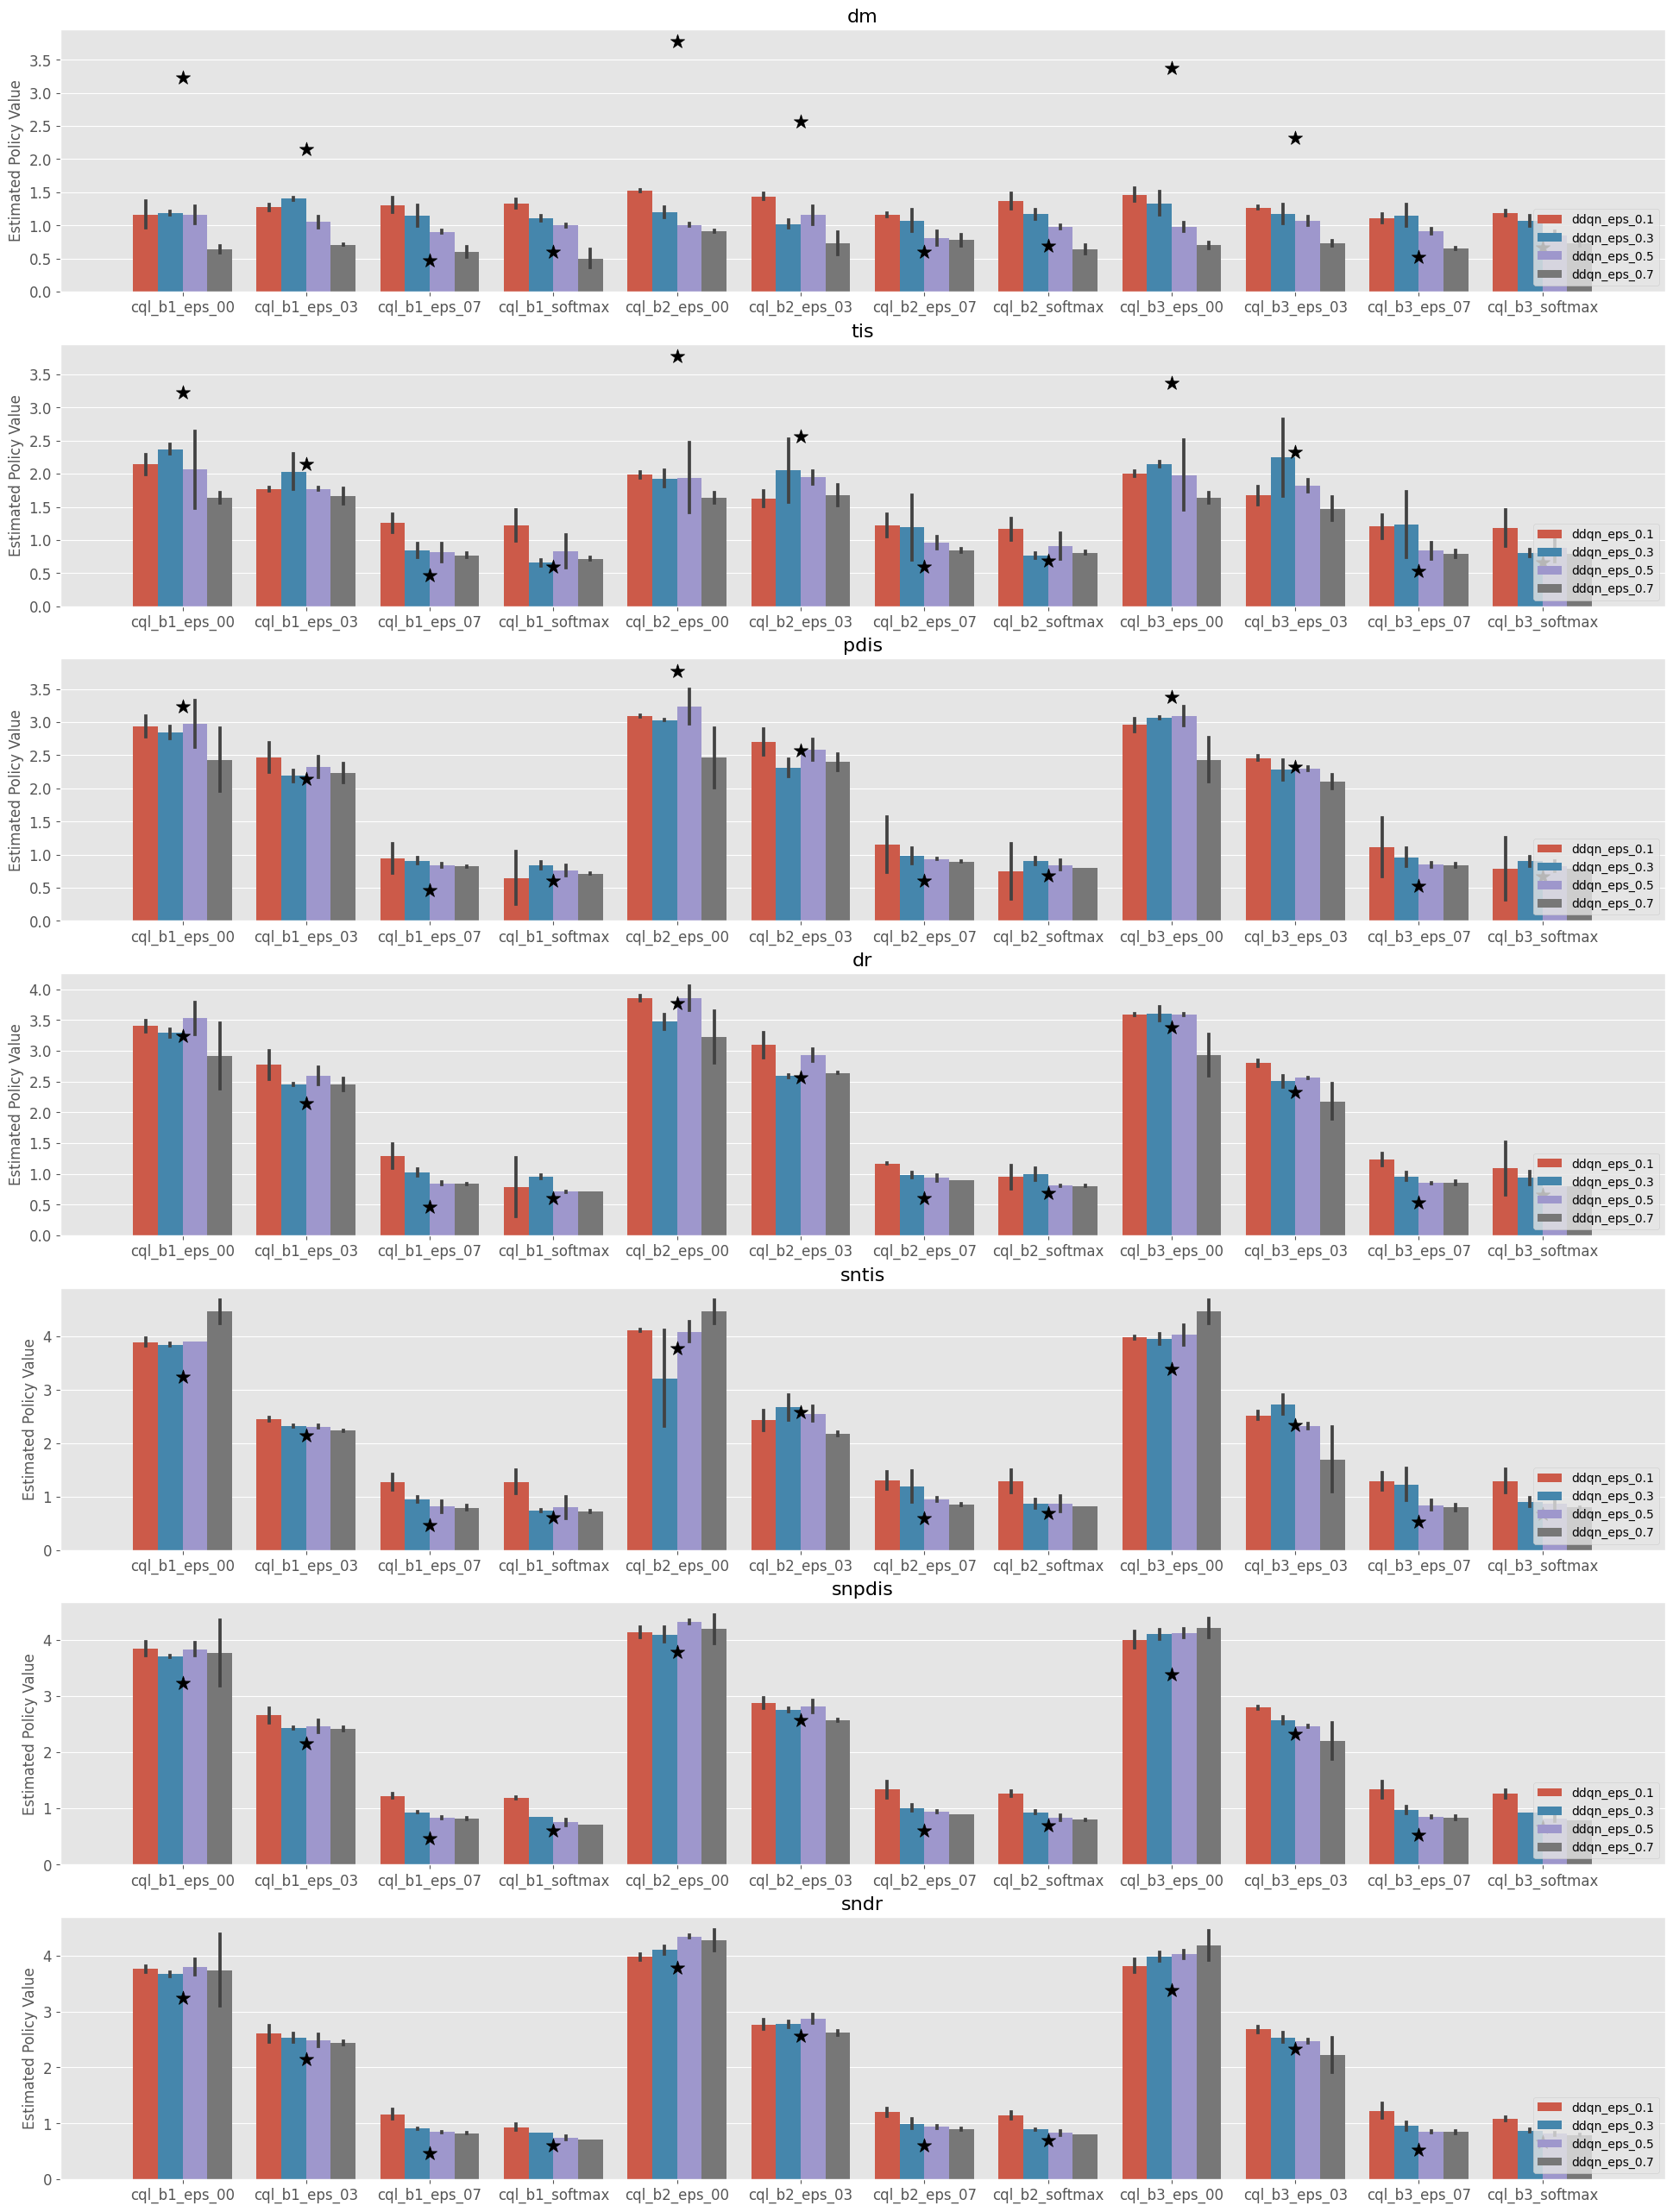

In [37]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

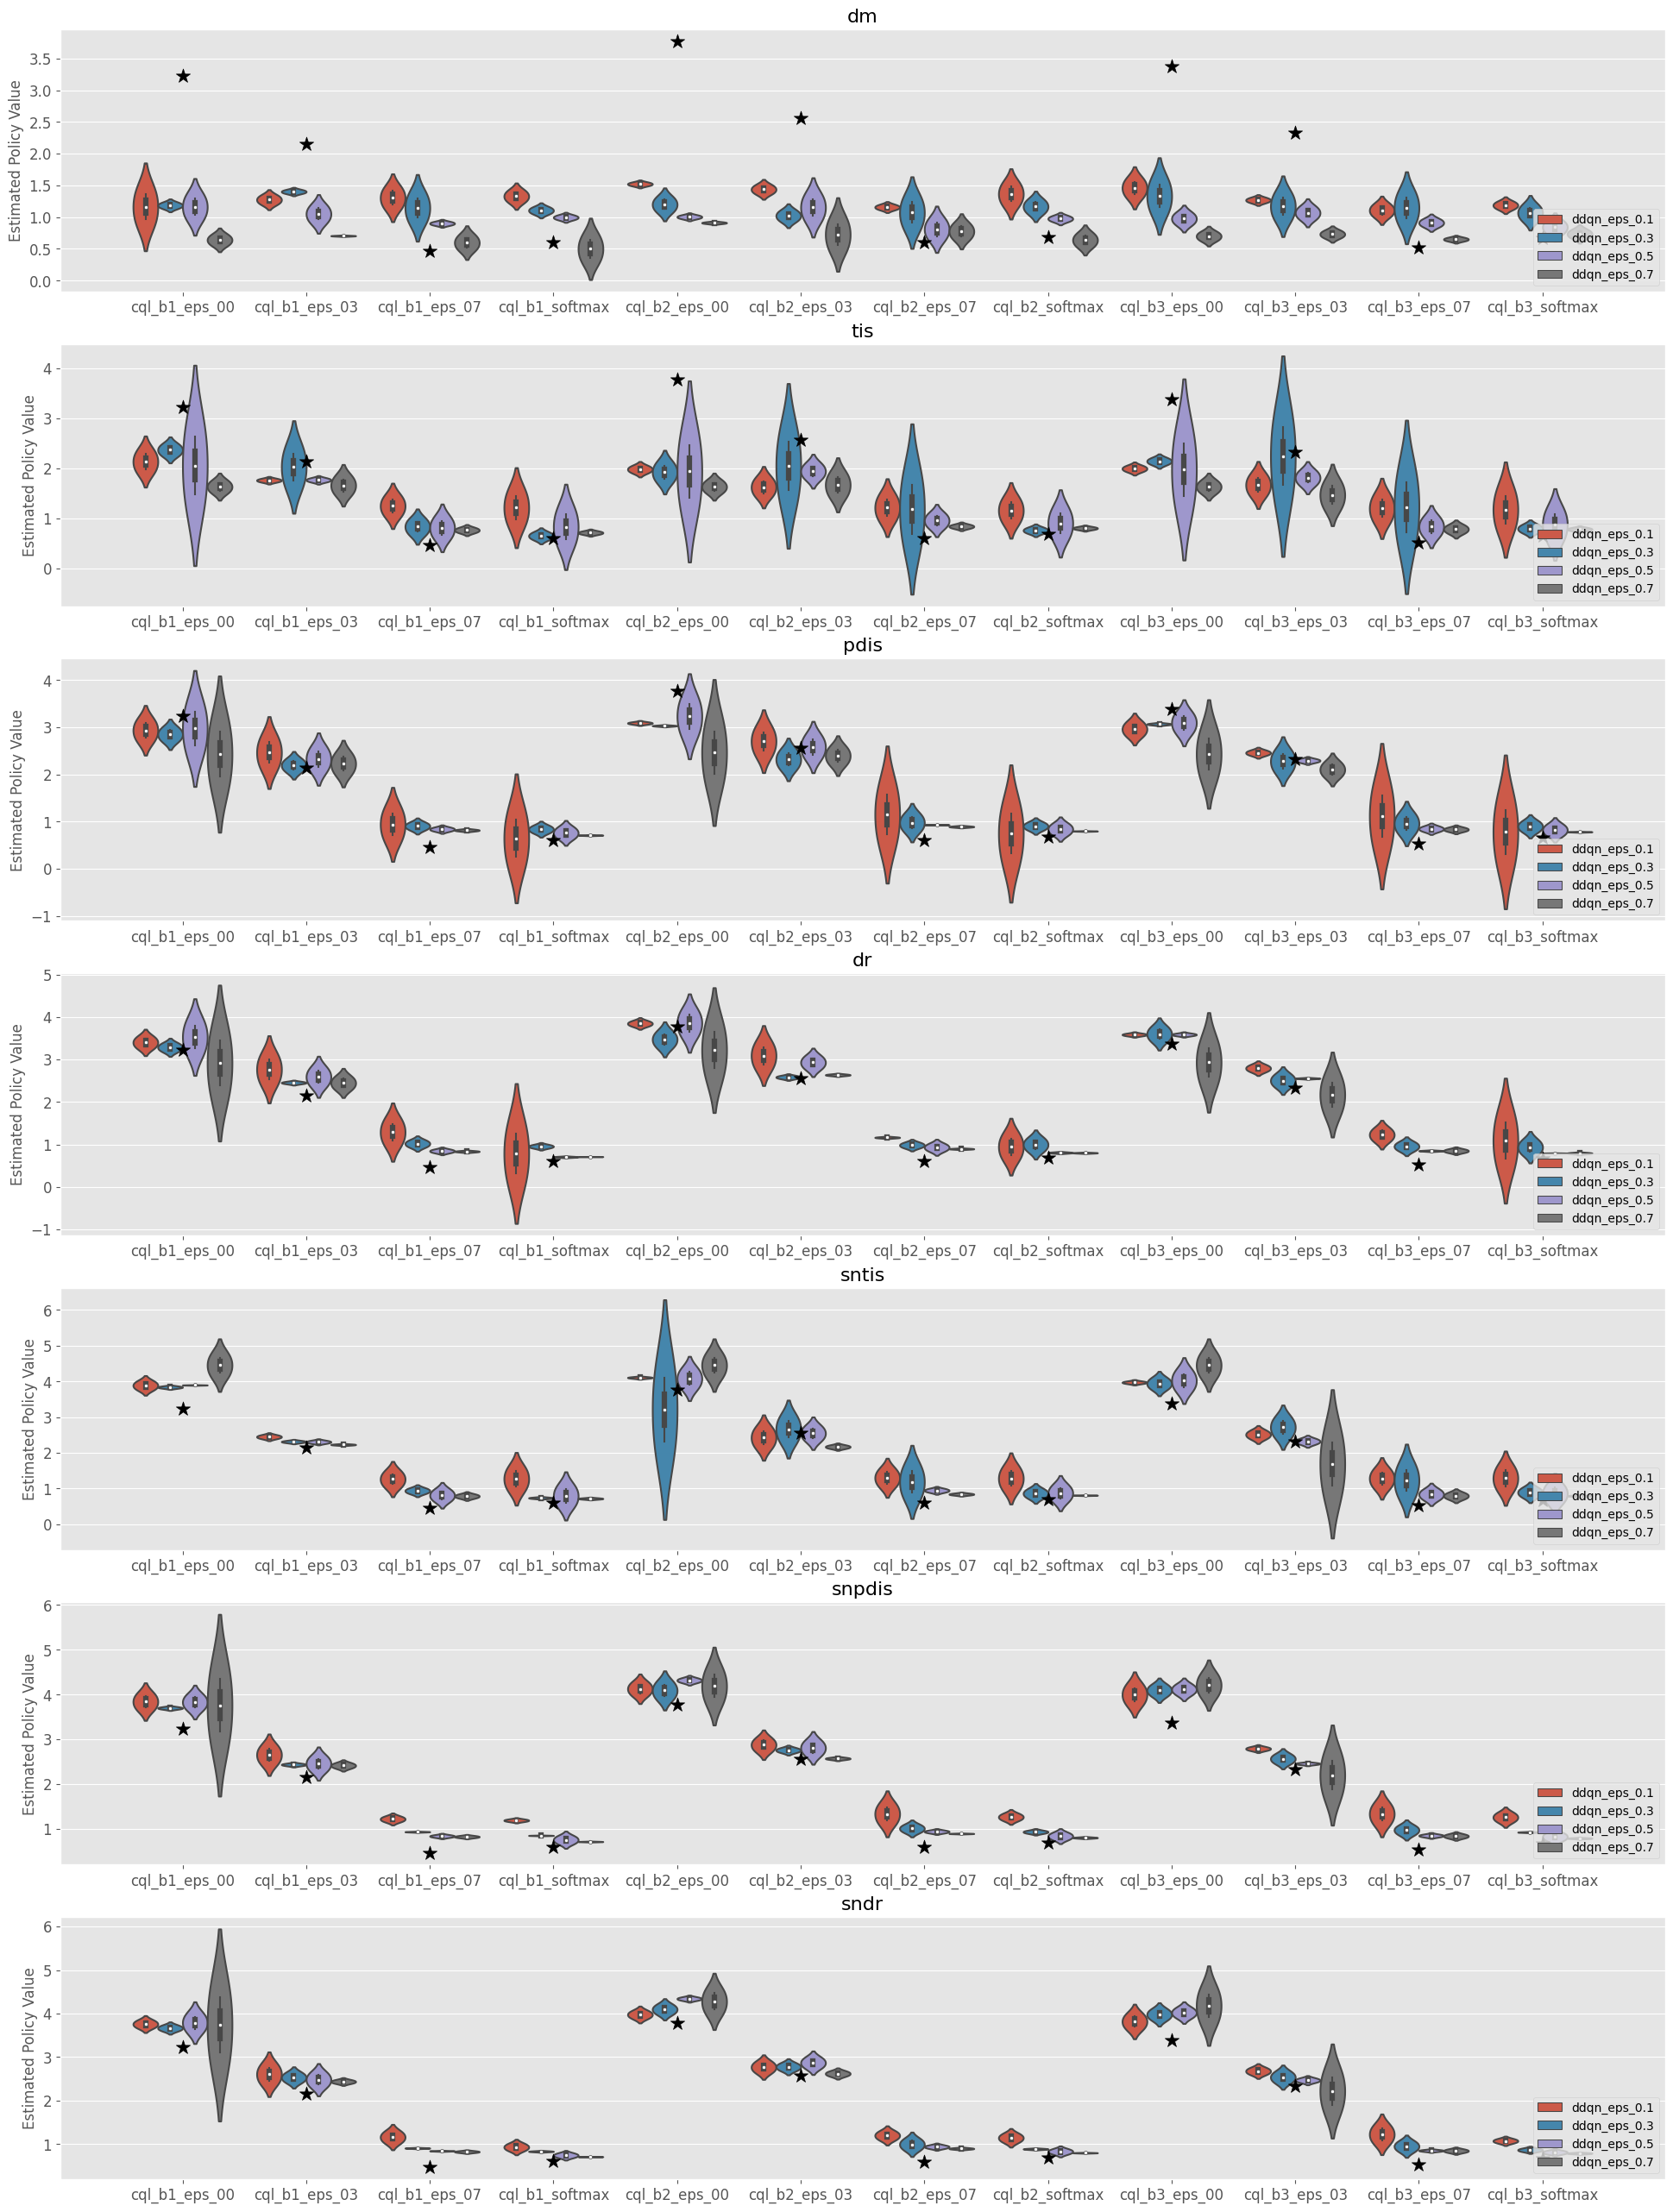

In [38]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
)

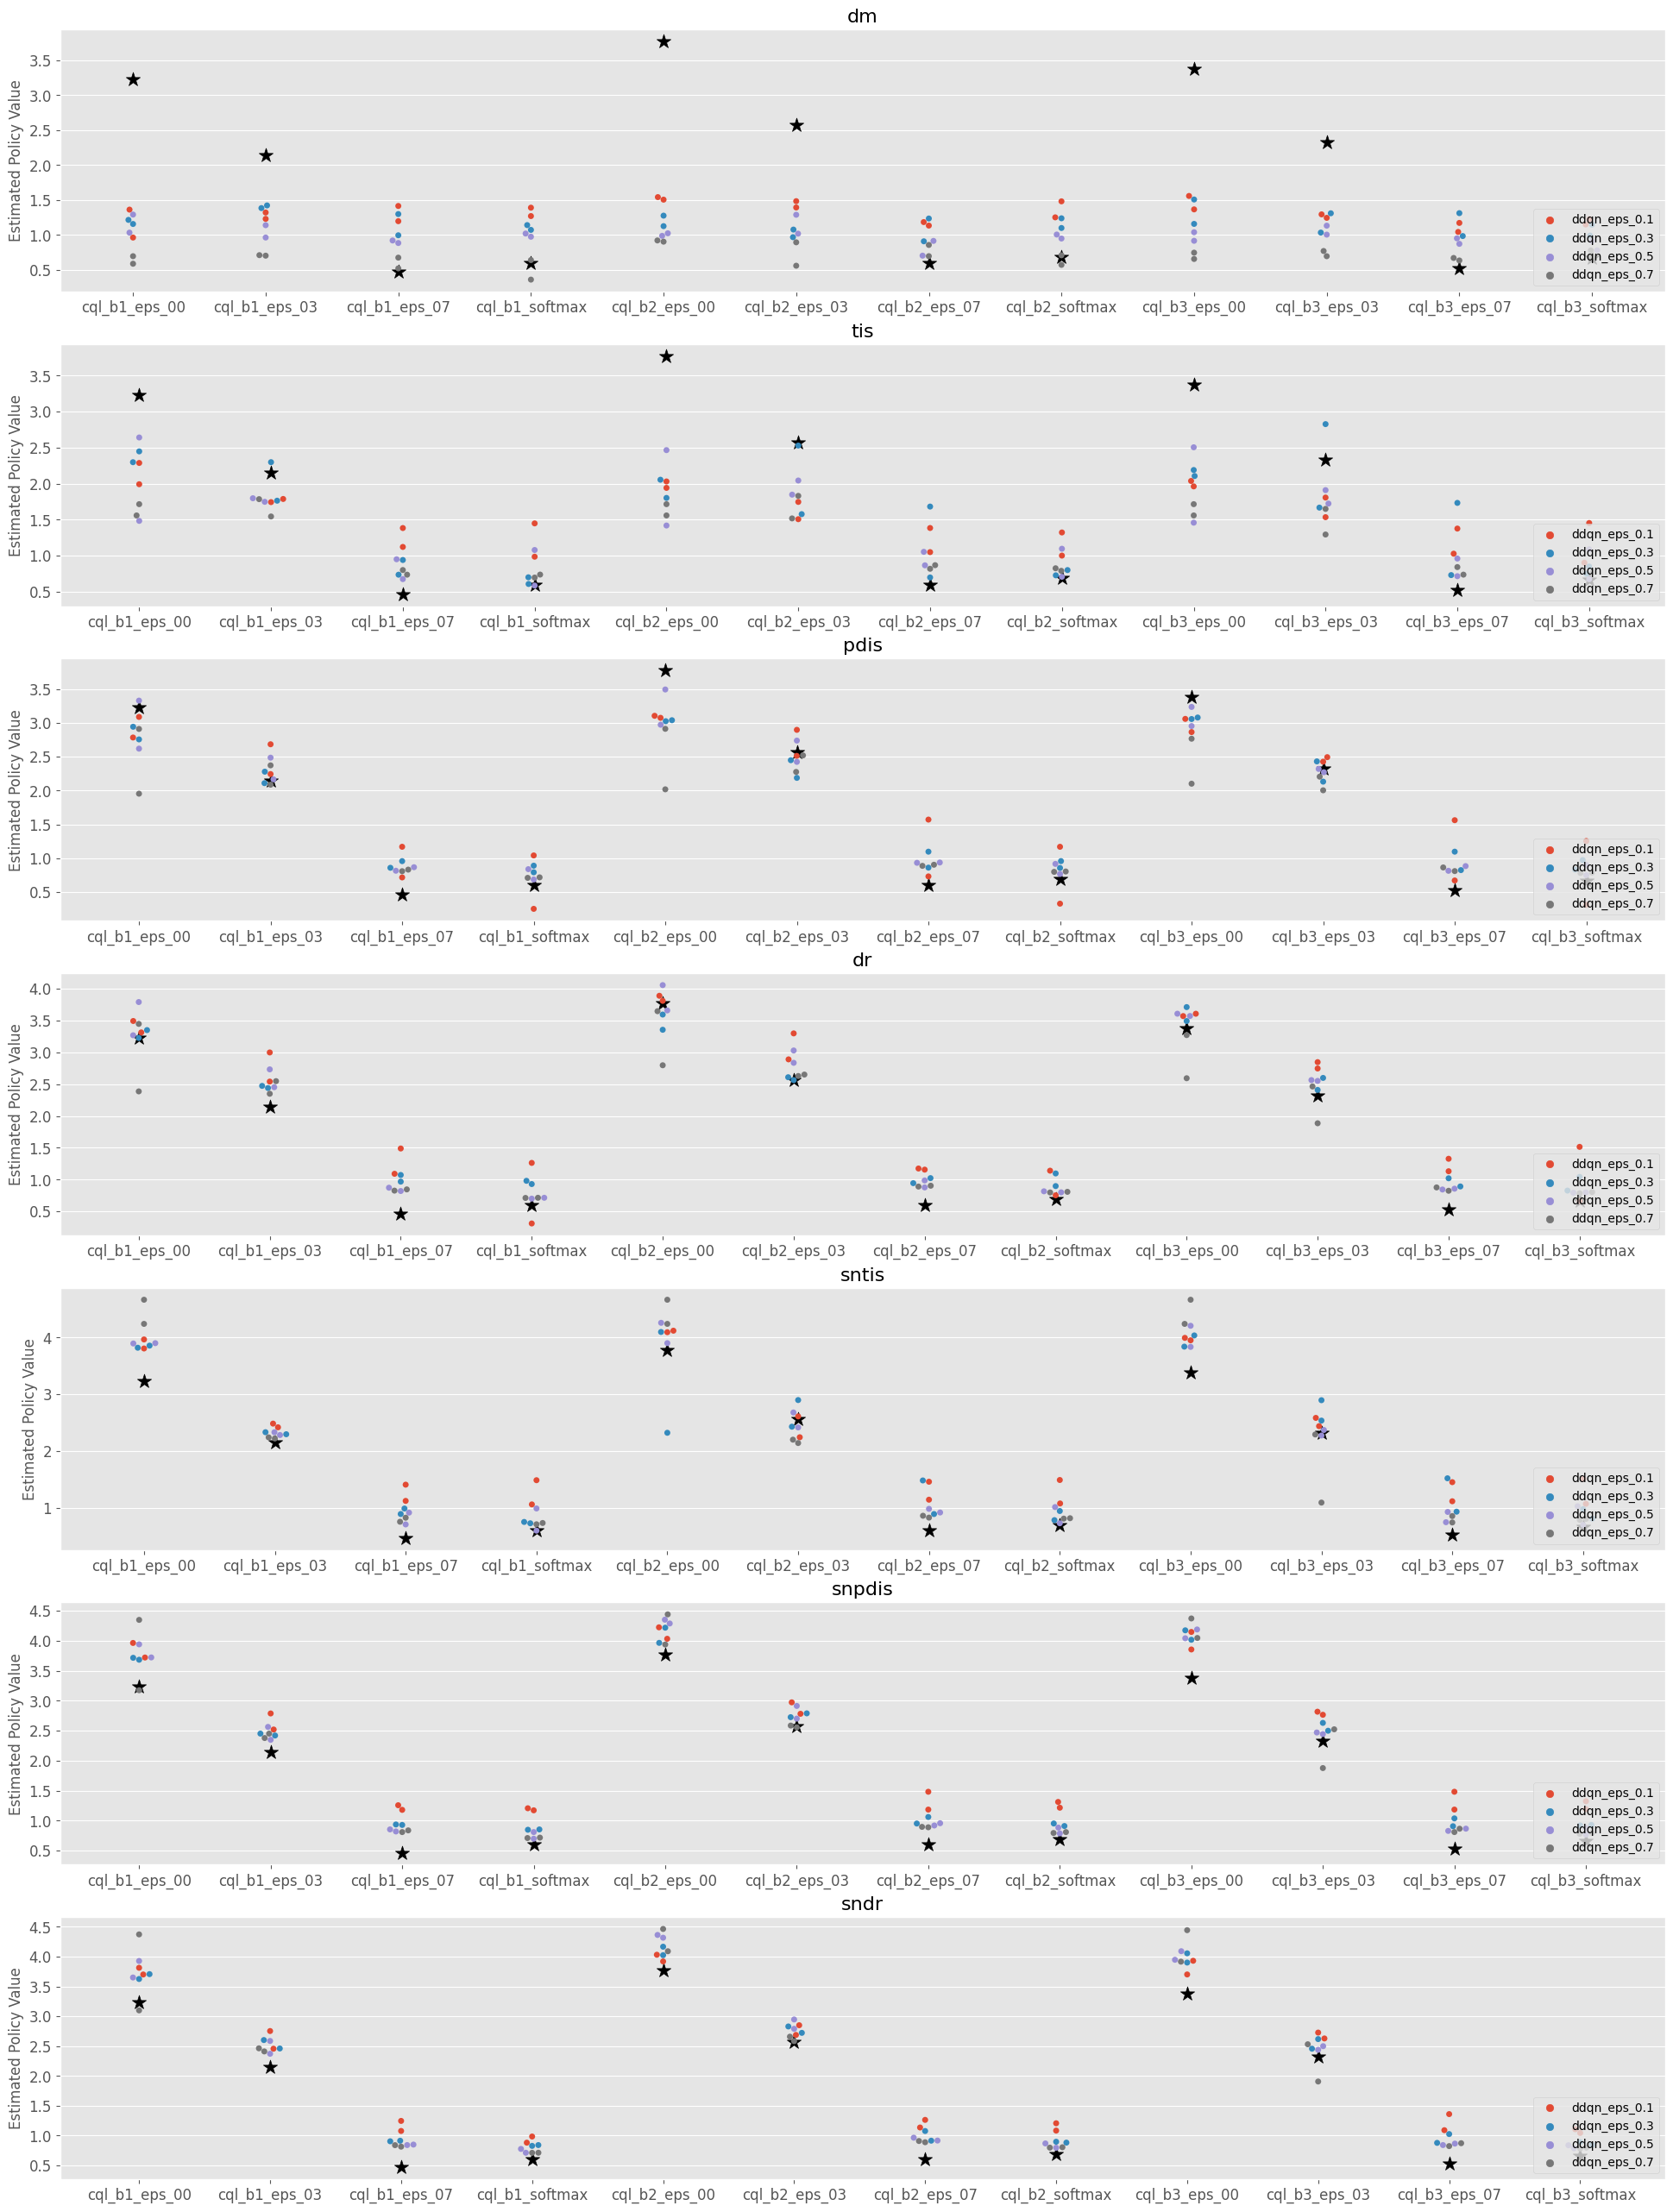

In [39]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="scatter",
    hue="policy",
)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [40]:
from ofrl.ope import CumulativeDistributionOffPolicyEvaluation as CumulativeDistributionOPE
from ofrl.ope import DiscreteCumulativeDistributionDirectMethod as CD_DM
from ofrl.ope import DiscreteCumulativeDistributionTrajectoryWiseImportanceSampling as CD_IS
from ofrl.ope import DiscreteCumulativeDistributionTrajectoryWiseDoublyRobust as CD_DR
from ofrl.ope import DiscreteCumulativeDistributionSelfNormalizedTrajectoryWiseImportanceSampling as CD_SNIS
from ofrl.ope import DiscreteCumulativeDistributionSelfNormalizedTrajectoryWiseDoublyRobust as CD_SNDR

In [41]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

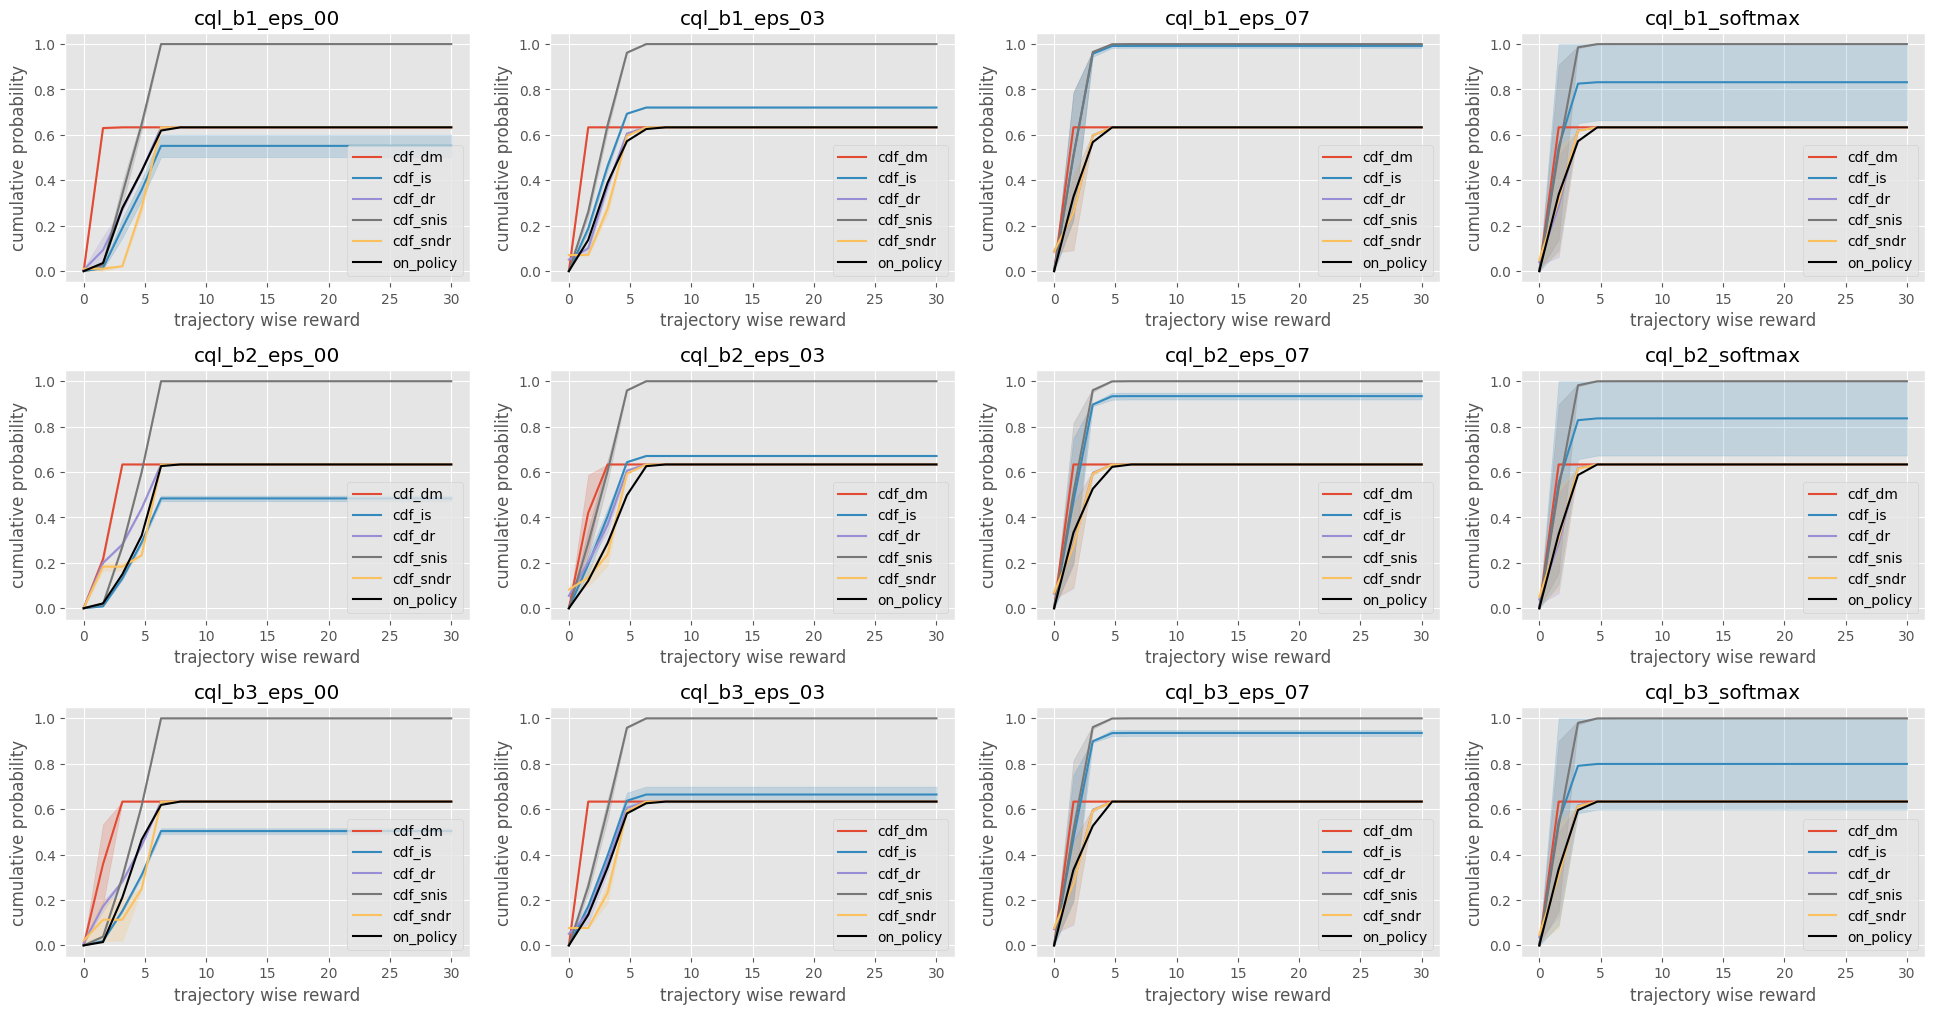

In [42]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="ddqn_eps_0.1",
    plot_type="ci_hue",
    scale_min=0.0, 
    scale_max=30.0, 
    n_partition=20, 
    n_cols=4,
)

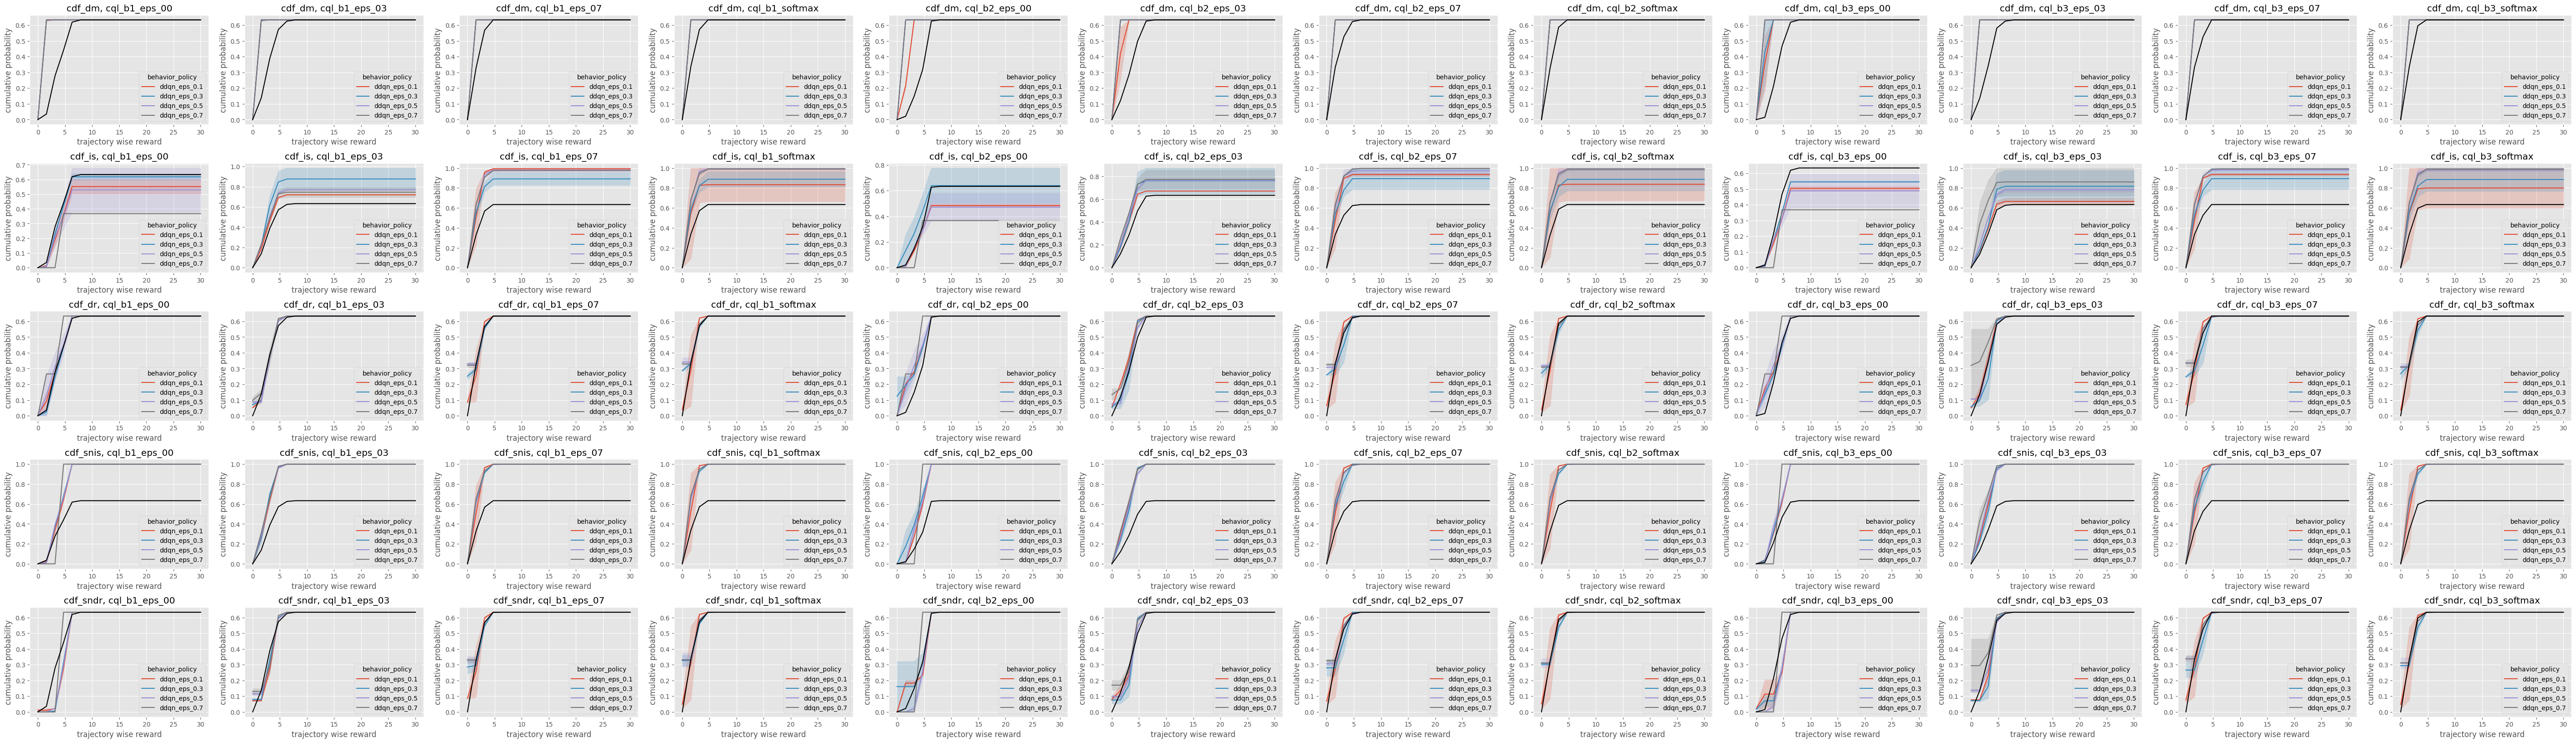

In [43]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict,
    plot_type="ci_behavior_policy",
    hue="policy",
    scale_min=0.0, 
    scale_max=30.0, 
    n_partition=20, 
)

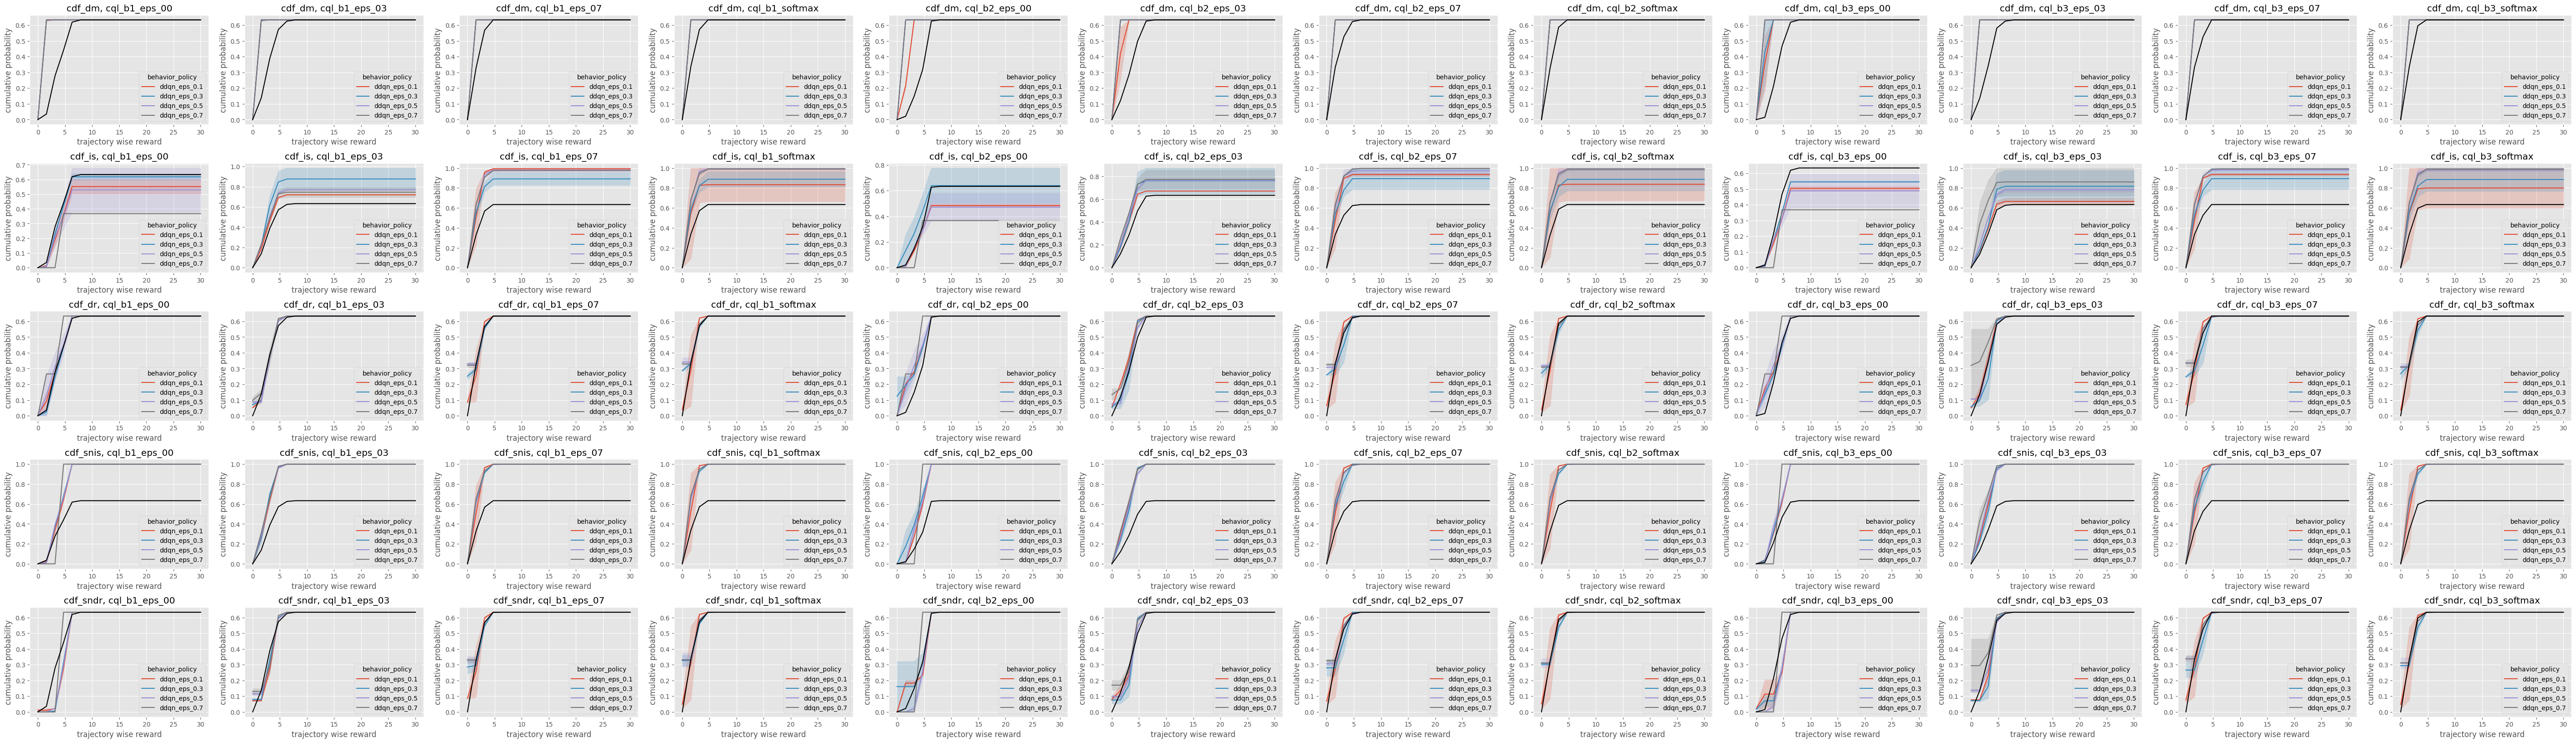

In [44]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict,
    plot_type="ci_behavior_policy",
    hue="policy",
    scale_min=0.0, 
    scale_max=30.0, 
    n_partition=20, 
)

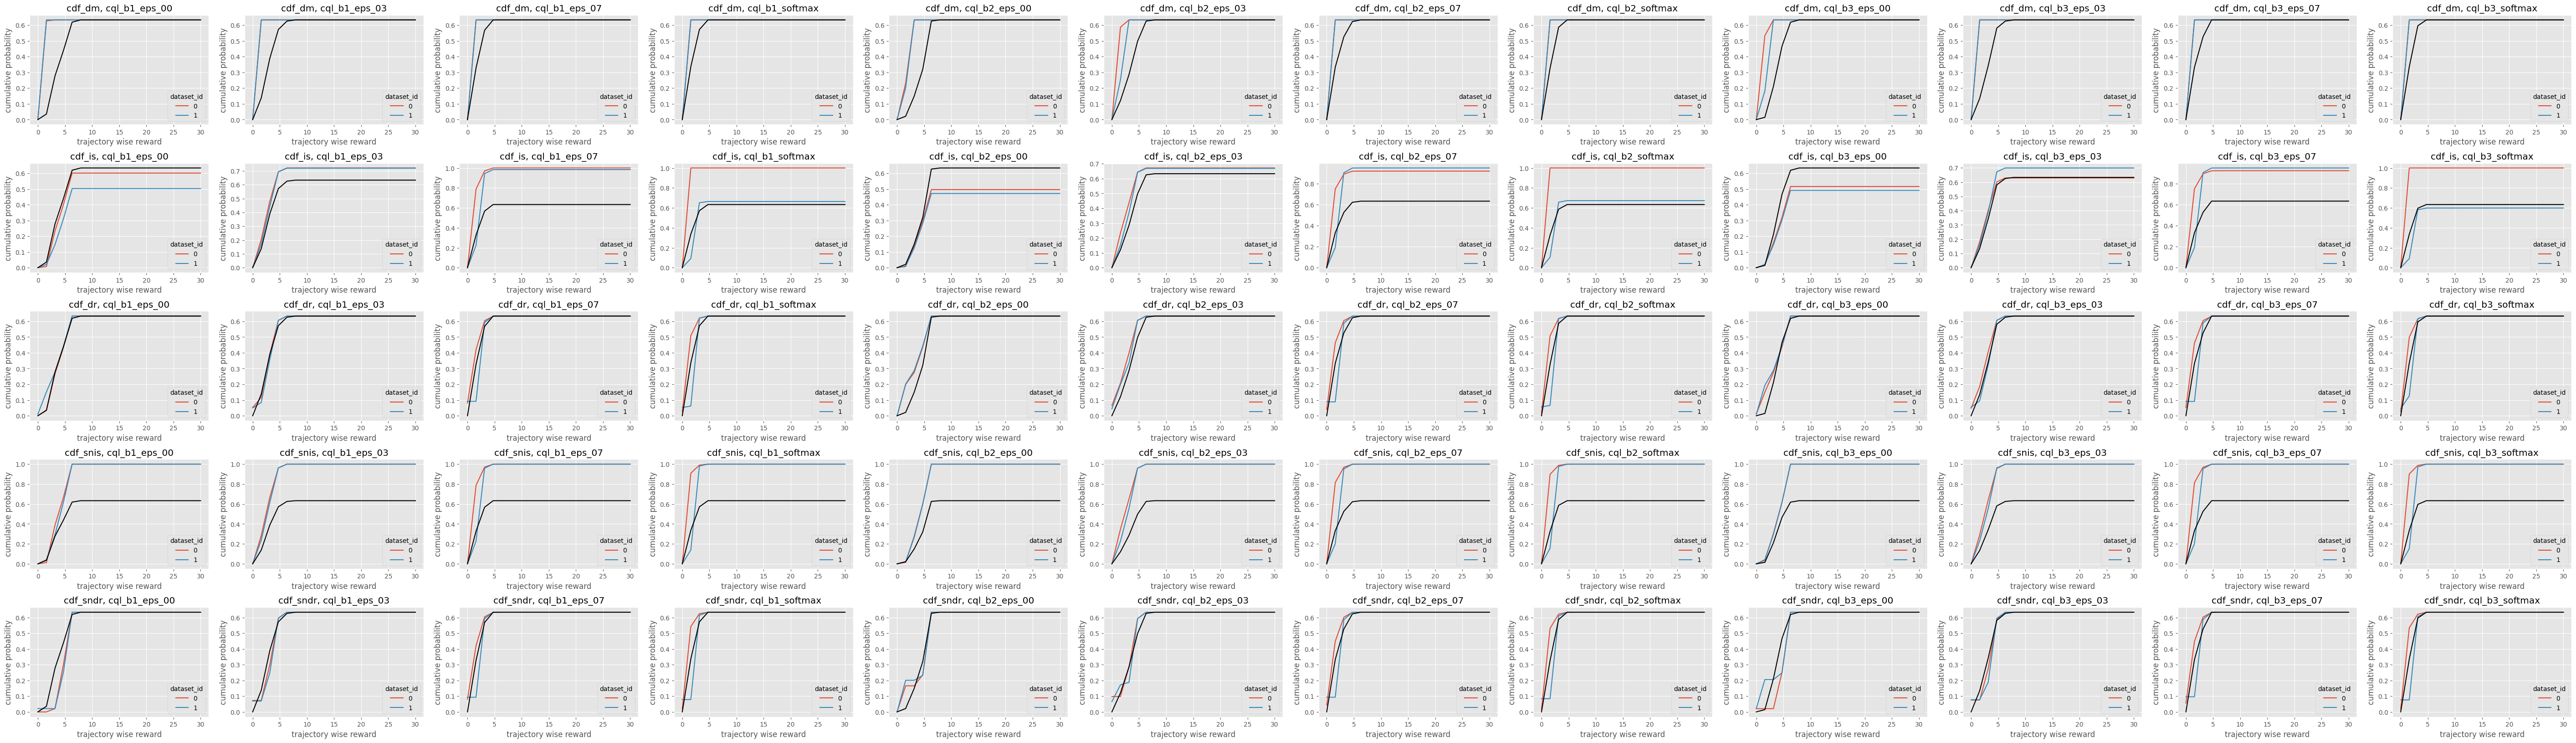

In [45]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="ddqn_eps_0.1",
    plot_type="enumerate",
    hue="policy",
    scale_min=0.0, 
    scale_max=30.0, 
    n_partition=20, 
)

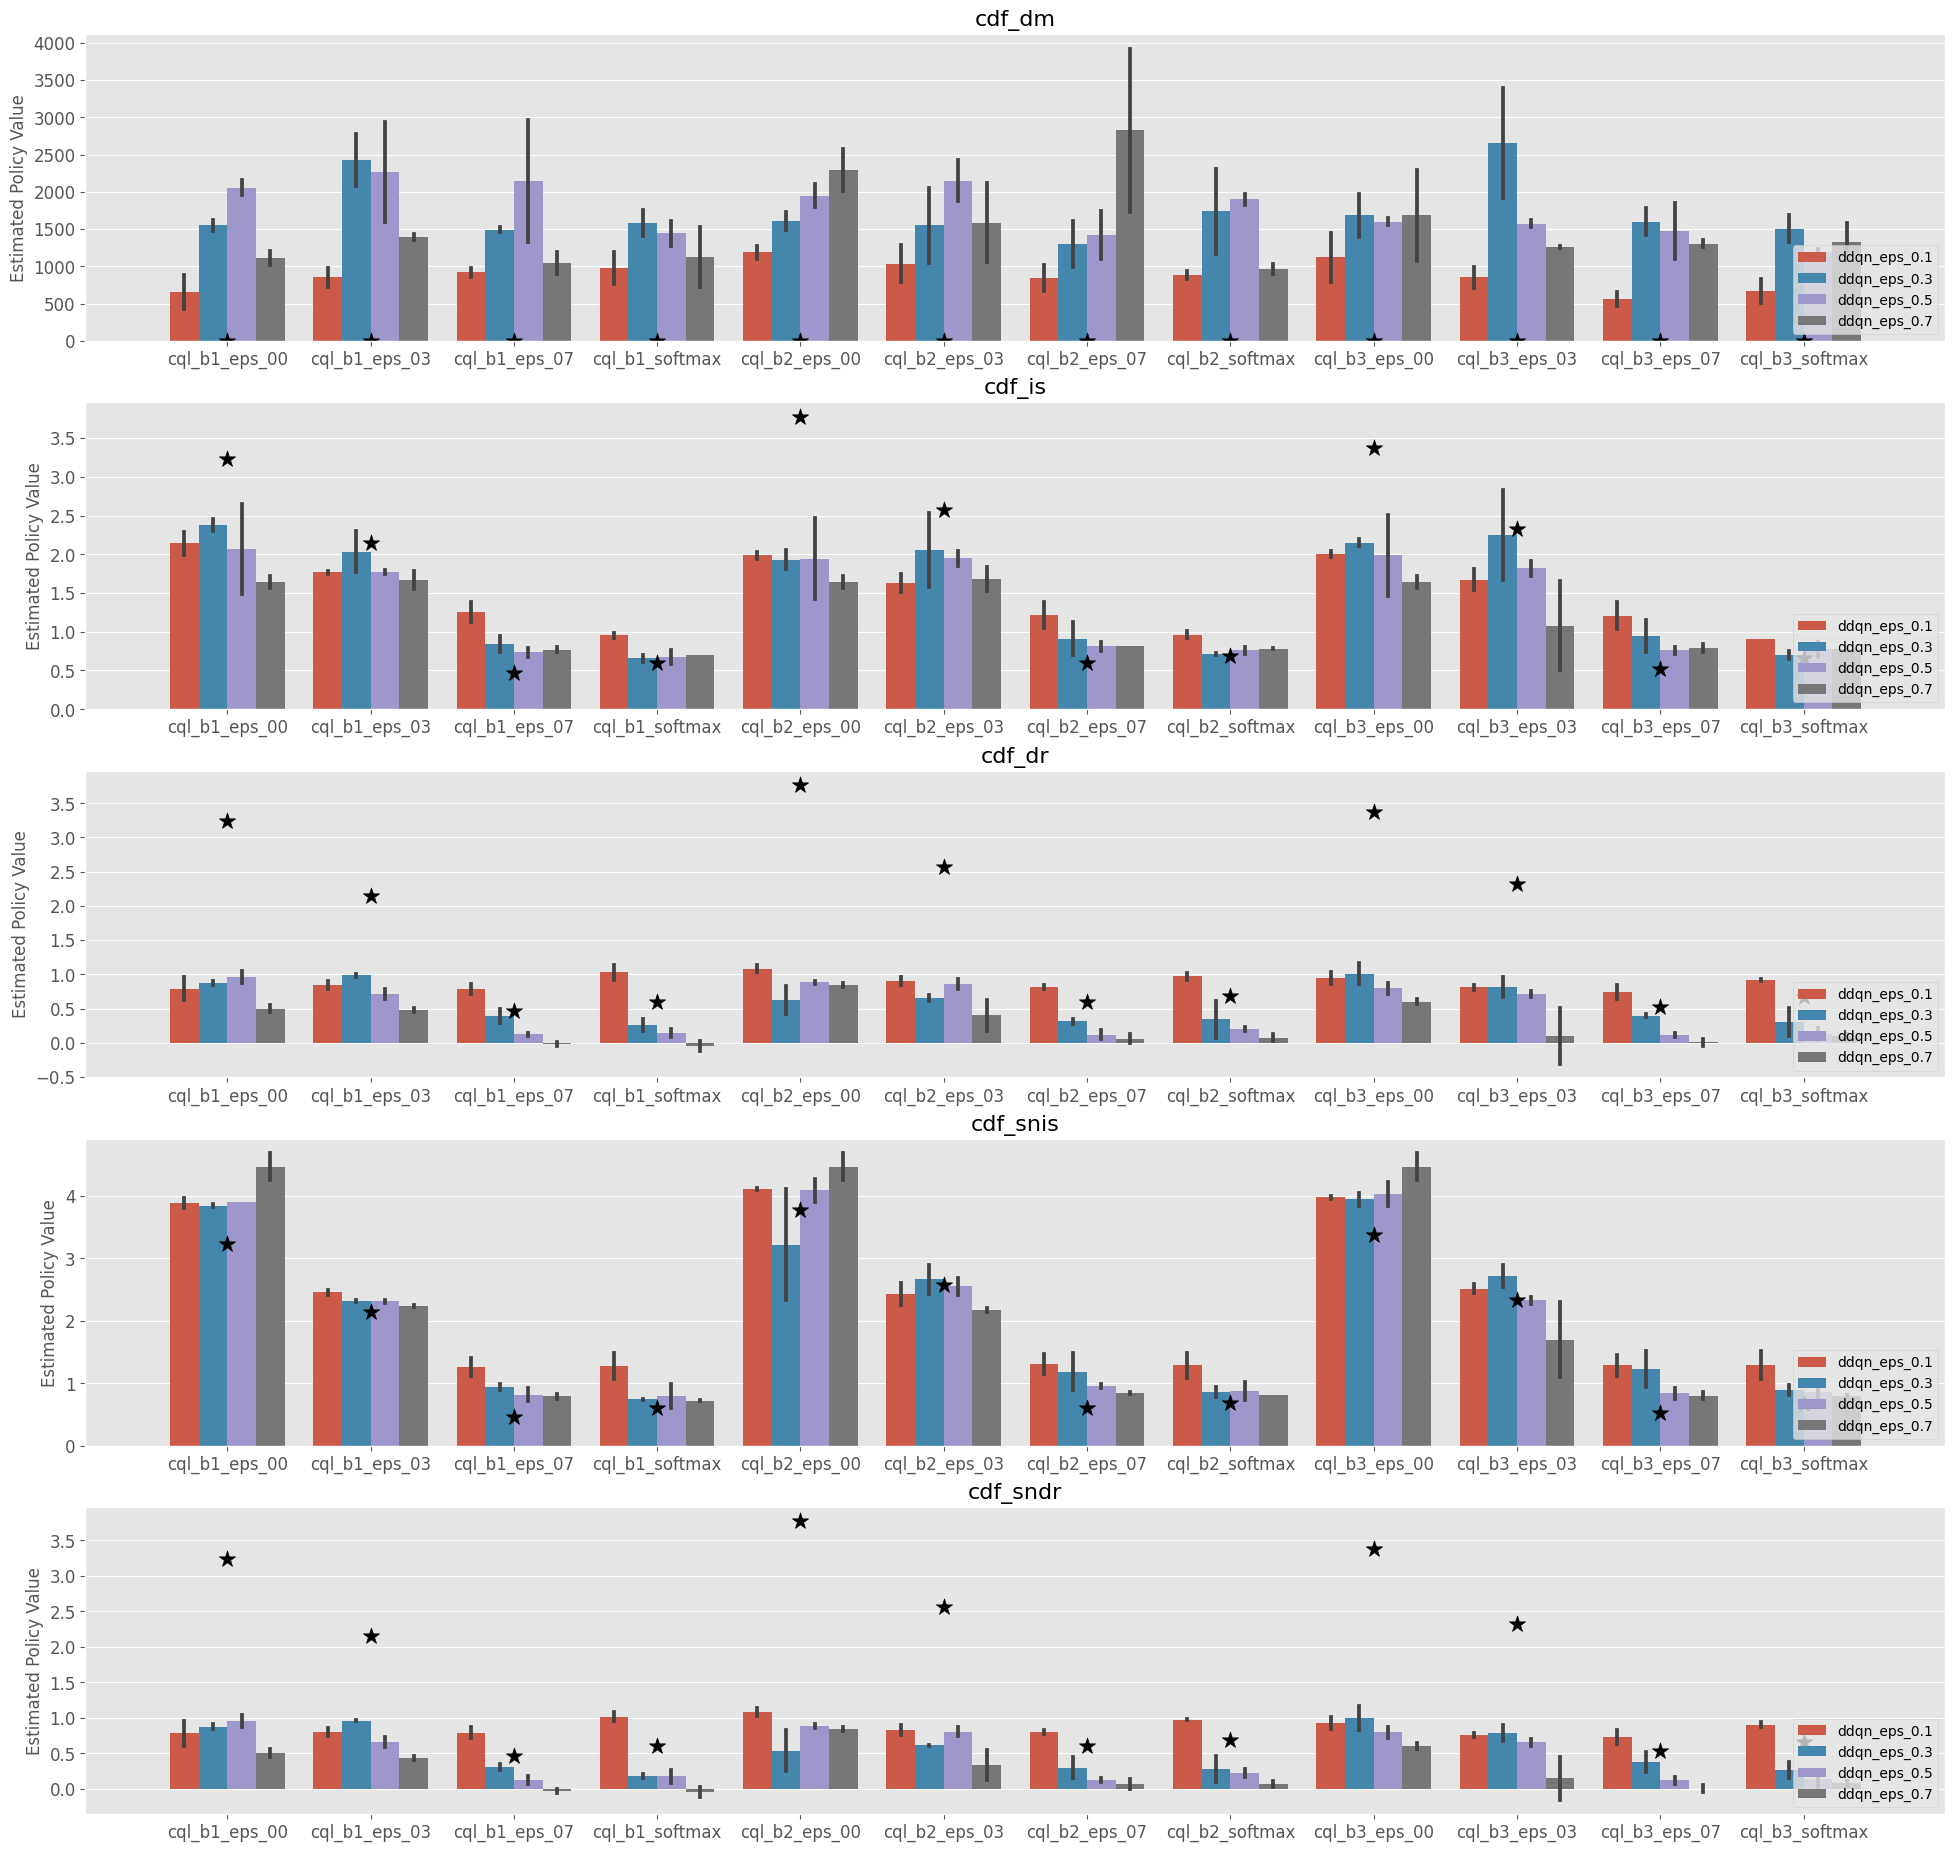

In [46]:
cd_ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

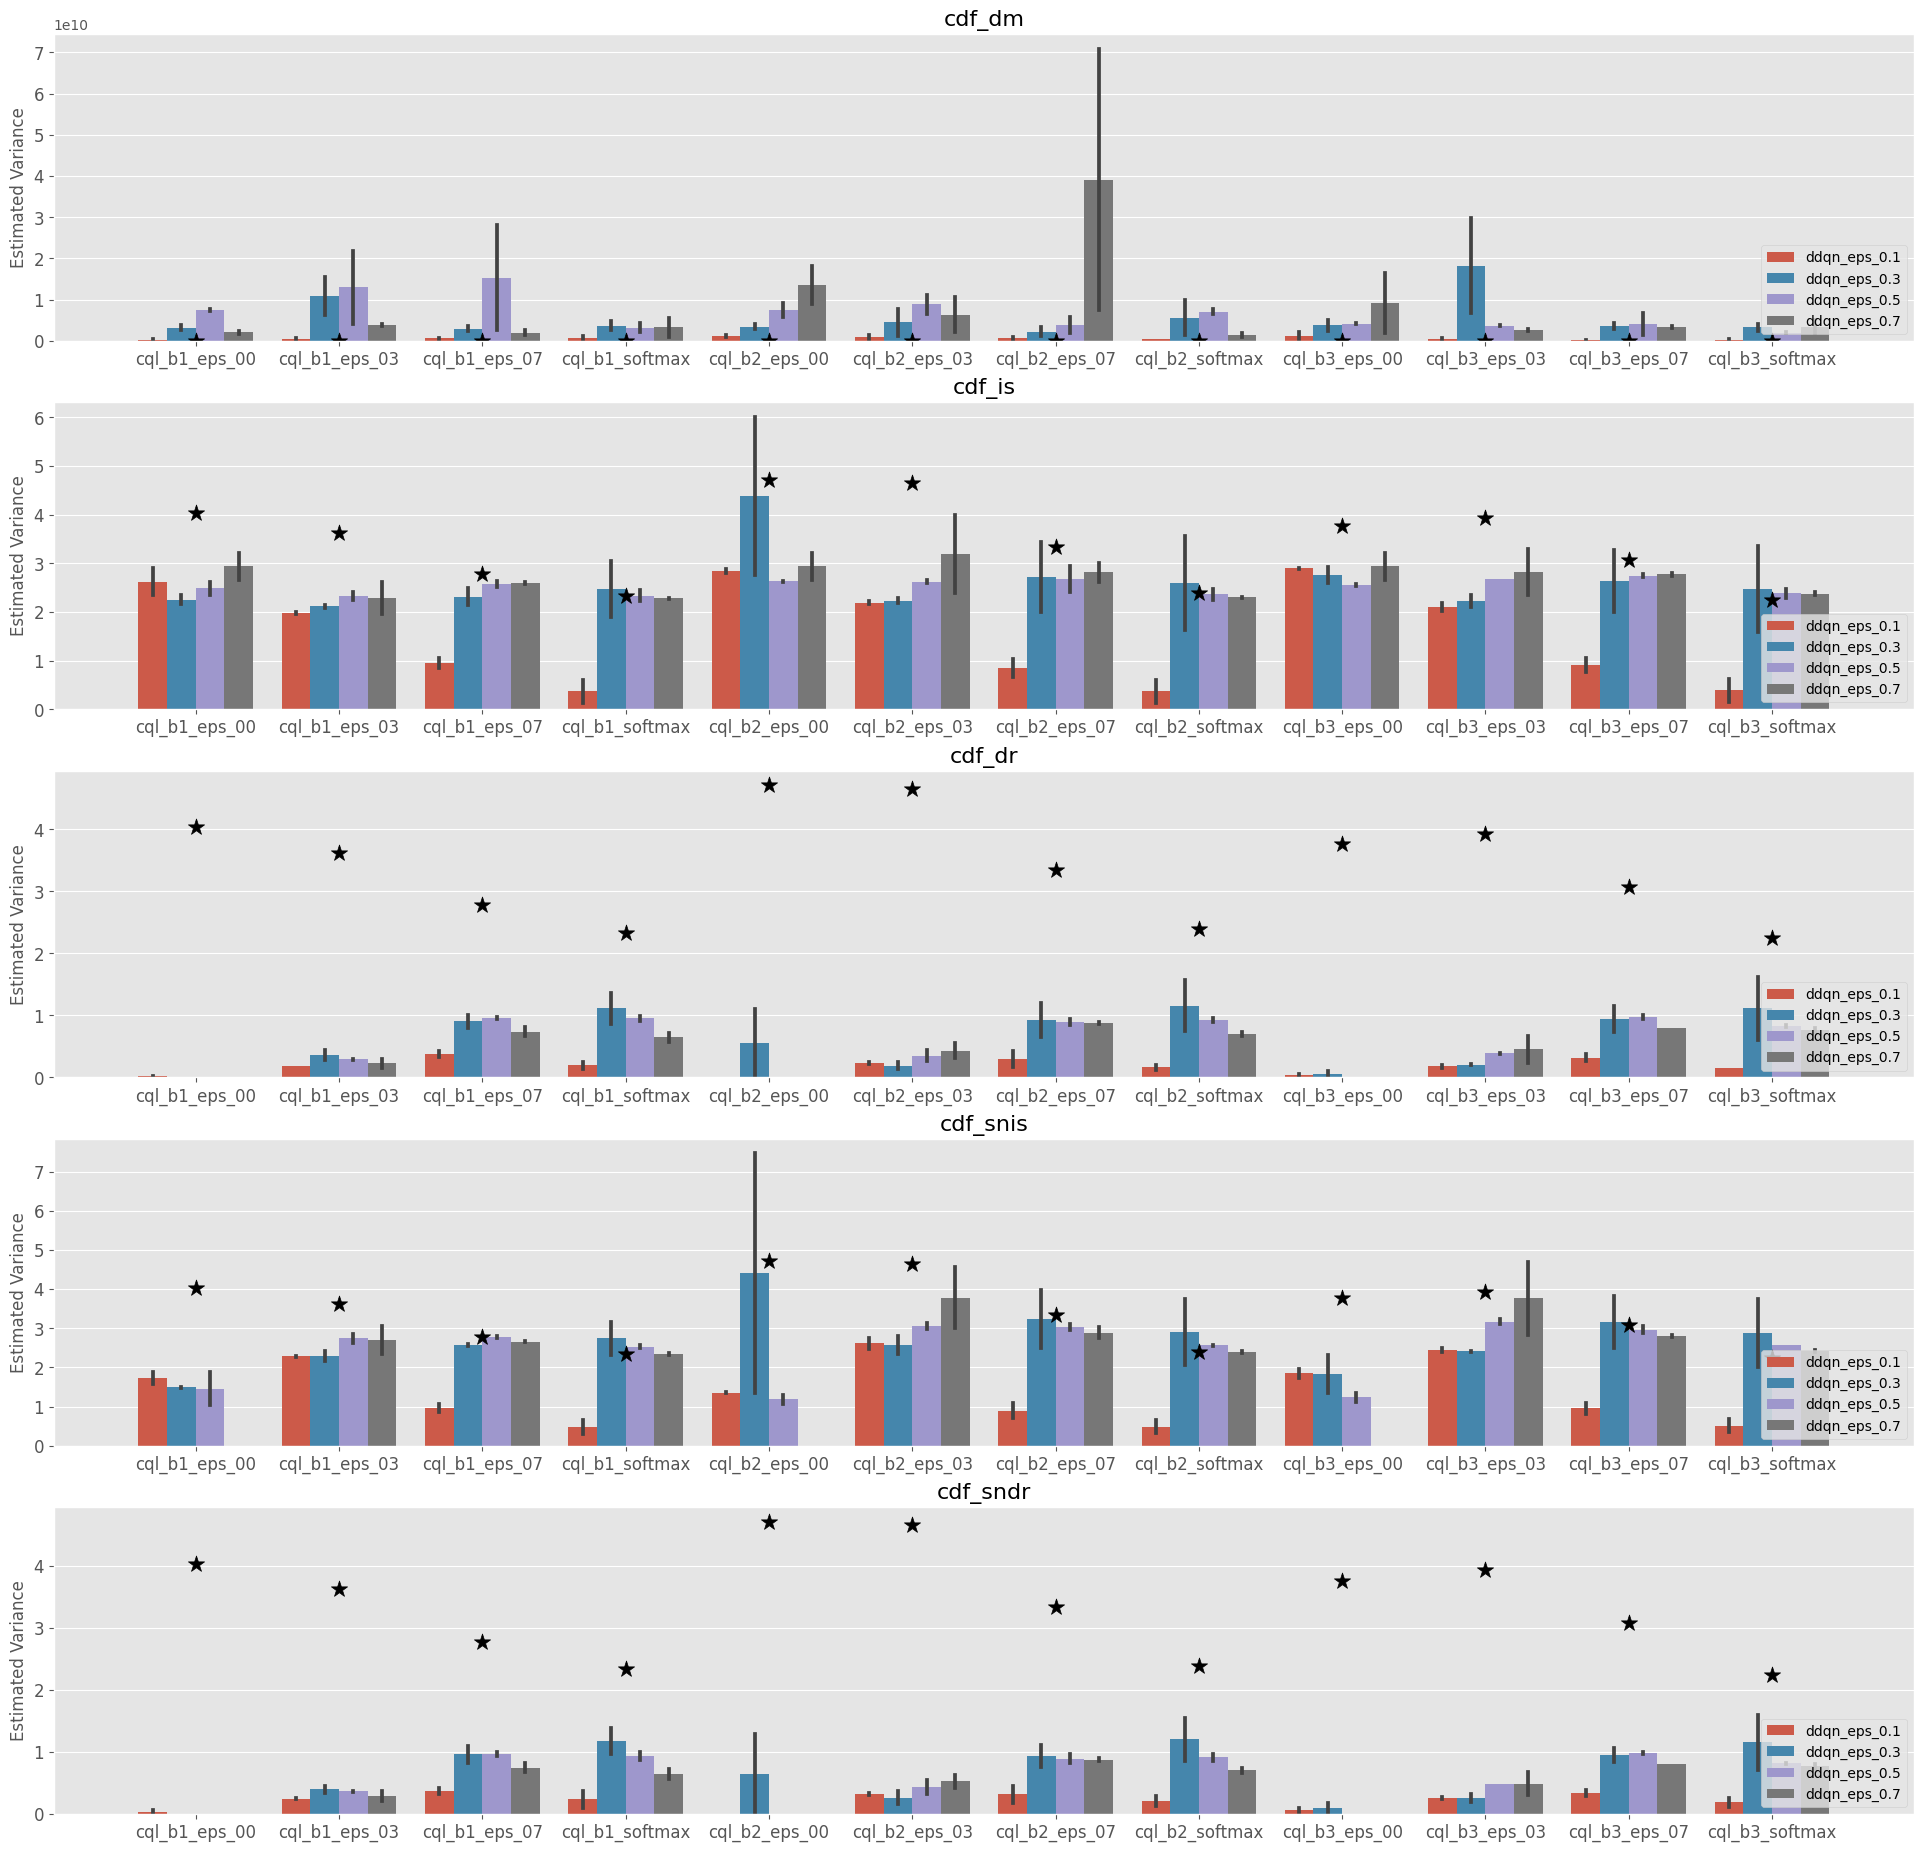

In [47]:
cd_ope.visualize_variance_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

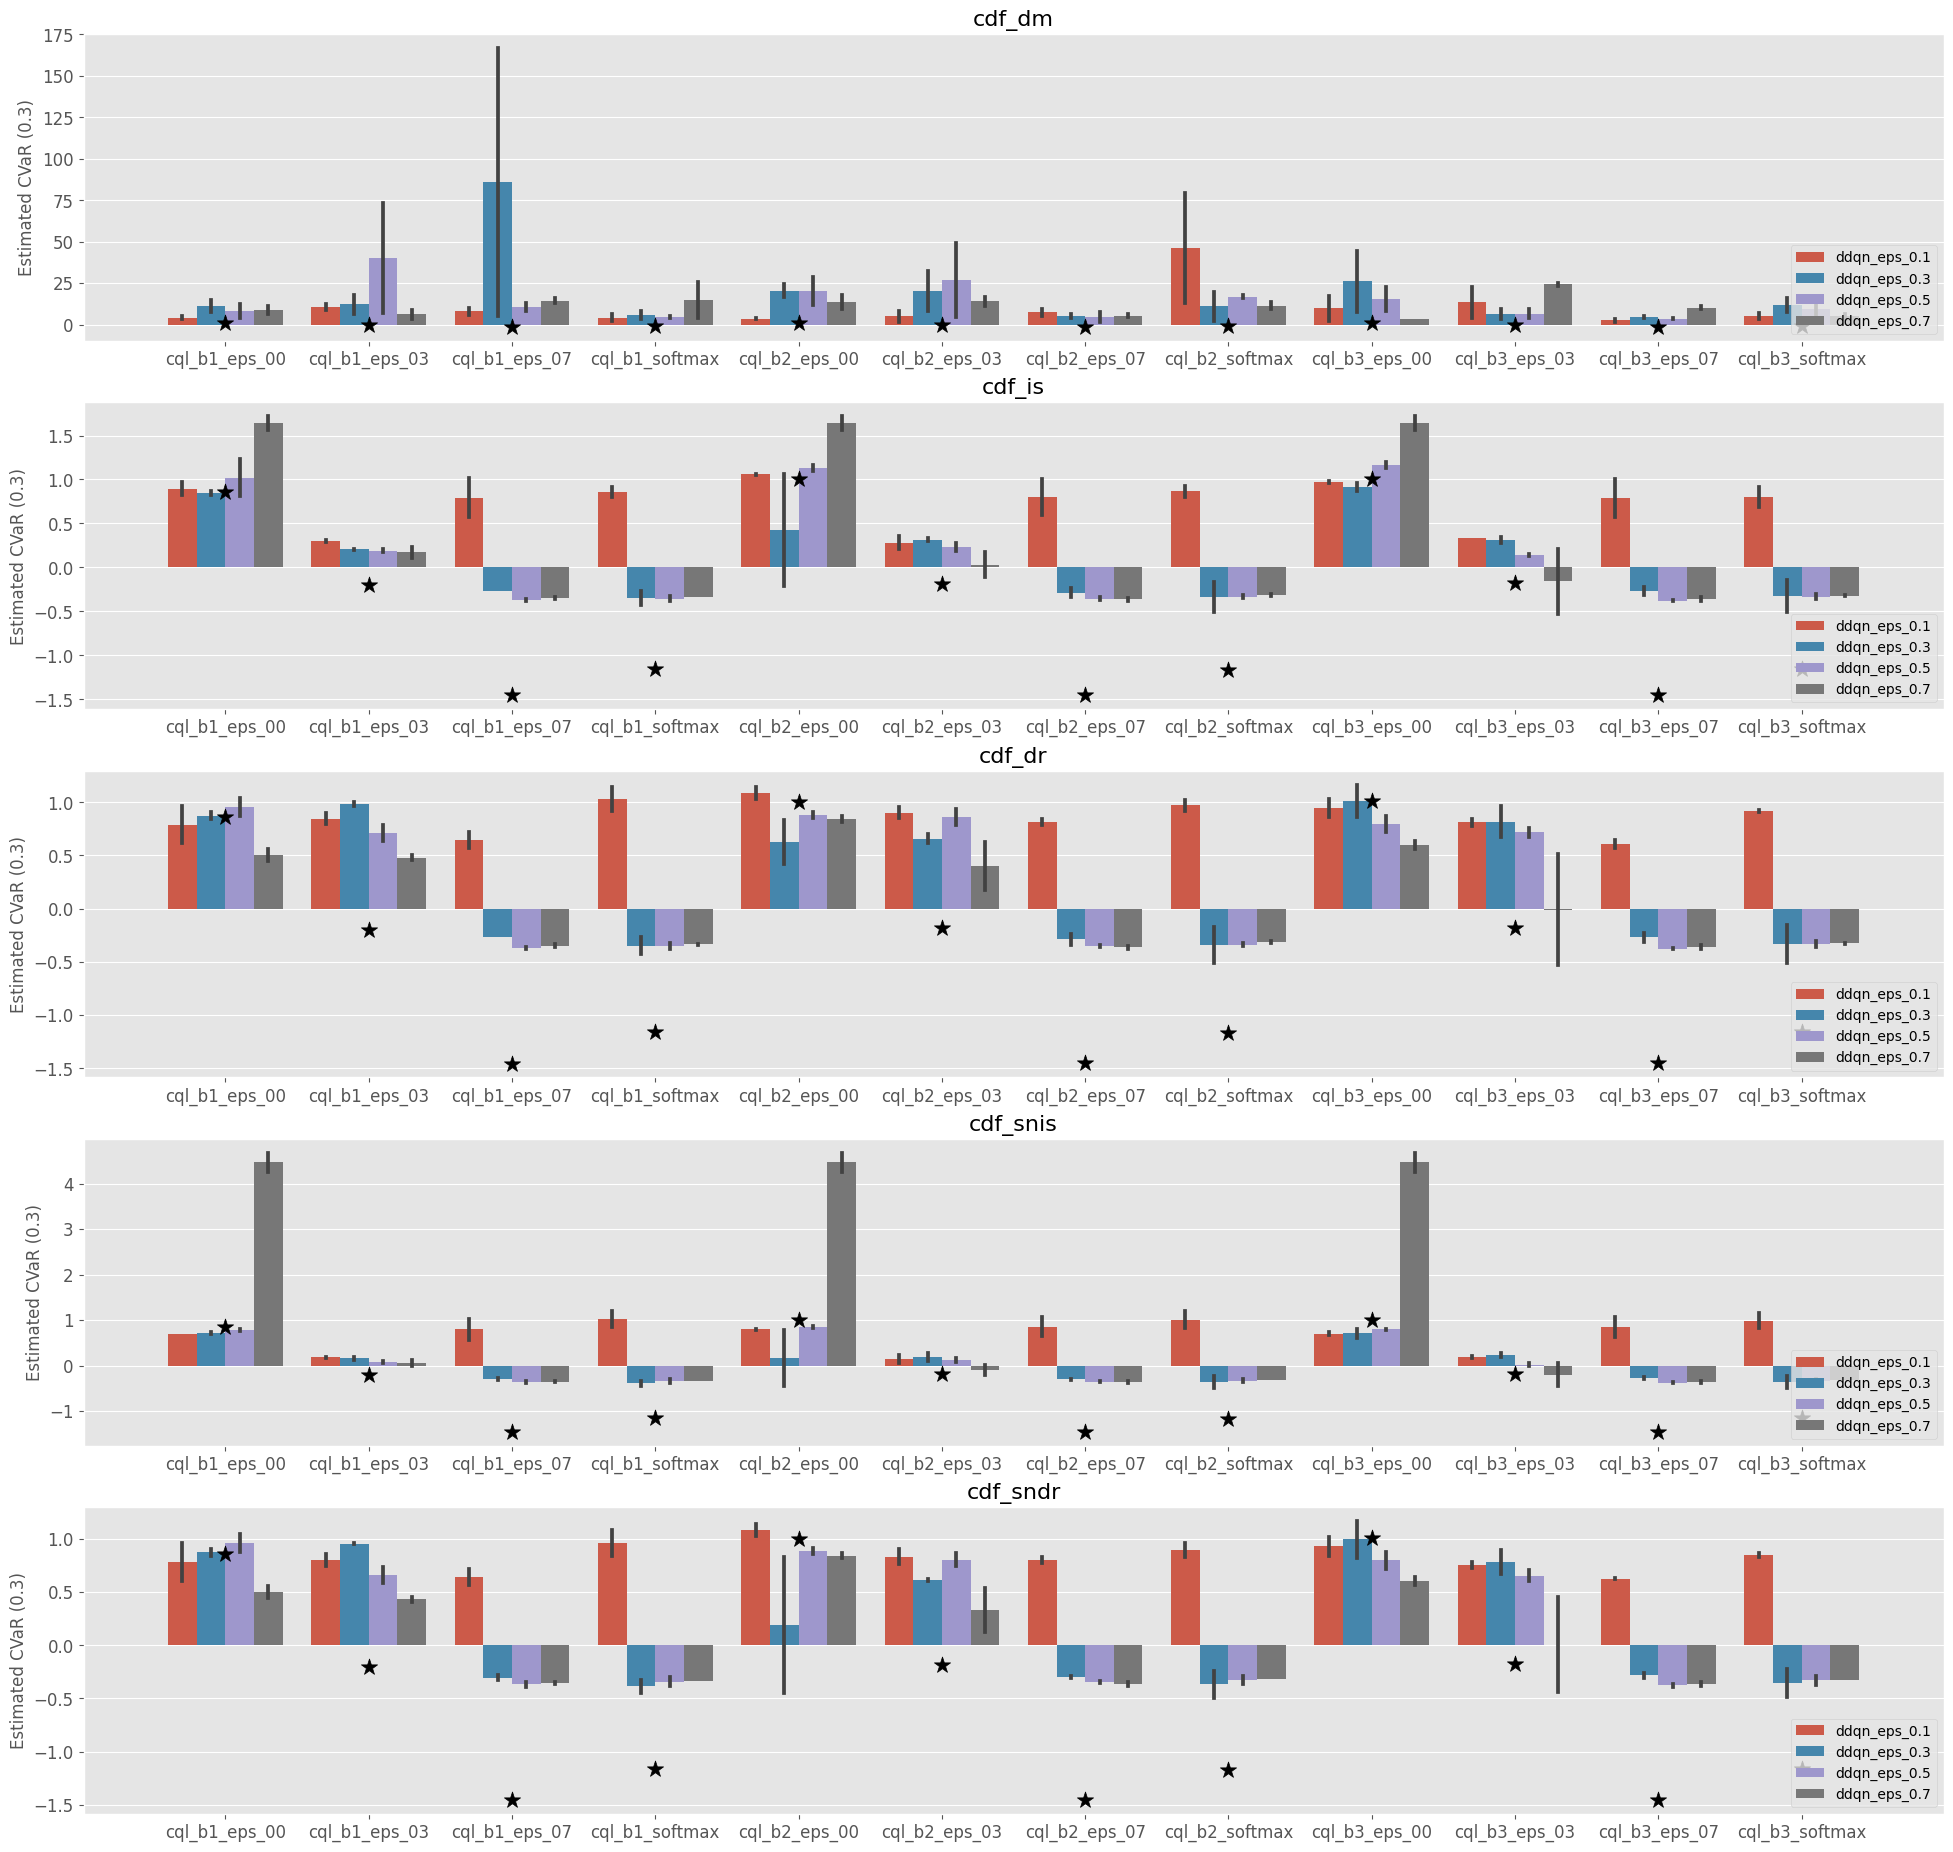

In [48]:
cd_ope.visualize_conditional_value_at_risk_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

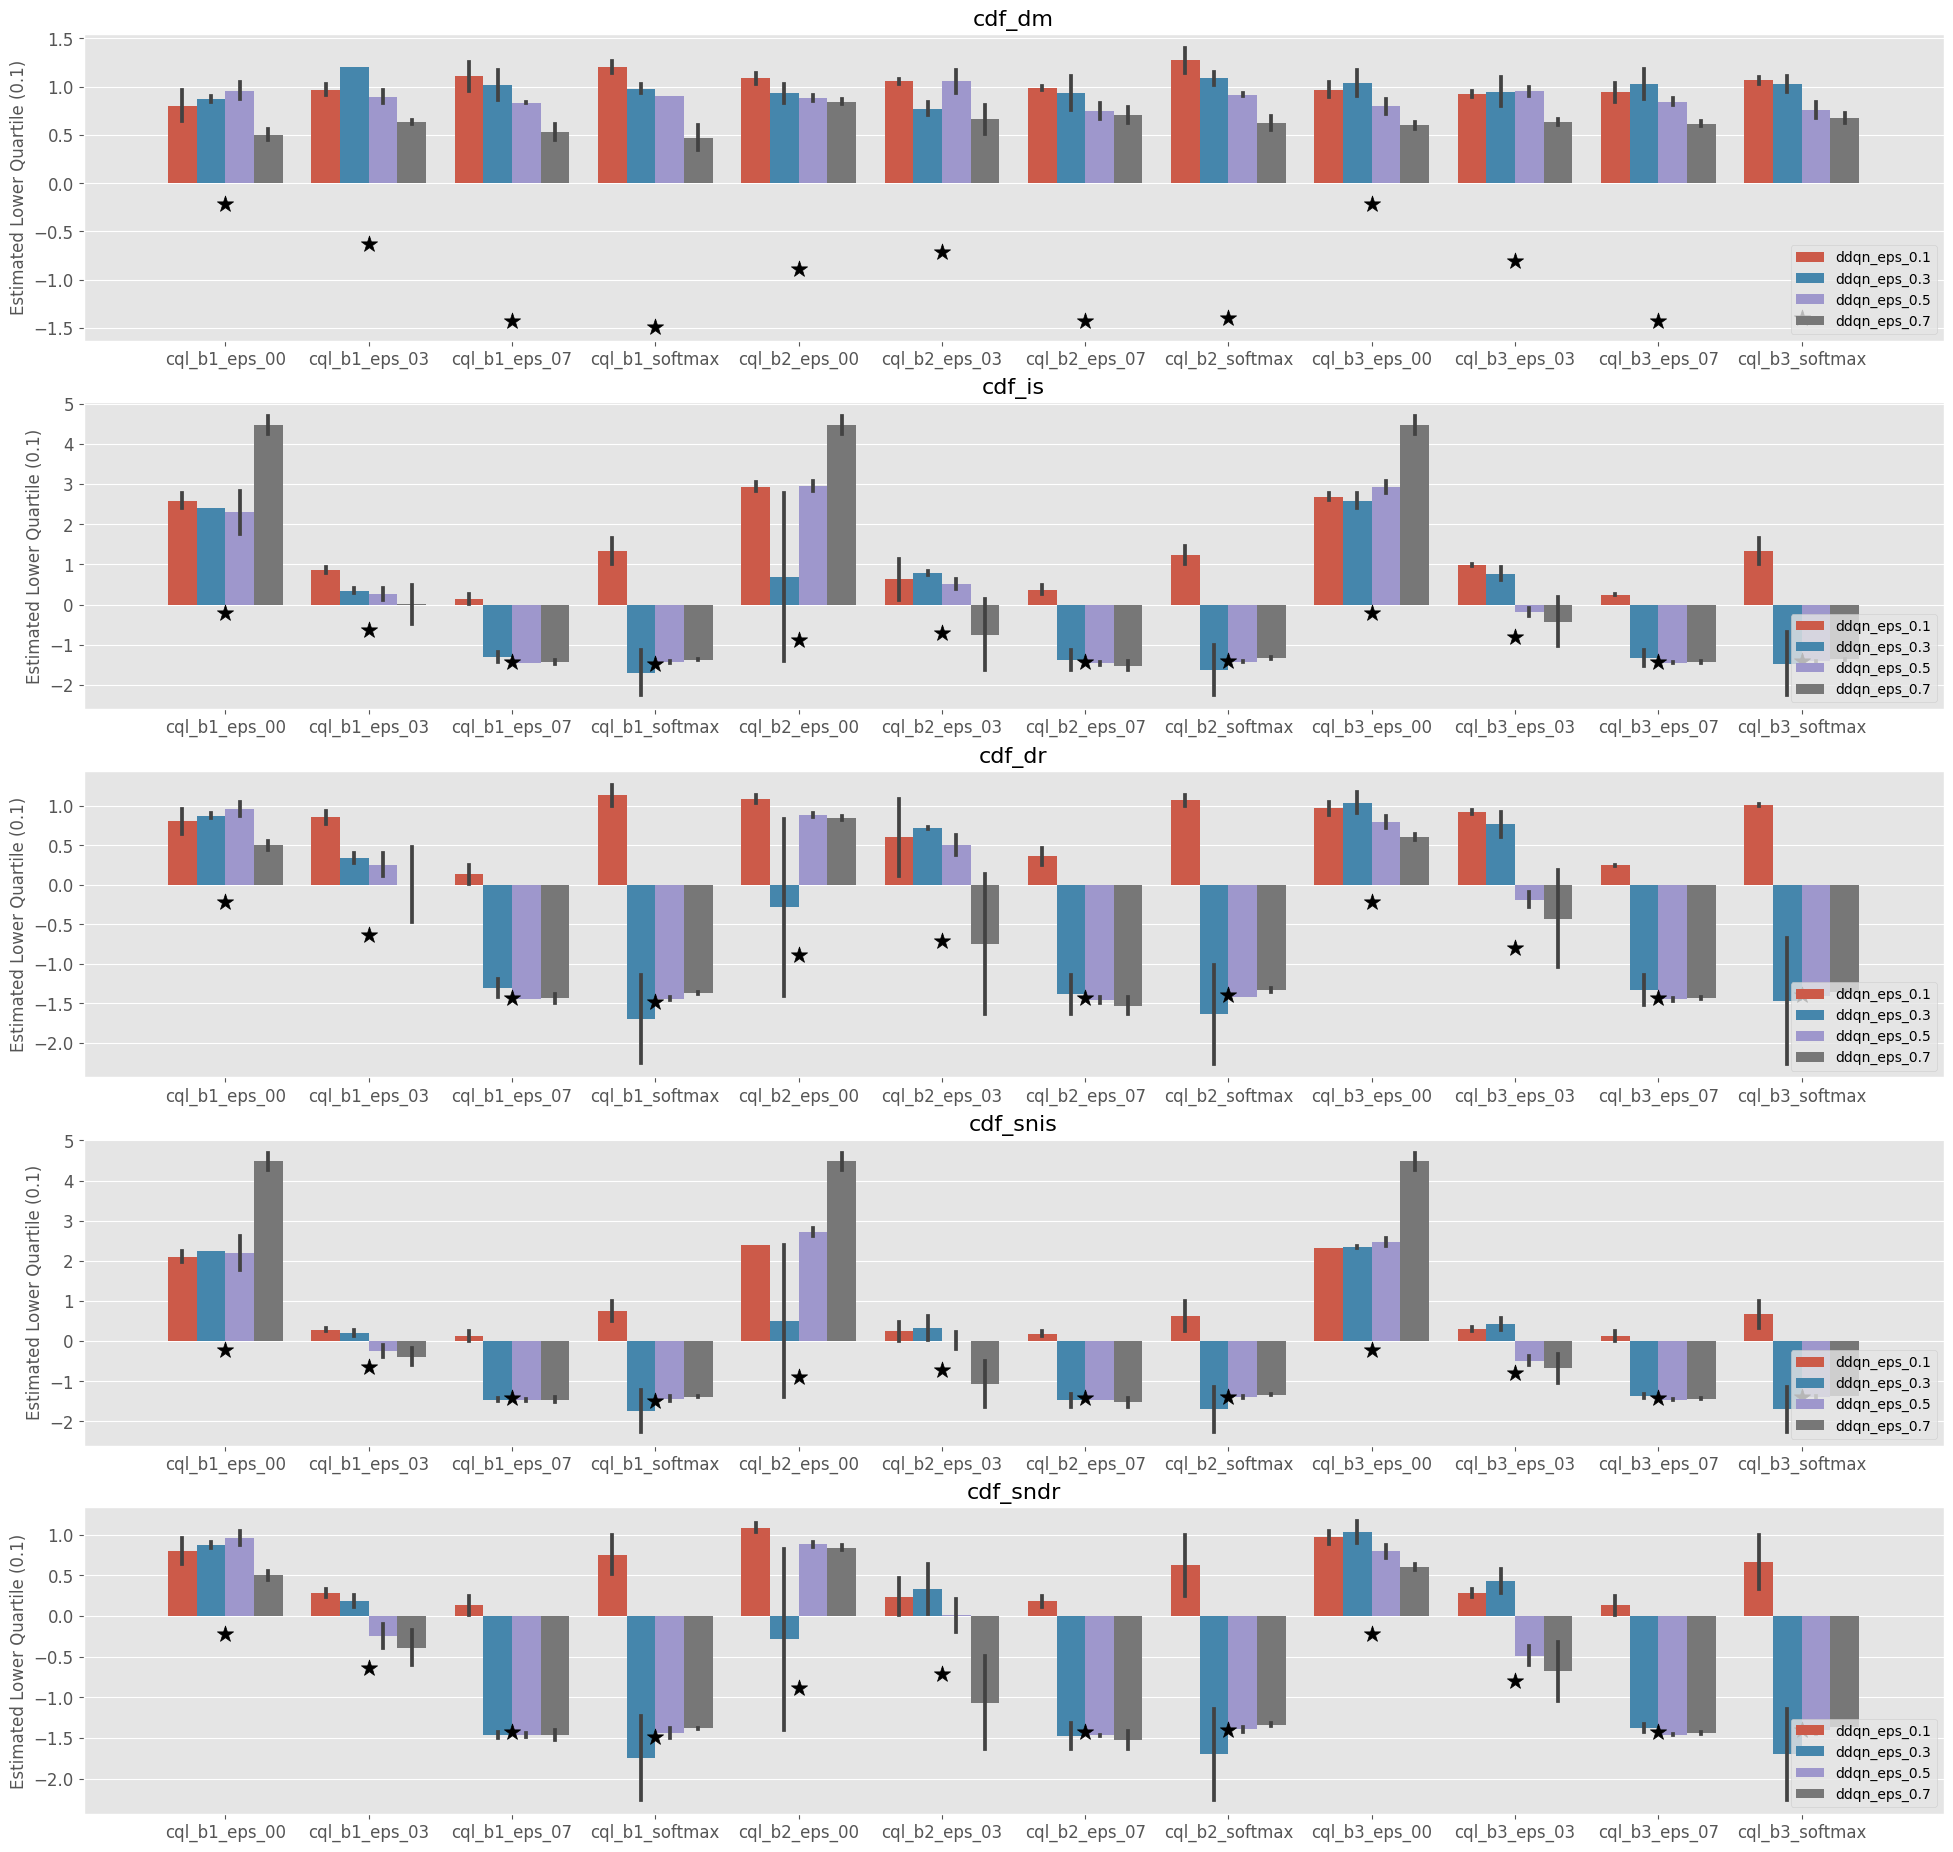

In [49]:
cd_ope.visualize_lower_quartile_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.1,
    plot_type="ci",
    hue="policy",
)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [50]:
from ofrl.ope import OffPolicySelection

In [51]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [52]:
true_selection_result = ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)
true_selection_result["ddqn_eps_0.1"][0]

ranking  policy_value  relative_policy_value  variance  \
0    cql_b2_eps_00      3.772806               5.988458  4.712748   
1    cql_b3_eps_00      3.376523               5.359450  3.762383   
2    cql_b1_eps_00      3.232876               5.131445  4.032589   
3    cql_b2_eps_03      2.566479               4.073694  4.655706   
4    cql_b3_eps_03      2.324909               3.690256  3.933523   
5    cql_b1_eps_03      2.146033               3.406332  3.624665   
6   cql_b2_softmax      0.687795               1.091716  2.386487   
7   cql_b3_softmax      0.663958               1.053880  2.249145   
8   cql_b1_softmax      0.599416               0.951434  2.331548   
9    cql_b2_eps_07      0.598539               0.950043  3.343168   
10   cql_b3_eps_07      0.525151               0.833556  3.073437   
11   cql_b1_eps_07      0.465988               0.739648  2.781266   

   ranking_by_lower_quartile  lower_quartile  \
0              cql_b1_eps_00       -0.480957   
1              cql_b1_eps_03       -0.903307   
2              cql_b1_eps_07       -1.071038   
3             cql_b1_softmax       -1.144576   
4              cql_b2_eps_00       -1.231250   
5              cql_b2_eps_03       -1.239909   
6              cql_b2_eps_07       -1.637998   
7             cql_b2_softmax       -1.814120   
8              cql_b3_eps_00       -1.814120   
9              cql_b3_eps_03       -1.818072   
10             cql_b3_eps_07       -1.894965   
11            cql_b3_softmax       -2.017291   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                         cql_b1_eps_00                  -0.927253  
1                         cql_b3_eps_00                  -1.031350  
2                         cql_b2_eps_00                  -1.208175  
3                         cql_b1_eps_03                  -1.589600  
4                         cql_b2_eps_03                  -1.658462  
5                         cql_b3_eps_03                  -1.671530  
6                        cql_b1_softmax                  -2.014085  
7                        cql_b3_softmax                  -2.047718  
8                        cql_b2_softmax                  -2.161574  
9                         cql_b3_eps_07                  -2.534285  
10                        cql_b1_eps_07                  -2.534285  
11                        cql_b2_eps_07                  -2.561678

In [53]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [54]:
ranking_df["ddqn_eps_0.1"][0]

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0      cql_b2_eps_00                1.504617                         2.388232   
 1     cql_b2_softmax                1.480575                         2.350071   
 2      cql_b1_eps_07                1.414167                         2.244664   
 3      cql_b2_eps_03                1.392511                         2.210289   
 4      cql_b3_eps_00                1.365283                         2.167072   
 5      cql_b1_eps_00                1.361849                         2.161621   
 6      cql_b1_eps_03                1.320590                         2.096132   
 7      cql_b3_eps_03                1.293822                         2.053644   
 8     cql_b1_softmax                1.269329                         2.014767   
 9     cql_b3_softmax                1.225865                         1.945777   
 10     cql_b3_eps_07                1.171475                         1.859445   
 11     cq

In [55]:
metric_df["ddqn_eps_0.1"][0]

estimator  mean_squared_error  rank_correlation    pvalue  regret@1  \
0        dm            1.567413          0.503497  0.095157   0.00000   
1       tis            0.855589          0.902098  0.000060   0.53993   
2      pdis            0.339748          0.832168  0.000785   0.00000   
3        dr            0.170572          0.804196  0.001615   0.00000   
4     sntis            0.212780          0.783217  0.002586   0.00000   
5    snpdis            0.415004          0.853147  0.000418   0.00000   
6      sndr            0.256488          0.804196  0.001615   0.00000   

   type_i_error_rate  type_ii_error_rate  
0                0.0                 0.0  
1                0.0                 0.0  
2                0.0                 0.0  
3                0.0                 0.0  
4                0.0                 0.0  
5                0.0                 0.0  
6                0.0                 0.0

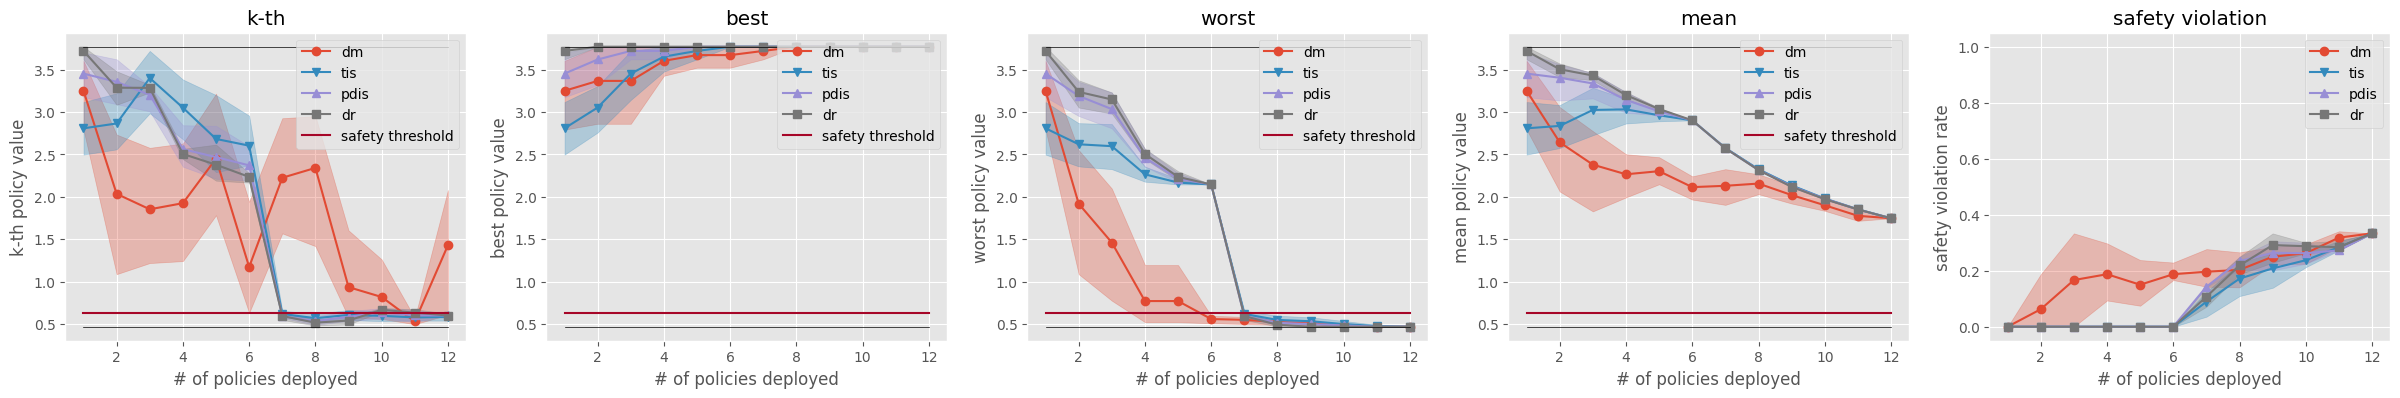

In [56]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

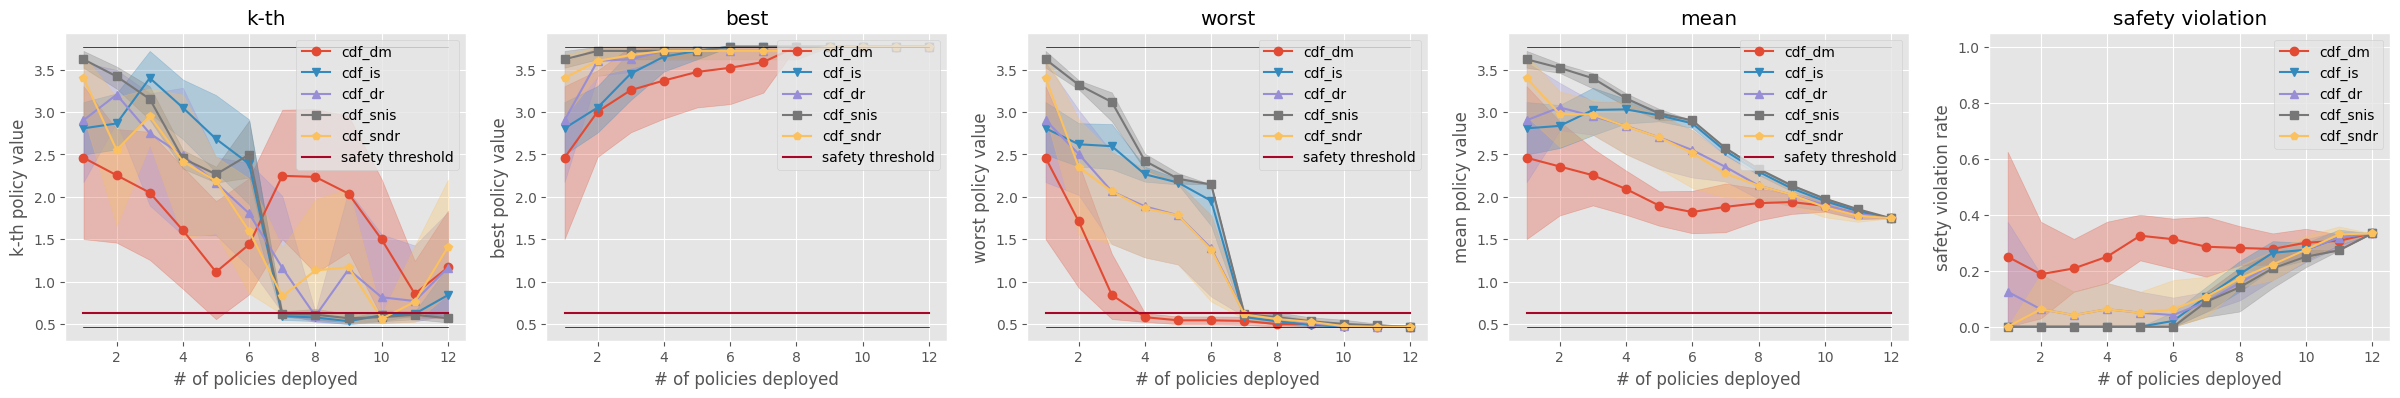

In [57]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

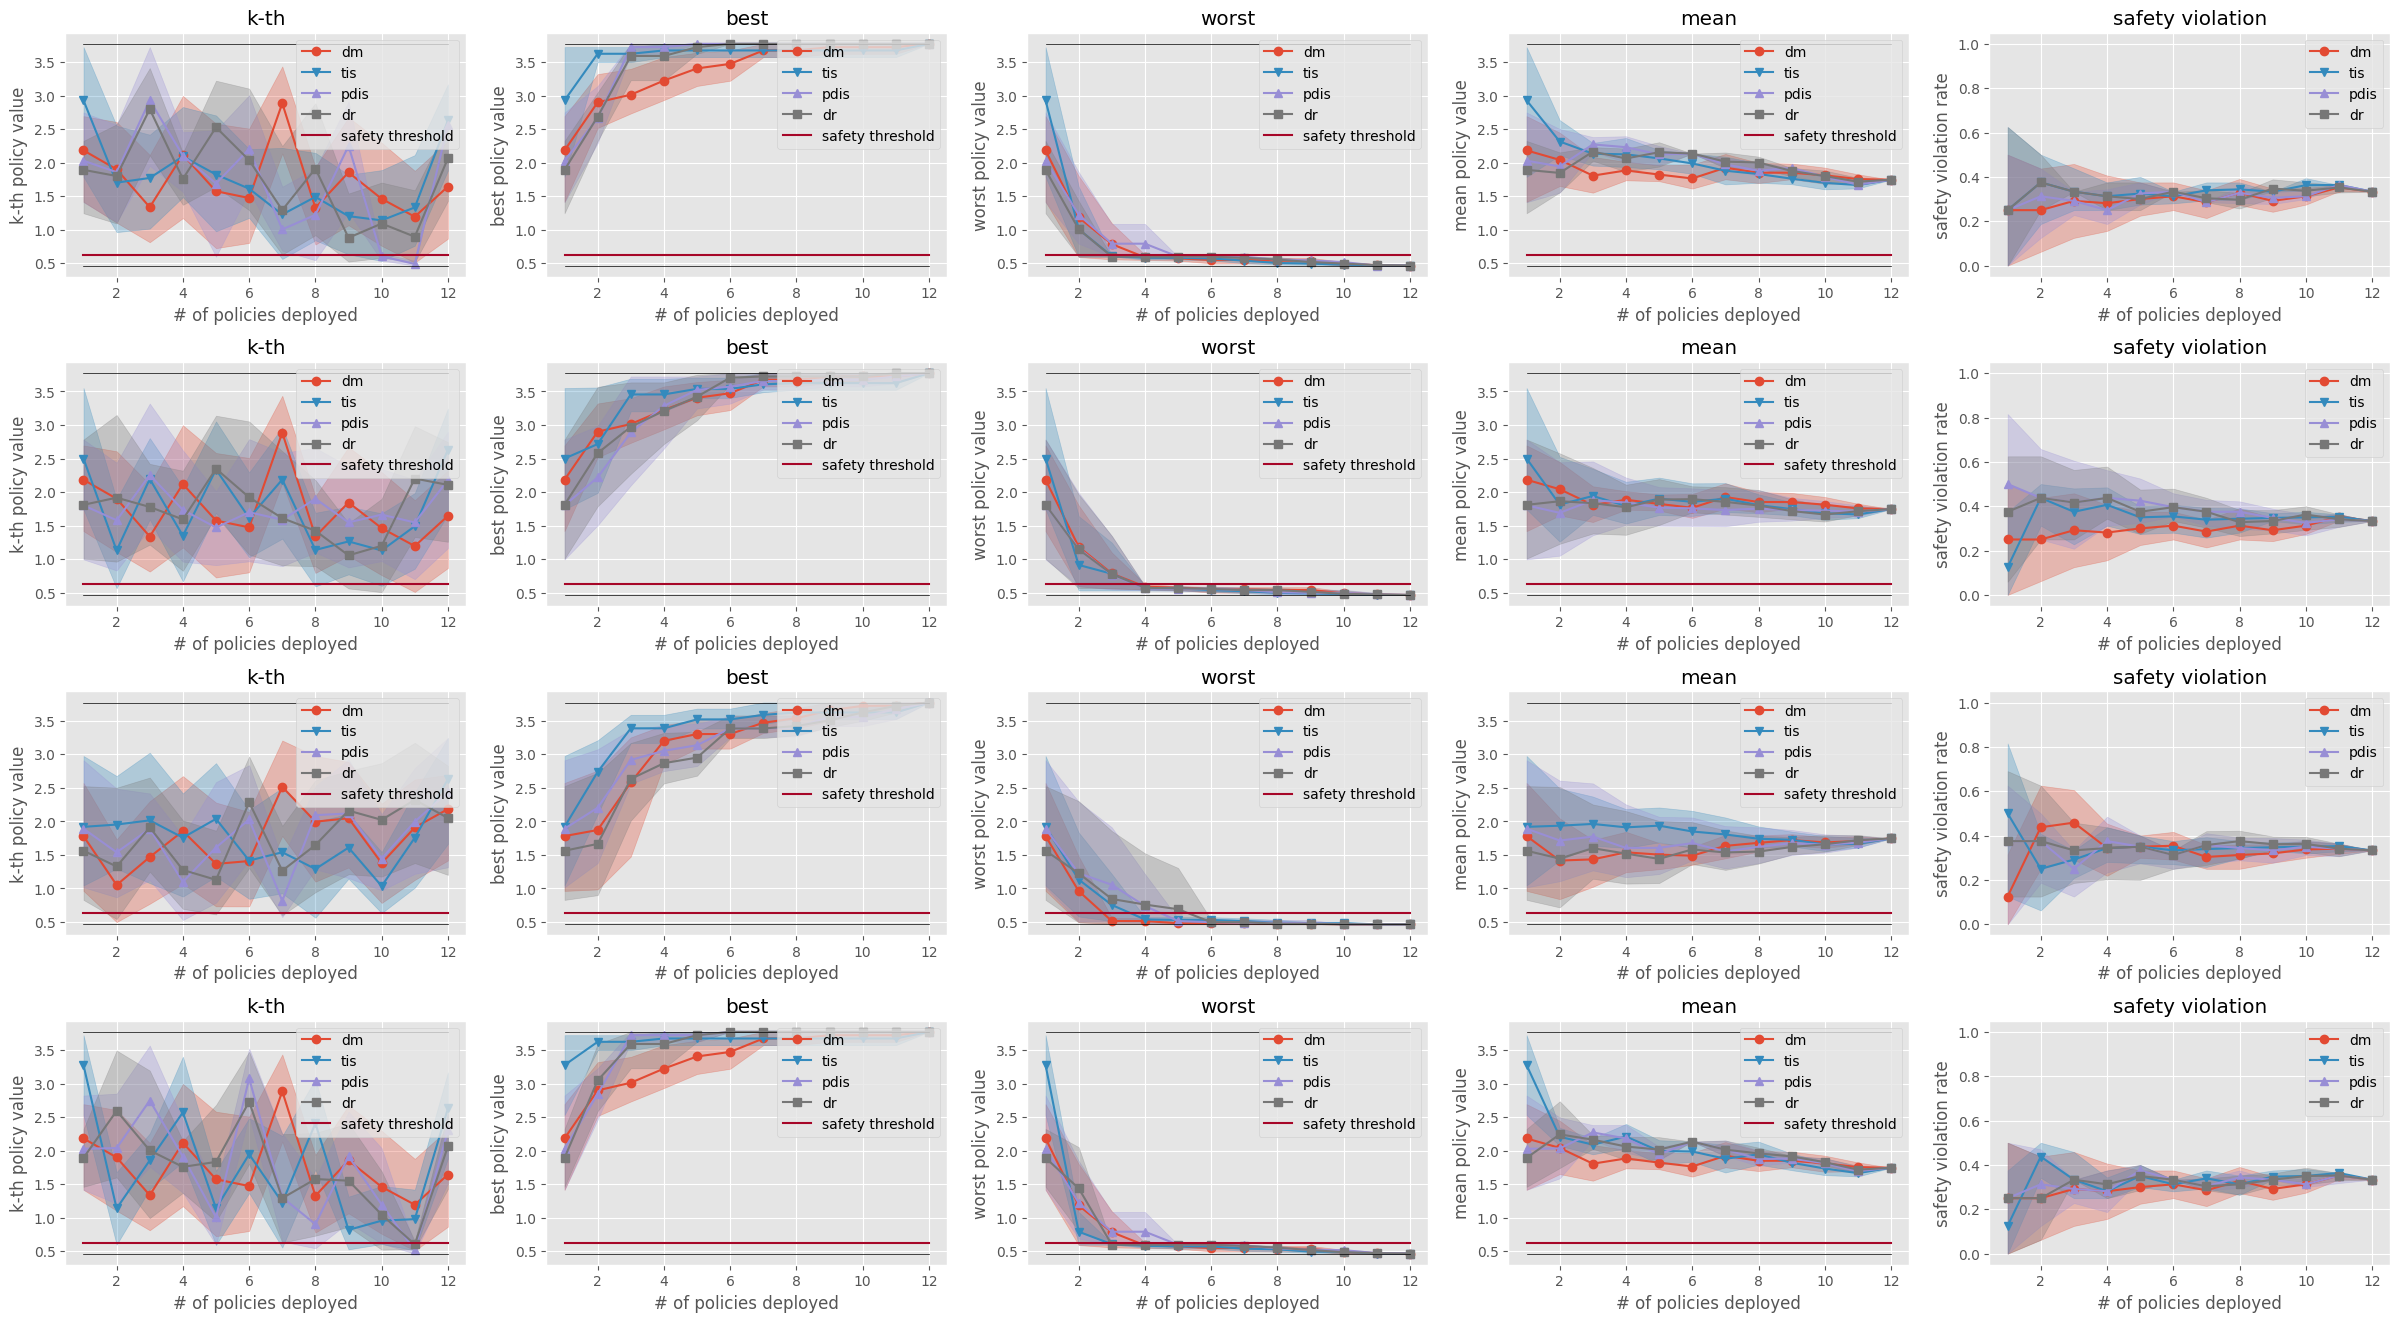

In [58]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

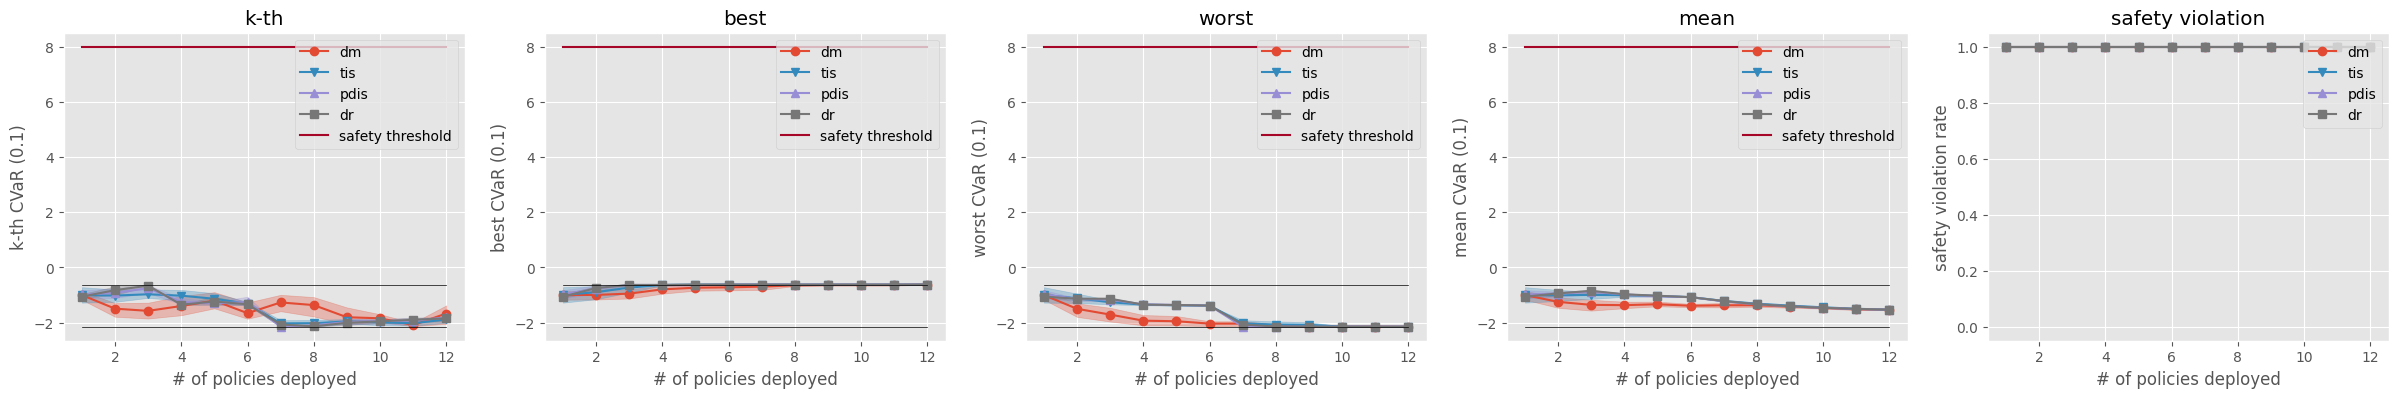

In [59]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
    random_state=random_state,
)

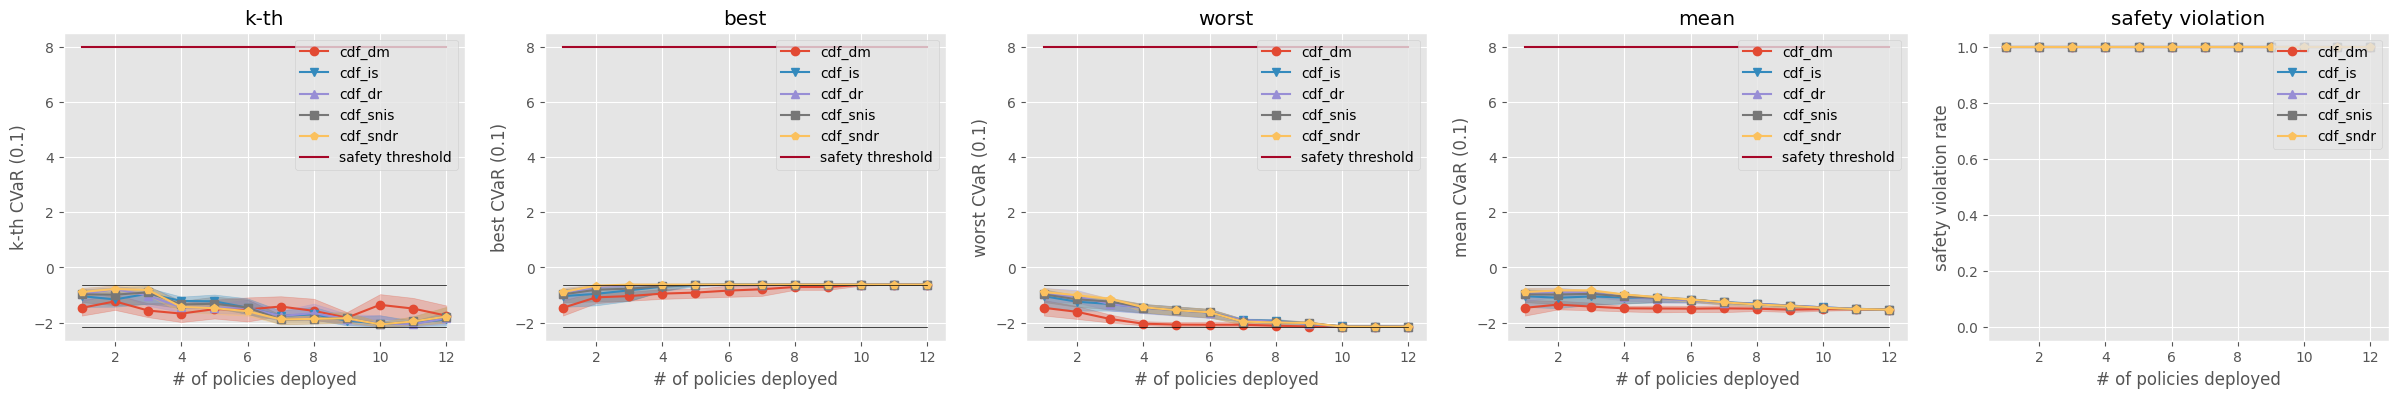

In [60]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
    random_state=random_state,
)

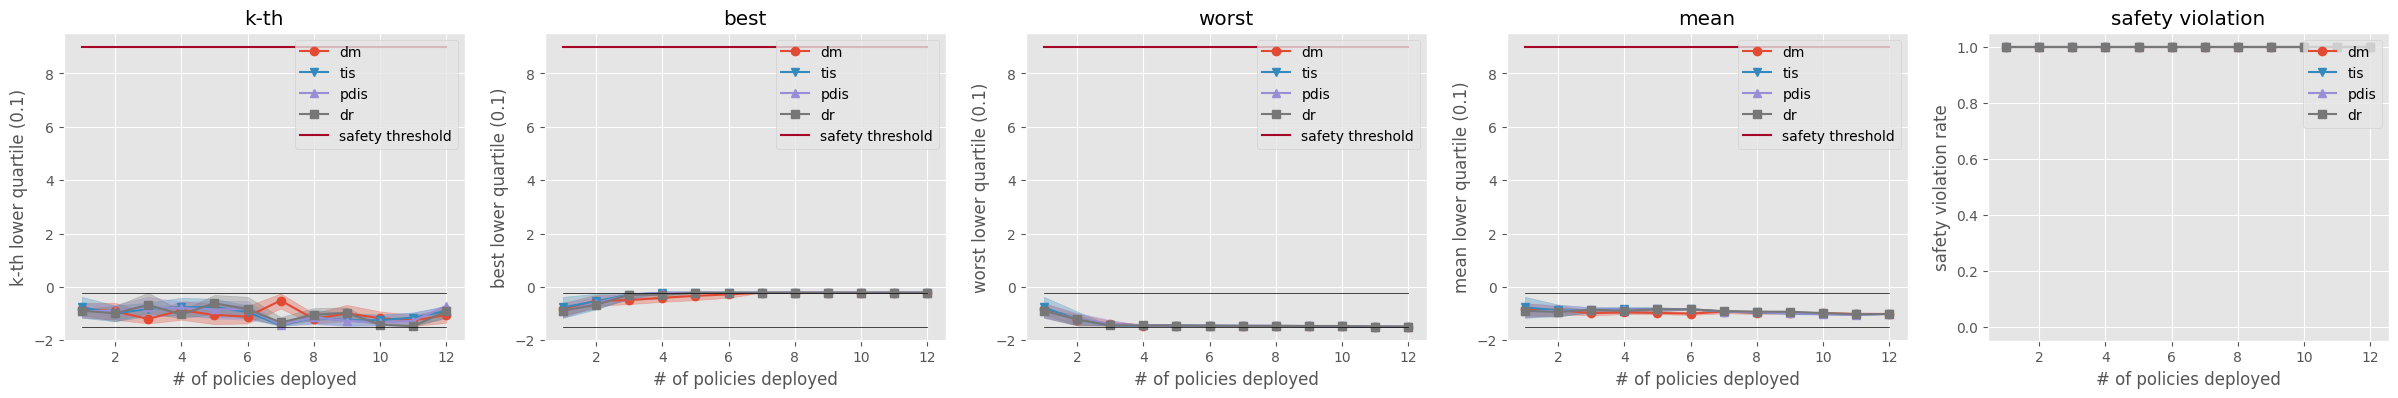

In [61]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=9.0,
    legend=True,
    random_state=random_state,
)

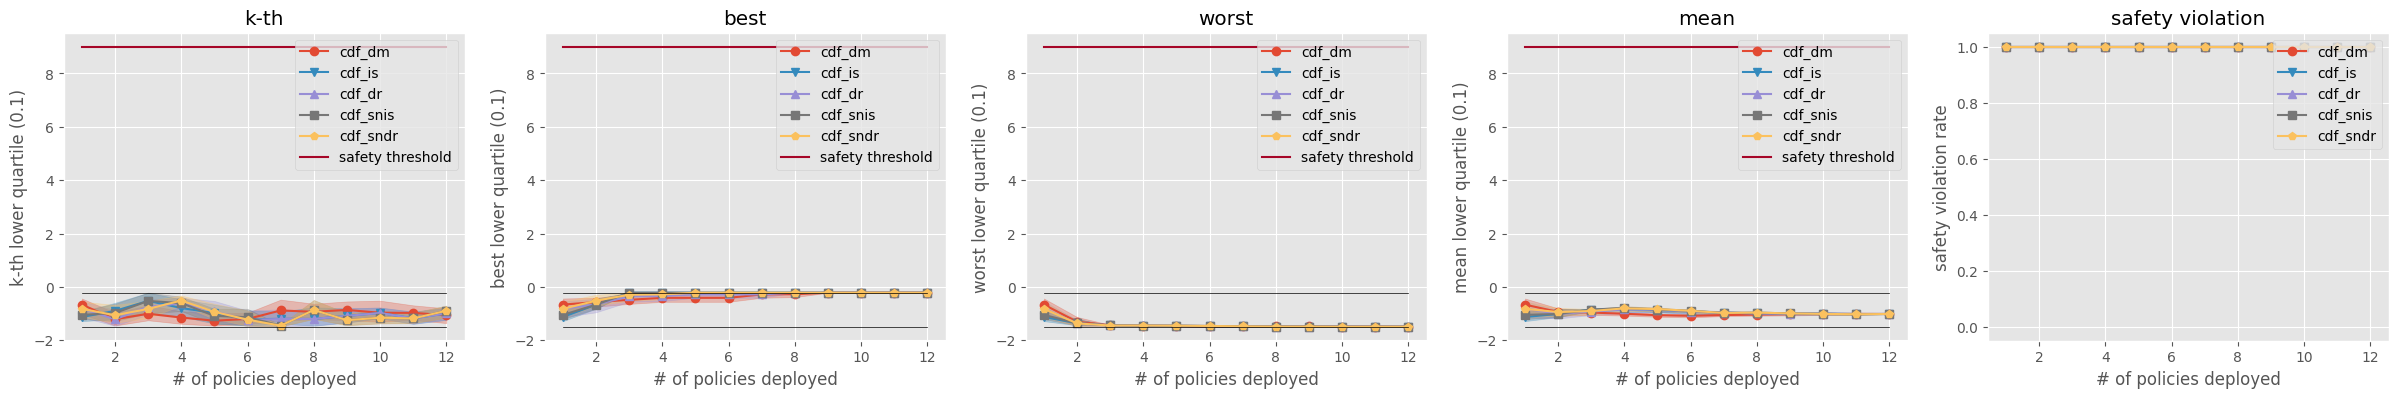

In [62]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=9.0,
    legend=True,
    random_state=random_state,
)

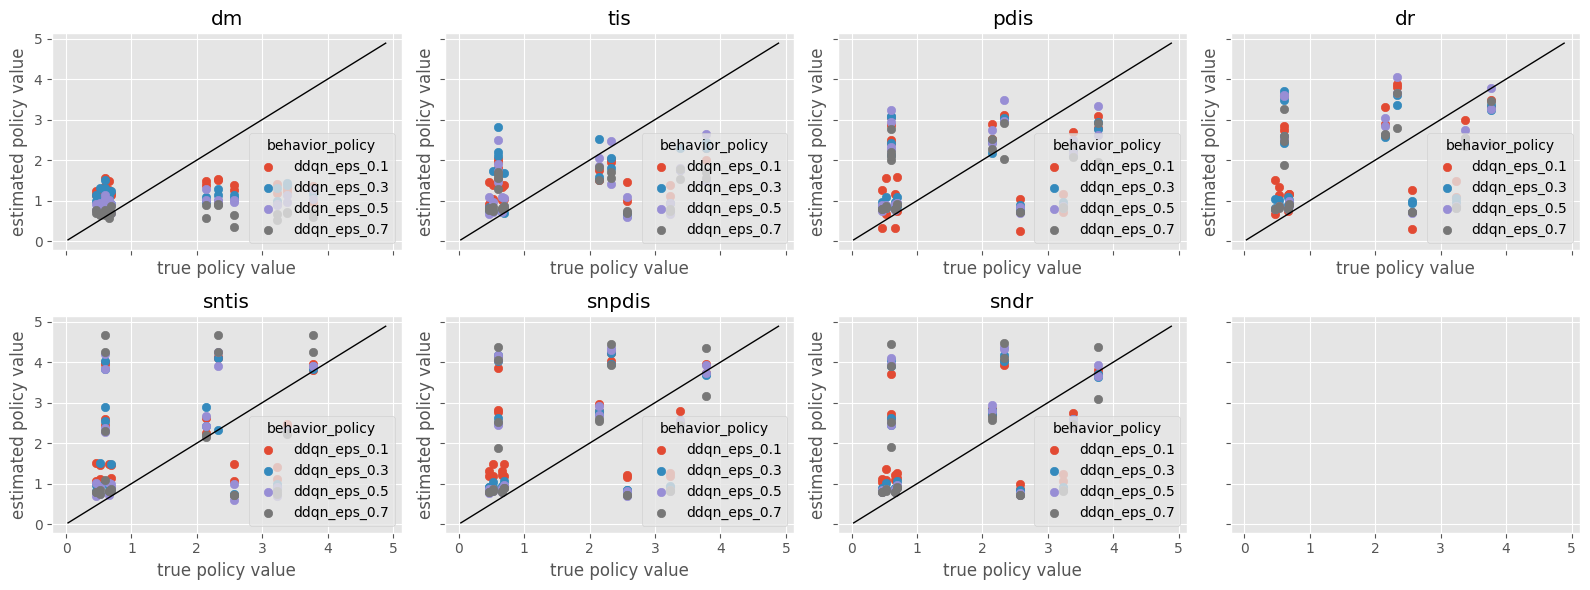

In [63]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=True,
)

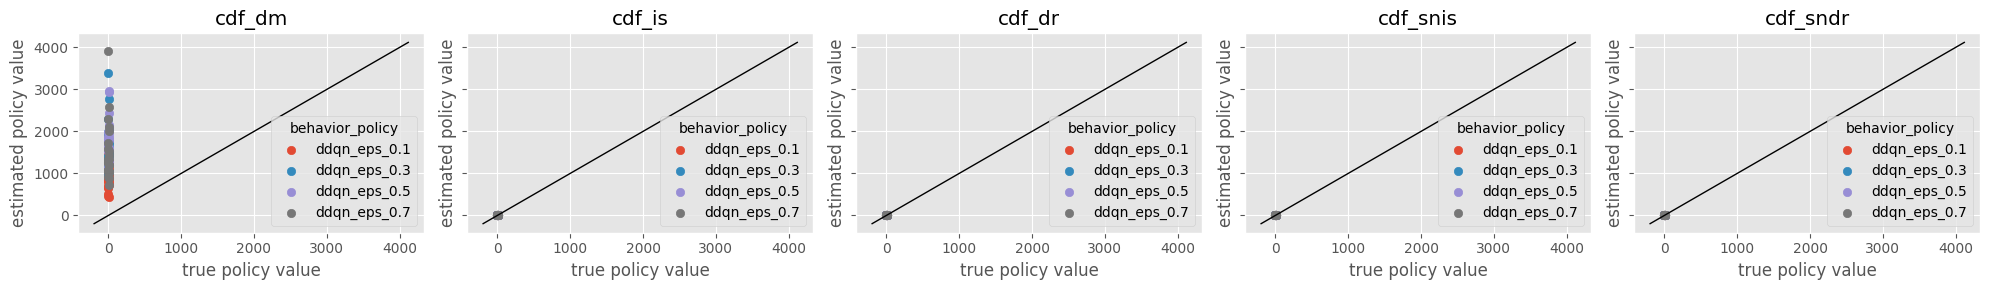

In [64]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

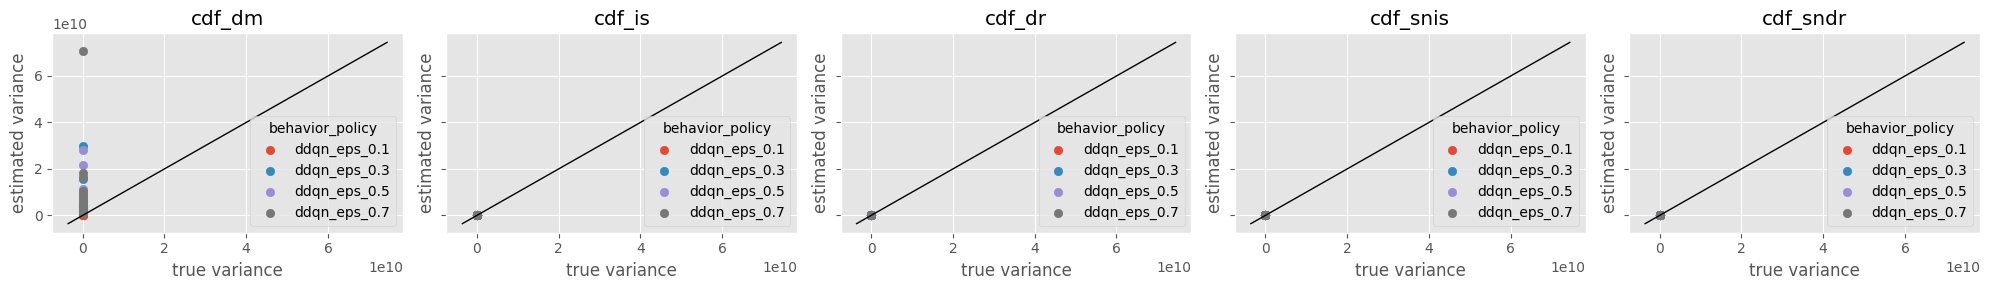

In [65]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

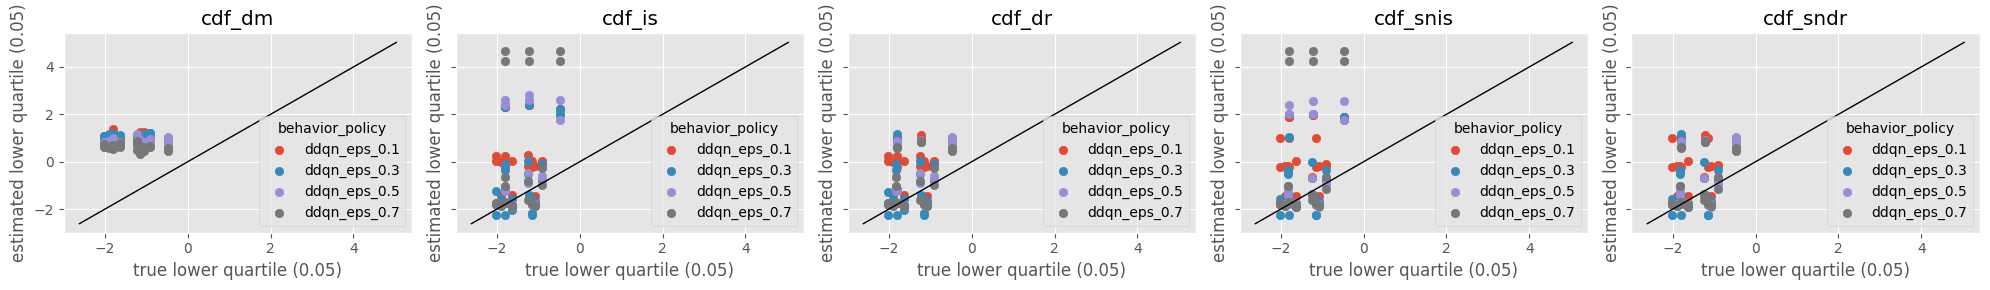

In [66]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

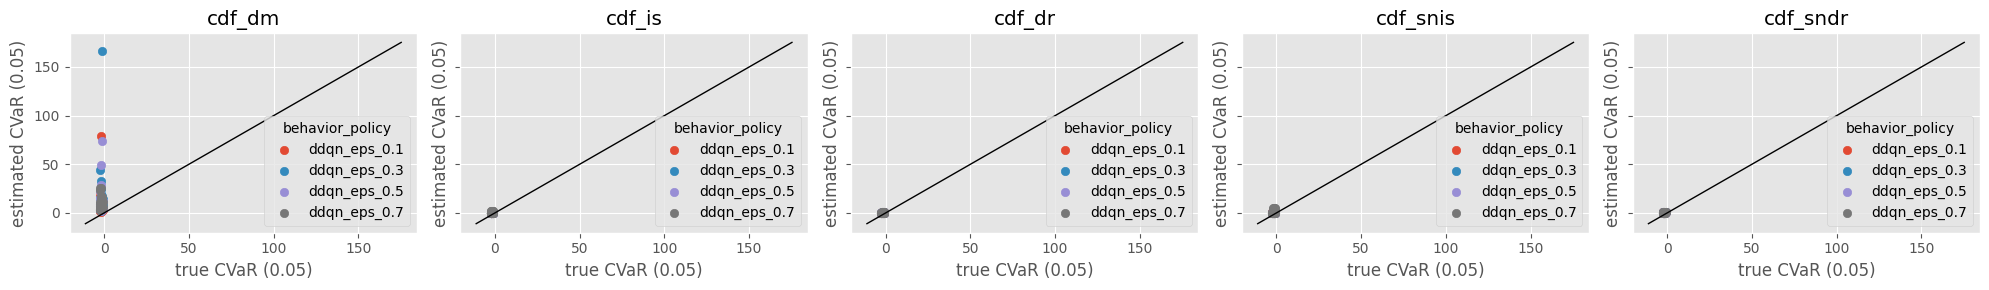

In [67]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

For the examples in the continuous action space, please refer to [examples/quickstart/rec_synthetic_continuous_multiple_datasets.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_continuous_multiple_datasets.ipynb).

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.